In [67]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

# LOAD DATA

In [3]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [4]:
data = sampled_perturbed[0 : 1000]

In [98]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 5
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [152]:


def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :], acc_rate = sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key)
    
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights, key




def run_mcmc(data, k,  key , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

# Full Conditionals and Utilities

In [173]:
def sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """
    nu_prop = 4
    lambda_prop = 0.1
    
    #print("clusdata")
    #print(clusdata)
    
    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    
    print("mu_old")
    print(mu_old)
    print("cov_old")
    print(cov_old)
    
    
    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal from NIW
    mu, cov = sample_from_NIW(mu_old, lambda_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NIW(mu_n, lam_n, phi_n, nu_n)
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(1, beta)
    draw = tfd.Bernoulli(probs = accept_rate).sample()
    #print("draw:" + str(draw))
    
    # Select the new or old values without an if to help JAX implementation
    if(draw == 0):
        mu = mu_old
        cov = cov_old
    
    #print(mu)
    #print(cov)
    #print(np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    print(prec)
    cov = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def evaluate_NIW(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)
    #print("INVCOV")
    #print(inv_cov)
    
    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).prob(x_mu)
    #print(f1)
    #print(f2)
    return f1 * f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    #print("WASSERSTEIN ____ INIZIO")
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    #print("norm: " + str(norm))
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    #print("sqrt_C2: " + str(sqrt_C2))
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    #print("C1_sqrt_C2: " + str(C1_sqrt_C2))
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    #print("sqrt_C2_C1_sqrt_C2: " + str(sqrt_C2_C1_sqrt_C2))
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))
    #print("trace: " + str(trace))
    #print("WASSERSTEIN ____ FINE")
    #print(norm + trace)

    return norm + trace

def compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    nu_prop = 3
    lambda_prop = 0.1
    
    #print("nu_n")
    #print(nu_n)
    #print("lam_n")
    #print(lam_n)
    #print("phi_n")
    #print(phi_n)
    #print("mu_n")
    #print(mu_n)
    
    #print("mu")
    #print(mu)
    #print("cov")
    #print(cov)
    
    
    # Target distribution terms
    num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Proposal distribution terms: CHECK
    #print("Check that proposal is correct in compute_beta")
    #prop_num = evaluate_NIW(mu_old , cov_old , mu , lambda_prop , cov , nu_prop)
    #prop_den = evaluate_NIW(mu , cov , mu_old , lambda_prop , cov_old , nu_prop)
    
    prop_det = np.power((np.linalg.det(cov_old)/np.linalg.det(cov)), 11/2) 
    first_trace = np.trace(np.matmul(cov, np.linalg.inv(cov_old)))
    second_trace = np.trace(np.matmul(cov_old, np.linalg.inv(cov)))
    prop_exp = np.exp(1/2 * (first_trace - second_trace))
    
    print("prop_det")
    print(prop_det)
    print("first_trace")
    print(first_trace)
    print("second_trace")
    print(second_trace)
    print("prop_exp")
    print(prop_exp)
    
    
    prop_term = prop_det * prop_exp
    
    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            #print("----")
            #print("mu_k: " + str(mu_k))
            #print("cov_k: " + str(cov_k))
            #print(compute_Wasserstein(mu , cov , mu_k , cov_k))
            #print(compute_Wasserstein(mu_n , phi_n , mu_k, cov_k))
            #print("----")
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)
            #print("prod: " + str(prod))

    
    print("num_1" + str(num_1))
    print("prop_term" + str(prop_term))
    print("den_1" + str(den_1))
    
    if num_1 < 1e-15 and den_1 < 1e-15:
        num_1 = 1
        den_1 = 1
    elif den_1 < 1e-15:
        return 0

    return num_1 * prop_term * prod / den_1


def update_cluster_allocs(data, weights, uniq_vals):
    print(uniq_vals[:,:,0])
    print(uniq_vals[:,:,1:3])
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    for i in range(len(probs)):
        if np.sum(probs[i]) != 1:
            probs[i] = np.zeros(k)
            idx = np.random.randint(0,k)
            probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    #print("_IIIIIII_____sample_uniq_vals_prior")
    #print(np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]))
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    



In [148]:
mu1 = np.array([-0.38523929,  0.24638733])
cov1 = np.array([[ 0.94447372, -1.99694968],[-1.99694968,  4.25242847]])
evaluate_NIW(mu1, cov1, mu1, 1, cov1, 3)

0.00013278348969484802

In [ ]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k , rng_key)
end = time.time()
print("Total time: " + str(end-start))

#Around 1 minutes instead of 15, 15x speedup :) 

mu_old
[-0.49485322  0.43984599]
cov_old
[[ 0.18481714 -0.06115075]
 [-0.06115075  0.37319215]]
[[26.06074804  6.09989537]
 [ 6.09989537  7.10743652]]
prop_det
260777.67383350906
first_trace
0.6962726151490286
second_trace
6.722886078810525
prop_exp
0.04912895358984078
num_10.0
prop_term12811.734235033104
den_10.0
beta
12118.165015783821
mu_old
[ 0.11902235 -0.43061565]
cov_old
[[0.74196655 1.41138486]
 [1.41138486 2.88711252]]
[[140.90218788 -68.5459247 ]
 [-68.5459247   34.09876652]]
prop_det
4081985.476270882
first_trace
0.5968336172477233
second_trace
9.502325553318954
prop_exp
0.011646541988704249
num_10.0
prop_term47541.01524666974
den_10.0
beta
663754.6163635161
mu_old
[ 0.36168276 -0.08920137]
cov_old
[[ 1.99469369 -0.16550473]
 [-0.16550473  0.66389547]]
[[1.07427398 0.76294828]
 [0.76294828 2.38848843]]
prop_det
180.79293570306982
first_trace
1.3510907552081606
second_trace
3.4760110699830618
prop_exp
0.34560452208973497
num_10.0
prop_term62.482856140859624
den_10.0
beta
498.

/var/folders/xn/nhr_2py54jv04vmm2_nn63g40000gp/T/ipykernel_56923/3462888217.py:201: RuntimeWarning: invalid value encountered in true_divide
  probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]


mu_old
[-1.0044882  -0.64833784]
cov_old
[[0.01305116 0.0010143 ]
 [0.0010143  0.09185689]]
[[173.27157655  -6.70780684]
 [ -6.70780684  34.54986732]]
prop_det
48704.44918735466
first_trace
0.7617785227691194
second_trace
5.421430950186515
prop_exp
0.0973126572259113
num_10.0
prop_term4739.559369145858
den_10.0
beta
54.268283027733794
mu_old
[-0.27562395 -1.62387977]
cov_old
[[0.12308214 0.23189049]
 [0.23189049 0.45766984]]
[[ 862.58122463 -394.00773787]
 [-394.00773787  181.07537138]]
prop_det
132.1374144613706
first_trace
2.595586457030784
second_trace
6.307780248216574
prop_exp
0.15628142421775632
num_10.0
prop_term20.65062332447495
den_10.0
beta
1.5486791776577287
mu_old
[-0.74859756  2.78759183]
cov_old
[[ 0.11105077 -0.05689957]
 [-0.05689957  0.11533603]]
[[22.93513868 18.19720816]
 [18.19720816 24.04395194]]
prop_det
60.51797758452771
first_trace
1.5410158173533506
second_trace
3.2492720842671754
prop_exp
0.4256541429546813
num_10.0
prop_term25.759727882092758
den_10.0
beta
0.

mu_old
[-0.93853308 -1.42823262]
cov_old
[[0.0001076  0.00014426]
 [0.00014426 0.0004662 ]]
[[ 32942.44257135 -13681.72944653]
 [-13681.72944653  17526.99202676]]
prop_det
666799.8030288751
first_trace
0.6782809956612769
second_trace
7.76815557961557
prop_exp
0.028870432860686343
num_10.0
prop_term19250.79894486402
den_10.0
beta
507.7200479460942
mu_old
[-1.80004619 -6.07126438]
cov_old
[[0.03275238 0.08074796]
 [0.08074796 0.20297561]]
[[ 2899.41356071 -1193.09782689]
 [-1193.09782689   494.71665828]]
prop_det
6.1829090380261205
first_trace
1.9370389998500457
second_trace
2.6976873258424945
prop_exp
0.6836397625757031
num_10.0
prop_term4.226882466783346
den_10.0
beta
32.56299167051606
mu_old
[-0.62907685  1.96993123]
cov_old
[[ 0.00107139 -0.00063159]
 [-0.00063159  0.00116719]]
[[2356.44183574 4458.38195767]
 [4458.38195767 9607.23560852]]
prop_det
110.35694166661628
first_trace
3.4467272107364035
second_trace
8.106344049214627
prop_exp
0.09731438886843745
num_10.0
prop_term10.739318

mu_old
[-0.96044604 -1.42951411]
cov_old
[[1.29792226e-06 1.46821716e-06]
 [1.46821716e-06 2.24876100e-06]]
[[ 1247121.91824468 -1149976.26557084]
 [-1149976.26557084  2078865.1232987 ]]
prop_det
0.8419107604102939
first_trace
3.009407443724739
second_trace
2.9167083289461644
prop_exp
1.0474404875330794
num_10.0
prop_term0.8818514173435038
den_10.0
beta
0.005537025733294672
mu_old
[-1.33926295 -5.01396357]
cov_old
[[0.00062485 0.00138843]
 [0.00138843 0.00313458]]
[[ 827006.96364094 -387543.21352672]
 [-387543.21352672  182595.25696843]]
prop_det
51935407.2841959
first_trace
0.5127792531832718
second_trace
12.964088841866783
prop_exp
0.001978028189548916
num_10.0
prop_term102729.69964384359
den_10.0
beta
6851.115535291538
mu_old
[-0.80969307  2.08314103]
cov_old
[[ 1.23487058e-04 -3.88489591e-05]
 [-3.88489591e-05  1.59007805e-05]]
[[206061.18800211 390786.78427998]
 [390786.78427998 925808.23096146]]
prop_det
6425171.7845120635
first_trace
0.5670094421805681
second_trace
9.80364365829

 [ 3.05888526  1.86765483]]
[[[ 6.62936722e-08  8.08914227e-08]
  [ 8.08914227e-08  1.30104992e-07]]

 [[ 5.58350147e-05  1.18800144e-04]
  [ 1.18800144e-04  2.52917055e-04]]

 [[ 7.24869928e-07 -4.27504764e-07]
  [-4.27504764e-07  3.18399764e-07]]

 [[ 1.09776712e-05 -1.35058089e-05]
  [-1.35058089e-05  2.02954901e-05]]

 [[ 2.46923330e-07  7.64097591e-08]
  [ 7.64097591e-08  9.84893973e-08]]]
mu_old
[-0.96036721 -1.42916697]
cov_old
[[6.62936722e-08 8.08914227e-08]
 [8.08914227e-08 1.30104992e-07]]
[[ 1.41744329e+08 -9.06944737e+07]
 [-9.06944737e+07  8.28678611e+07]]
prop_det
57237.85075244472
first_trace
0.751208740331011
second_trace
5.5054644524387895
prop_exp
0.09281677819159076
num_10.0
prop_term5312.632897453038
den_10.0
beta
7.616948323025939
mu_old
[-1.46478632 -5.29484728]
cov_old
[[5.58350147e-05 1.18800144e-04]
 [1.18800144e-04 2.52917055e-04]]
[[ 1.26653073e+08 -5.80071162e+07]
 [-5.80071162e+07  2.65747673e+07]]
prop_det
77775.5748114773
first_trace
1.3396035722050783
s

prop_det
172639.9503645895
first_trace
0.6826195174723793
second_trace
6.11485567356779
prop_exp
0.06613097206840535
num_10.0
prop_term11416.847735451553
den_10.0
beta
5.966902326109518
mu_old
[2.57546756 0.74118915]
cov_old
[[ 1.20625405e-07 -2.20844071e-07]
 [-2.20844071e-07  5.33946391e-07]]
[[65695364.61156529 25157968.61476031]
 [25157968.61476031 13080572.61085219]]
prop_det
1045.9729545383911
first_trace
1.0725632940265526
second_trace
3.79687805717474
prop_exp
0.2561076585807879
num_10.0
prop_term267.88168432565624
den_10.0
beta
0.2860829537165754
mu_old
[3.05833809 1.86778615]
cov_old
[[1.26373362e-08 4.78563176e-09]
 [4.78563176e-09 7.94543781e-09]]
[[ 1.15122880e+08 -7.54598023e+07]
 [-7.54598023e+07  4.43790854e+08]]
prop_det
1011.5432103174172
first_trace
1.2103685201130103
second_trace
4.258713525139051
prop_exp
0.21780121227169566
num_10.0
prop_term220.31533747233627
den_10.0
beta
0.05513925470369956
[[-0.95938048 -1.42858663]
 [-1.44898414 -5.25807458]
 [-0.79713565  2.

Iter 21 / 1000 Remaining minutes: 13.9 mu_old
[-0.95940803 -1.42865851]
cov_old
[[9.06909998e-11 1.33248810e-10]
 [1.33248810e-10 2.05810493e-10]]
[[ 3.21460670e+11 -1.95343352e+11]
 [-1.95343352e+11  1.37878987e+11]]
prop_det
13140.432045259839
first_trace
0.9756801366713512
second_trace
5.471993599574759
prop_exp
0.10559368280183462
num_10.0
prop_term1387.5466132662305
den_10.0
beta
0.020327839956087862
mu_old
[-1.45035362 -5.26090048]
cov_old
[[1.22443132e-08 2.50013896e-08]
 [2.50013896e-08 5.10648632e-08]]
[[ 3.58764892e+10 -1.77154720e+10]
 [-1.77154720e+10  8.82538376e+09]]
prop_det
0.02586957622062268
first_trace
8.021100111053443
second_trace
4.127149261711622
prop_exp
7.007460902562403
num_10.0
prop_term0.1812800439318715
den_10.0
beta
0.0003378681238961563
mu_old
[-0.79734253  2.07576514]
cov_old
[[1.02449472e-09 3.71021566e-10]
 [3.71021566e-10 1.85420671e-10]]
[[ 1.66569644e+10 -3.83764952e+10]
 [-3.83764952e+10  1.02933803e+11]]
prop_det
1151096.9511954086
first_trace
0.6

prop_det
751674.8870442649
first_trace
0.6377489343188429
second_trace
7.464811404781528
prop_exp
0.03292472988840671
num_10.0
prop_term24748.692619831047
den_10.0
beta
10.47136569701916
mu_old
[3.05836434 1.8677048 ]
cov_old
[[2.52595321e-09 1.00838169e-09]
 [1.00838169e-09 2.45068170e-09]]
[[ 7.00482928e+08 -4.14575644e+08]
 [-4.14575644e+08  1.69021465e+09]]
prop_det
9005.667961127207
first_trace
0.9693327249708017
second_trace
5.075464229742107
prop_exp
0.1283408386114798
num_10.0
prop_term1155.794978387601
den_10.0
beta
0.1341914911529063
[[-0.95940803 -1.42865851]
 [-1.45046233 -5.26113017]
 [-0.79735879  2.07576158]
 [ 2.57589628  0.73952175]
 [ 3.05831878  1.86760812]]
[[[ 9.06909998e-11  1.33248810e-10]
  [ 1.33248810e-10  2.05810493e-10]]

 [[ 5.58697639e-10  1.14436150e-09]
  [ 1.14436150e-09  2.34696950e-09]]

 [[ 4.25681726e-10  1.58705617e-10]
  [ 1.58705617e-10  6.88847117e-11]]

 [[ 1.16331133e-08 -1.61300978e-08]
  [-1.61300978e-08  2.25312367e-08]]

 [[ 1.67001821e-09

[[ 3.29279731e+12 -4.37065049e+12]
 [-4.37065049e+12  6.12789394e+12]]
prop_det
33620.25502650262
first_trace
0.9517806234524375
second_trace
6.332208747335422
prop_exp
0.06786641020121592
num_10.0
prop_term2281.6860186981185
den_10.0
beta
0.06499270538384598
mu_old
[2.57583971 0.73959755]
cov_old
[[ 3.68887110e-10 -5.17535450e-10]
 [-5.17535450e-10  7.36390079e-10]]
[[3.35809178e+11 2.60568545e+11]
 [2.60568545e+11 2.03185124e+11]]
prop_det
3.8108723578184116
first_trace
2.9734331772855143
second_trace
3.792267668443344
prop_exp
0.6640371079642472
num_10.0
prop_term2.5305606593066297
den_10.0
beta
6.465966536878832e-05
mu_old
[3.05833365 1.86765859]
cov_old
[[2.44040423e-10 3.82111513e-11]
 [3.82111513e-11 1.60620230e-10]]
[[ 1.48642576e+10 -2.35037125e+10]
 [-2.35037125e+10  4.43853066e+10]]
prop_det
2193.9984093766543
first_trace
2.2122403642359267
second_trace
8.960450040754651
prop_exp
0.034248762775844876
num_10.0
prop_term75.14173105332203
den_10.0
beta
0.004648164735923615
[[-0

mu_old
[-0.95939799 -1.4286539 ]
cov_old
[[7.31004745e-13 9.39383711e-13]
 [9.39383711e-13 1.28494308e-12]]
[[ 7.65360473e+13 -6.42894188e+13]
 [-6.42894188e+13  5.63011374e+13]]
prop_det
316817.16469084605
first_trace
0.750456350574769
second_trace
7.5071047183963415
prop_exp
0.03410455984250536
num_10.0
prop_term10804.909952331835
den_10.0
beta
0.014863352126901812
mu_old
[-1.45047545 -5.26115524]
cov_old
[[4.01350044e-11 8.38855026e-11]
 [8.38855026e-11 1.75560381e-10]]
[[ 1.31037035e+13 -6.09876961e+12]
 [-6.09876961e+12  2.86420108e+12]]
prop_det
544.7201178654589
first_trace
1.768663627523864
second_trace
5.560723746889607
prop_exp
0.15016357790810045
num_10.0
prop_term81.79712185719949
den_10.0
beta
0.02426312705696632
mu_old
[-0.79733011  2.07577574]
cov_old
[[5.69863285e-12 4.06448491e-12]
 [4.06448491e-12 3.06213573e-12]]
[[ 2.16855282e+13 -2.64625750e+13]
 [-2.64625750e+13  3.33951798e+13]]
prop_det
25712047.834216196
first_trace
0.482056824846941
second_trace
10.72496322662

prop_det
4410.931006808537
first_trace
1.0287728489768586
second_trace
4.731091640175045
prop_exp
0.1570549718731148
num_10.0
prop_term692.7586452085646
den_10.0
beta
0.004052890988405434
mu_old
[3.0583594  1.86766711]
cov_old
[[3.89276753e-11 8.80802570e-12]
 [8.80802570e-12 2.31104307e-11]]
[[6.89002557e+10 1.70433616e+10]
 [1.70433616e+10 1.28951744e+11]]
prop_det
46786.29746180756
first_trace
0.8439475541469055
second_trace
5.962493872541748
prop_exp
0.07736094910778753
num_10.0
prop_term3619.4323768847034
den_10.0
beta
0.030572823163270132
[[-0.95939799 -1.4286539 ]
 [-1.45047326 -5.26115155]
 [-0.79732301  2.07578176]
 [ 2.57584641  0.73958367]
 [ 3.0583523   1.86766644]]
[[[ 7.31004745e-13  9.39383711e-13]
  [ 9.39383711e-13  1.28494308e-12]]

 [[ 1.36712732e-12  2.80126946e-12]
  [ 2.80126946e-12  5.74471679e-12]]

 [[ 1.39587217e-12  1.10609891e-12]
  [ 1.10609891e-12  9.06424982e-13]]

 [[ 5.93094501e-12 -7.62376780e-12]
  [-7.62376780e-12  1.01040106e-11]]

 [[ 1.50042778e-1

prop_det
0.2740567774342328
first_trace
3.6592982624534756
second_trace
2.891924827514053
prop_exp
1.4676855694019242
num_10.0
prop_term0.40222917743701836
den_10.0
beta
2.7982621376036856e-06
mu_old
[2.57584641 0.73958367]
cov_old
[[ 5.93094501e-12 -7.62376780e-12]
 [-7.62376780e-12  1.01040106e-11]]
[[1.04429216e+13 7.36973510e+12]
 [7.36973510e+12 5.61113866e+12]]
prop_det
76728.1133024652
first_trace
0.809985251662841
second_trace
6.261100288030718
prop_exp
0.0655096697029773
num_10.0
prop_term5026.433359377113
den_10.0
beta
0.017775399464769238
mu_old
[3.0583523  1.86766644]
cov_old
[[ 1.50042778e-11 -1.98309323e-12]
 [-1.98309323e-12  8.01694137e-12]]
[[ 1.49403543e+11 -1.42808964e+11]
 [-1.42808964e+11  4.84943001e+11]]
prop_det
20068.05955333922
first_trace
1.1054334047608572
second_trace
6.695858847743593
prop_exp
0.06110187526801479
num_10.0
prop_term1226.1960716992255
den_10.0
beta
0.00729076317391649
[[-0.95939799 -1.4286539 ]
 [-1.45047477 -5.26115441]
 [-0.79732154  2.075

mu_old
[-0.95939568 -1.4286503 ]
cov_old
[[6.35479910e-14 7.77632842e-14]
 [7.77632842e-14 1.10526707e-13]]
[[ 4.15141222e+14 -2.51128525e+14]
 [-2.51128525e+14  1.70871199e+14]]
prop_det
74370.28429193594
first_trace
0.8079548097132325
second_trace
6.21006377180187
prop_exp
0.06713468315128429
num_10.0
prop_term4992.825471810054
den_10.0
beta
0.01300387301045878
mu_old
[-1.45047332 -5.2611514 ]
cov_old
[[1.15930875e-13 2.36588573e-13]
 [2.36588573e-13 4.83069128e-13]]
[[ 1.01985698e+17 -4.99013821e+16]
 [-4.99013821e+16  2.44260643e+16]]
prop_det
80362728.39550276
first_trace
0.3863672730666394
second_trace
10.575063906682772
prop_exp
0.006131300998984142
num_10.0
prop_term492728.07689243736
den_10.0
beta
5.390657877616078
mu_old
[-0.79732154  2.07578285]
cov_old
[[1.58006440e-13 1.32470838e-13]
 [1.32470838e-13 1.15967756e-13]]
[[ 1.39039170e+14 -1.35360512e+14]
 [-1.35360512e+14  1.55151340e+14]]
prop_det
160.93679308121767
first_trace
1.6272992420621293
second_trace
4.0989959058706

[[5.44340054e+11 5.53072659e+09]
 [5.53072659e+09 1.64897929e+11]]
prop_det
400856.91809636954
first_trace
0.906793959775057
second_trace
9.467470509299178
prop_exp
0.013837980255173245
num_10.0
prop_term5547.05011776716
den_10.0
beta
0.08347057281213581
[[-0.95939568 -1.4286503 ]
 [-1.45047278 -5.26115028]
 [-0.79732154  2.07578285]
 [ 2.57584641  0.73958367]
 [ 3.0583523   1.86766644]]
[[[ 6.35479910e-14  7.77632842e-14]
  [ 7.77632842e-14  1.10526707e-13]]

 [[ 2.54103892e-14  5.19123150e-14]
  [ 5.19123150e-14  1.06095531e-13]]

 [[ 1.58006440e-13  1.32470838e-13]
  [ 1.32470838e-13  1.15967756e-13]]

 [[ 5.93094501e-12 -7.62376780e-12]
  [-7.62376780e-12  1.01040106e-11]]

 [[ 1.50042778e-11 -1.98309323e-12]
  [-1.98309323e-12  8.01694137e-12]]]
mu_old
[-0.95939568 -1.4286503 ]
cov_old
[[6.35479910e-14 7.77632842e-14]
 [7.77632842e-14 1.10526707e-13]]
[[ 3.21152673e+14 -2.29049546e+14]
 [-2.29049546e+14  1.90582856e+14]]
prop_det
132583.95541290203
first_trace
0.6851410057256779
s

prop_det
451.723253653996
first_trace
1.1599819214994955
second_trace
3.5249690010568955
prop_exp
0.3065134813395062
num_10.0
prop_term138.4592670794951
den_10.0
beta
4.626476049517304e-05
mu_old
[2.57584641 0.73958367]
cov_old
[[ 5.93094501e-12 -7.62376780e-12]
 [-7.62376780e-12  1.01040106e-11]]
[[2.37999276e+13 1.77138026e+13]
 [1.77138026e+13 1.32662718e+13]]
prop_det
1033.5336354585806
first_trace
1.4457324735936226
second_trace
5.106777744140999
prop_exp
0.160329751890752
num_10.0
prop_term165.70619134382116
den_10.0
beta
0.0006726622549155251
mu_old
[3.05834565 1.86766795]
cov_old
[[ 4.11378160e-12 -8.03081440e-13]
 [-8.03081440e-13  1.15095115e-12]]
[[ 4.04591302e+11 -5.76471500e+11]
 [-5.76471500e+11  4.56557242e+12]]
prop_det
22721.711511812406
first_trace
1.2662398634993588
second_trace
7.845058223506918
prop_exp
0.03727586621872433
num_10.0
prop_term846.9714785747677
den_10.0
beta
0.00435002836195689
[[-0.95939568 -1.4286503 ]
 [-1.45047278 -5.26115028]
 [-0.79732154  2.075

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 2.63612987e+15 -1.48205857e+15]
 [-1.48205857e+15  1.19926898e+15]]
prop_det
38324979.48399291
first_trace
0.4616226807689332
second_trace
11.043380480478824
prop_exp
0.0050373310040512575
num_10.0
prop_term193055.60738434587
den_10.0
beta
0.009386061386549592
mu_old
[-1.45047302 -5.26115076]
cov_old
[[1.89419557e-14 3.86312854e-14]
 [3.86312854e-14 7.87943418e-14]]
[[ 1.89715412e+18 -9.27848578e+17]
 [-9.27848578e+17  4.53808336e+17]]
prop_det
17429.45696239421
first_trace
0.9098725495750841
second_trace
5.371840165105823
prop_exp
0.10742269485135456
num_10.0
prop_term1872.3192366960905
den_10.0
beta
0.021166066081303097
mu_old
[-0.79732154  2.07578285]
cov_old
[[1.58006440e-13 1.32470838e-13]
 [1.32470838e-13 1.15967756e-13]]
[[ 1.33822678e+15 -1.54653627e+15]
 [-1.54653627e+15  1.86442353e+15]]
prop_det
29368722380.8707
first_trace
0.22391091497349658
second_trace
17.919549

0.0165882094374
mu_old
[3.05834565 1.86766795]
cov_old
[[ 4.11378160e-12 -8.03081440e-13]
 [-8.03081440e-13  1.15095115e-12]]
[[2.01661579e+11 9.09220107e+10]
 [9.09220107e+10 7.82866966e+11]]
prop_det
0.0670834987549872
first_trace
2.5897726493937703
second_trace
1.5845977718805384
prop_exp
1.6529927597398621
num_10.0
prop_term0.11088853774001191
den_10.0
beta
1.514967347215886e-06
[[-0.95939553 -1.42865017]
 [-1.45047302 -5.26115076]
 [-0.79732164  2.07578297]
 [ 2.57583733  0.73959796]
 [ 3.05834565  1.86766795]]
[[[ 1.00394863e-14  1.25905758e-14]
  [ 1.25905758e-14  1.82594003e-14]]

 [[ 1.89419557e-14  3.86312854e-14]
  [ 3.86312854e-14  7.87943418e-14]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 1.93647628e-12 -2.70180225e-12]
  [-2.70180225e-12  3.82039786e-12]]

 [[ 4.11378160e-12 -8.03081440e-13]
  [-8.03081440e-13  1.15095115e-12]]]
mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]


mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 1.15312284e+16 -1.22529112e+16]
 [-1.22529112e+16  1.31307796e+16]]
prop_det
1031985.8284729592
first_trace
0.9154229556770197
second_trace
11.350553057606561
prop_exp
0.005420511740263674
num_10.0
prop_term5593.89129902341
den_10.0
beta
0.0014018614505874063
mu_old
[2.57583733 0.73959796]
cov_old
[[ 1.93647628e-12 -2.70180225e-12]
 [-2.70180225e-12  3.82039786e-12]]
[[1.67006897e+14 1.08169025e+14]
 [1.08169025e+14 7.13182244e+13]]
prop_det
17146133.7576291
first_trace
0.5499389919972426
second_trace
11.366256699781275
prop_exp
0.004479880737998722
num_10.0
prop_term76812.63435195226
den_10.0
beta
0.04707067658563167
mu_old
[3.05834565 1.86766795]
cov_old
[[ 4.11378160e-12 -8.03081440e-13]
 [-8.03081440e-13  1.15095115e-12]]
[[ 8.23369034e+11 -2.90502957e+11]
 [-2.90502957e+11  1.16098451e+12]]
prop_det
1086.2206734267795
first_trace
1.4560677331240384
second_trace
5.18999190

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 3.30522940e+15 -2.30993968e+15]
 [-2.30993968e+15  1.68684437e+15]]
prop_det
18021.584921392398
first_trace
0.9792440448572997
second_trace
5.816630569653462
prop_exp
0.08903789063326284
num_10.0
prop_term1604.603907268995
den_10.0
beta
0.0015358852244388961
mu_old
[-1.4504733  -5.26115133]
cov_old
[[3.55703722e-15 7.24111900e-15]
 [7.24111900e-15 1.47432398e-14]]
[[ 2.50021652e+18 -1.24229993e+18]
 [-1.24229993e+18  6.17278173e+17]]
prop_det
5.6224803260136224e-05
first_trace
16.355817622512404
second_trace
2.760144922833206
prop_exp
895.906764282028
num_10.0
prop_term0.05037218156118226
den_10.0
beta
1.379556876618402e-07
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 5.00423645e+15 -6.01817943e+15]
 [-6.01817943e+15  7.53832492e+15]]
prop_det
2513304.2159212185
first_trace
0.5337528278300674
second_trace
7.7807

prop_det
27857016.229264237
first_trace
0.6007753669770644
second_trace
13.562401268075746
prop_exp
0.001532564273791798
num_10.0
prop_term42692.66784740867
den_10.0
beta
0.16423045803225583
mu_old
[3.05834565 1.86766795]
cov_old
[[ 4.11378160e-12 -8.03081440e-13]
 [-8.03081440e-13  1.15095115e-12]]
[[5.24038668e+11 1.28369797e+11]
 [1.28369797e+11 2.05242852e+12]]
prop_det
3172.9763004160045
first_trace
0.9954801088391676
second_trace
4.311842799446686
prop_exp
0.19048509188413282
num_10.0
prop_term604.4046821309184
den_10.0
beta
0.0020608175798285324
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164  2.07578297]
 [ 2.57583733  0.73959796]
 [ 3.05834565  1.86766795]]
[[[ 1.00394863e-14  1.25905758e-14]
  [ 1.25905758e-14  1.82594003e-14]]

 [[ 6.01012694e-16  1.22111324e-15]
  [ 1.22111324e-15  2.48155918e-15]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 1.93647628e-12 -2.70180225e-12]
  [-2.70180225e-12  3.82039786e-12]]

 [[ 4.113

prop_det
0.5789199091995022
first_trace
6.594827305588483
second_trace
5.970946117140942
prop_exp
1.3660735379600548
num_10.0
prop_term0.7908471685556777
den_10.0
beta
6.839991112122772e-07
mu_old
[2.57583733 0.73959796]
cov_old
[[ 1.93647628e-12 -2.70180225e-12]
 [-2.70180225e-12  3.82039786e-12]]
[[4.79592905e+13 2.86240202e+13]
 [2.86240202e+13 1.71515809e+13]]
prop_det
0.0018670131378311374
first_trace
11.675677884343628
second_trace
3.725006903834469
prop_exp
53.267984798097
num_10.0
prop_term0.0994520274438364
den_10.0
beta
7.416639909441774e-07
mu_old
[3.05834565 1.86766795]
cov_old
[[ 4.11378160e-12 -8.03081440e-13]
 [-8.03081440e-13  1.15095115e-12]]
[[5.66132700e+12 4.72539172e+12]
 [4.72539172e+12 1.26715708e+13]]
prop_det
4789466795668.904
first_trace
0.14986752267075154
second_trace
30.28407311363126
prop_exp
2.8604897615783346e-07
num_10.0
prop_term1370022.0732430294
den_10.0
beta
1.070054678565319
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164  2.075

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 2.78285329e+15 -2.31803607e+15]
 [-2.31803607e+15  2.10878857e+15]]
prop_det
976883.7524855487
first_trace
0.6576012275465457
second_trace
8.072814221246272
prop_exp
0.024536180470803165
num_10.0
prop_term23968.996049980833
den_10.0
beta
0.005521388353517296
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 1.79349644e+19 -8.91311409e+18]
 [-8.91311409e+18  4.43019915e+18]]
prop_det
1849.3169723912708
first_trace
1.29874007844046
second_trace
5.099461384757888
prop_exp
0.14951468655374622
num_10.0
prop_term276.5000474656038
den_10.0
beta
0.00024514497206526713
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 3.84612994e+15 -4.20304849e+15]
 [-4.20304849e+15  4.92340859e+15]]
prop_det
989564.1761314049
first_trace
0.5975182004948705
second_trace
7.352446268

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 4.98316191e+15 -3.42828684e+15]
 [-3.42828684e+15  2.42185222e+15]]
prop_det
81652.42859357983
first_trace
1.0132940813044735
second_trace
7.921743898491428
prop_exp
0.031611796895004436
num_10.0
prop_term2581.179988684098
den_10.0
beta
0.002980027793120873
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 4.42599726e+19 -2.18956668e+19]
 [-2.18956668e+19  1.08331548e+19]]
prop_det
8458758.347368088
first_trace
0.536018366947701
second_trace
9.742938596249587
prop_exp
0.010017115343429667
num_10.0
prop_term84732.35802778463
den_10.0
beta
0.014928199818403825
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 9.10923859e+14 -1.25481202e+15]
 [-1.25481202e+15  1.89440760e+15]]
prop_det
8.123658939787143
first_trace
2.331250109176814
second_trace
3.411915495047

num_10.0
prop_term1893.412009044362
den_10.0
beta
0.00022451365136811748
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164  2.07578297]
 [ 2.57584287  0.73959037]
 [ 3.05834499  1.86766832]]
[[[ 1.00394863e-14  1.25905758e-14]
  [ 1.25905758e-14  1.82594003e-14]]

 [[ 6.01012694e-16  1.22111324e-15]
  [ 1.22111324e-15  2.48155918e-15]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 1.02366220e-12 -1.35550484e-12]
  [-1.35550484e-12  1.80207160e-12]]

 [[ 2.61295138e-14 -1.04597505e-14]
  [-1.04597505e-14  2.24656573e-14]]]
mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 2.57994227e+15 -2.19513079e+15]
 [-2.19513079e+15  2.13990322e+15]]
prop_det
6673911.493093951
first_trace
0.55708070996742
second_trace
9.698723194575894
prop_exp
0.010349456814857622
num_10.0
prop_term69071.3587839578
den_10.0
beta
0.028137565852629512
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-

prop_det
29297207.133578897
first_trace
0.5855867875498024
second_trace
13.34123508287081
prop_exp
0.0016988153094246578
num_10.0
prop_term49770.544001909126
den_10.0
beta
0.011488469085002256
mu_old
[2.57584287 0.73959037]
cov_old
[[ 1.02366220e-12 -1.35550484e-12]
 [-1.35550484e-12  1.80207160e-12]]
[[5.79660037e+14 4.13063365e+14]
 [4.13063365e+14 2.94672708e+14]]
prop_det
5.897293412505561
first_trace
3.3160010857037605
second_trace
4.578606741212525
prop_exp
0.5318983774306119
num_10.0
prop_term3.1367607973439435
den_10.0
beta
1.160557891825132e-05
mu_old
[3.05834499 1.86766832]
cov_old
[[ 2.61295138e-14 -1.04597505e-14]
 [-1.04597505e-14  2.24656573e-14]]
[[ 7.95458188e+13 -1.10809577e+13]
 [-1.10809577e+13  1.06600639e+14]]
prop_det
2023.6667769931457
first_trace
1.1788478676595542
second_trace
4.705155104323227
prop_exp
0.1715031546076114
num_10.0
prop_term347.0652361289421
den_10.0
beta
0.00017423203960144327
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164 

Iter 91 / 1000 Remaining minutes: 13.4 mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 6.02134996e+15 -4.59761931e+15]
 [-4.59761931e+15  3.86729580e+15]]
prop_det
3127557982.5528564
first_trace
0.2871276744007112
second_trace
15.29241339786757
prop_exp
0.0005516245744993294
num_10.0
prop_term1725237.8413477007
den_10.0
beta
0.18218949801485756
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 5.34408065e+19 -2.63855806e+19]
 [-2.63855806e+19  1.30278587e+19]]
prop_det
36629.8750939586
first_trace
1.2492816137837508
second_trace
8.442063406677335
prop_exp
0.0274225147596708
num_10.0
prop_term1004.4832904089776
den_10.0
beta
2.4168323377222972e-05
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 6.57003676e+15 -8.04507731e+15]
 [-8.04507731e+15  1.01036761e+16]]
prop_det
4283061.663078621
first_trace
0.5

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 1.97920180e+15 -1.32873225e+15]
 [-1.32873225e+15  9.89251093e+14]]
prop_det
5393.328582150864
first_trace
0.9380045710669207
second_trace
4.47429265946942
prop_exp
0.17064941286742752
num_10.0
prop_term920.3683559451604
den_10.0
beta
0.00032736362916313837
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 2.41552166e+19 -1.20043500e+19]
 [-1.20043500e+19  5.96730345e+18]]
prop_det
977349.0884450531
first_trace
0.6896535424566537
second_trace
8.467026499853091
prop_exp
0.020472219080774123
num_10.0
prop_term20008.504657042013
den_10.0
beta
0.006231427136237768
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 1.01106230e+16 -1.08882971e+16]
 [-1.08882971e+16  1.19007679e+16]]
prop_det
6115015.463398624
first_trace
0.6206981554962283
second_trace
10.63581856

beta
0.021893861582180145
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164  2.07578297]
 [ 2.57584791  0.73958374]
 [ 3.05834534  1.86766808]]
[[[ 1.00394863e-14  1.25905758e-14]
  [ 1.25905758e-14  1.82594003e-14]]

 [[ 6.01012694e-16  1.22111324e-15]
  [ 1.22111324e-15  2.48155918e-15]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 3.30450287e-13 -4.35302730e-13]
  [-4.35302730e-13  5.74479184e-13]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 1.20504984e+15 -1.13266316e+15]
 [-1.13266316e+15  1.52626122e+15]]
prop_det
1853234.7244408864
first_trace
0.8298307824403733
second_trace
11.444933017040574
prop_exp
0.0049540437470592166
num_10.0
prop_term9181.005898449384
den_10.0
beta
0.002944236742532176
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.481

prop_det
35103136.38643374
first_trace
0.495343050237123
second_trace
11.662378997025144
prop_exp
0.0037593170512118974
num_10.0
prop_term131963.81916853716
den_10.0
beta
0.03618998066611448
mu_old
[2.57584791 0.73958374]
cov_old
[[ 3.30450287e-13 -4.35302730e-13]
 [-4.35302730e-13  5.74479184e-13]]
[[2.75340896e+15 2.14627258e+15]
 [2.14627258e+15 1.67385831e+15]]
prop_det
0.31768181431142745
first_trace
3.578320512344362
second_trace
2.9049080717617244
prop_exp
1.4003276154649882
num_10.0
prop_term0.44485861751131234
den_10.0
beta
8.373518884423507e-07
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[3.04520591e+14 3.68322636e+13]
 [3.68322636e+13 1.76004475e+14]]
prop_det
0.15093825341245087
first_trace
2.464848463638433
second_trace
1.7477568379714024
prop_exp
1.4312466000884163
num_10.0
prop_term0.2160298620198541
den_10.0
beta
2.4799399997541097e-08
[[-0.95939553 -1.42865017]
 [-1.45047344 -5.2611516 ]
 [-0.79732164  

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 3.08357575e+15 -2.03425771e+15]
 [-2.03425771e+15  1.50151883e+15]]
prop_det
941447.2337802848
first_trace
0.586306554952917
second_trace
7.149397991430909
prop_exp
0.03757013905273571
num_10.0
prop_term35370.30348393868
den_10.0
beta
0.00860875589788168
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 1.72634485e+19 -8.51678713e+18]
 [-8.51678713e+18  4.20351171e+18]]
prop_det
394292.0734898914
first_trace
0.662079166299236
second_trace
6.891779677860541
prop_exp
0.044385153069979096
num_10.0
prop_term17500.714036128276
den_10.0
beta
0.007587055010409532
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 3.08374862e+15 -3.17744181e+15]
 [-3.17744181e+15  3.42838140e+15]]
prop_det
4478.812841595624
first_trace
1.0696812293099338
second_trace
4.9328984787805

mu_old
[-0.95939553 -1.42865017]
cov_old
[[1.00394863e-14 1.25905758e-14]
 [1.25905758e-14 1.82594003e-14]]
[[ 5.46438582e+14 -4.41020253e+14]
 [-4.41020253e+14  5.13063577e+14]]
prop_det
63.76325601365791
first_trace
1.7611174258795397
second_trace
3.74879799558094
prop_exp
0.3701524671476703
num_10.0
prop_term23.602126526824
den_10.0
beta
5.424473291221929e-06
mu_old
[-1.45047344 -5.2611516 ]
cov_old
[[6.01012694e-16 1.22111324e-15]
 [1.22111324e-15 2.48155918e-15]]
[[ 3.86108843e+19 -1.89633630e+19]
 [-1.89633630e+19  9.31401640e+18]]
prop_det
3434.4072021426005
first_trace
1.3853255771864497
second_trace
6.087430215051427
prop_exp
0.0952688562267765
num_10.0
prop_term327.1920459651291
den_10.0
beta
0.0009107349724831024
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 4.92191522e+15 -6.78703412e+15]
 [-6.78703412e+15  9.44364645e+15]]
prop_det
2159.696613797156
first_trace
1.9700142542601426
second_trace
7.95650967757143

mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 1.33940087e+16 -5.06312763e+15]
 [-5.06312763e+15  2.75853953e+15]]
prop_det
43827442.2986286
first_trace
0.5354341865638462
second_trace
13.125458505954185
prop_exp
0.001845486852333982
num_10.0
prop_term80882.96853354531
den_10.0
beta
0.0009836997612538377
mu_old
[-1.45047339 -5.2611515 ]
cov_old
[[1.31464769e-16 2.68642947e-16]
 [2.68642947e-16 5.49012106e-16]]
[[ 2.94910294e+20 -1.45113131e+20]
 [-1.45113131e+20  7.14115765e+19]]
prop_det
2628640.877083577
first_trace
0.6052416741790694
second_trace
8.895137973384408
prop_exp
0.01584425746106789
num_10.0
prop_term41648.86282919951
den_10.0
beta
0.0018584208108435977
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 3.11552745e+15 -3.05468205e+15]
 [-3.05468205e+15  3.29841925e+15]]
prop_det
194597.39335127253
first_trace
0.8192078251335451
second_trace
7.49989819

mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 6.70264319e+15 -3.61429468e+15]
 [-3.61429468e+15  2.26024233e+15]]
prop_det
4017.103412947812
first_trace
0.9622554656557396
second_trace
4.35058139075818
prop_exp
0.18375297279364952
num_10.0
prop_term738.154694148676
den_10.0
beta
0.00013456488189423634
mu_old
[-1.45047339 -5.2611515 ]
cov_old
[[1.31464769e-16 2.68642947e-16]
 [2.68642947e-16 5.49012106e-16]]
[[ 5.15160858e+20 -2.52382062e+20]
 [-2.52382062e+20  1.23649584e+20]]
prop_det
8711294.090023095
first_trace
0.508910489434129
second_trace
9.299821572218207
prop_exp
0.012333260734786133
num_10.0
prop_term107438.66134965634
den_10.0
beta
0.024776971690959954
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 8.08912743e+15 -8.18478425e+15]
 [-8.18478425e+15  8.46651055e+15]]
prop_det
2430969.199341485
first_trace
0.7323175120614183
second_trace
10.6108513362

prop_det
3649307.367725805
first_trace
0.5663094770976242
second_trace
8.834520872756844
prop_exp
0.01601698274916161
num_10.0
prop_term58450.89315525258
den_10.0
beta
0.005487235809665052
[[-0.95939525 -1.4286498 ]
 [-1.45047339 -5.2611515 ]
 [-0.79732164  2.07578297]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 2.36586634e-15  3.46550548e-15]
  [ 3.46550548e-15  5.99216256e-15]]

 [[ 1.31464769e-16  2.68642947e-16]
  [ 2.68642947e-16  5.49012106e-16]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 7.37960172e+15 -4.64966840e+15]
 [-4.64966840e+15  3.12621882e+15]]
prop_det
544.5537566661154
first_trace
1.2612111794839649
second_trace
3.965060038958555
prop_exp
0.25874185071046985
num_10.0

prop_det
0.00020038456163751453
first_trace
17.456433289595736
second_trace
3.7116515383491944
prop_exp
965.2536105040351
num_10.0
prop_term0.19342192160987925
den_10.0
beta
3.2979225388541567e-07
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[3.71326587e+17 2.84213150e+17]
 [2.84213150e+17 2.18393605e+17]]
prop_det
2525889471.628028
first_trace
0.35420666186162464
second_trace
18.146238122027626
prop_exp
0.00013693342076460718
num_10.0
prop_term345878.68582333205
den_10.0
beta
0.015328859670220867
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[3.56072299e+14 6.13655572e+14]
 [6.13655572e+14 3.69315515e+15]]
prop_det
1196862.3906977393
first_trace
1.145244905664064
second_trace
14.588052504685585
prop_exp
0.001204845664481588
num_10.0
prop_term1442.0344624132397
den_10.0
beta
0.00011649053909118344
[[-0.95939525 -1.4286498 ]
 [-1.45047339 -5.2611515 ]
 [-0.7

mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 1.38538736e+16 -6.78050586e+15]
 [-6.78050586e+15  4.24746046e+15]]
prop_det
89033102.68444462
first_trace
0.4027995517381803
second_trace
11.232126346913098
prop_exp
0.004450835722679281
num_10.0
prop_term396271.71392889874
den_10.0
beta
0.0029642275755009774
mu_old
[-1.45047339 -5.2611515 ]
cov_old
[[1.31464769e-16 2.68642947e-16]
 [2.68642947e-16 5.49012106e-16]]
[[ 4.55057947e+20 -2.23069270e+20]
 [-2.23069270e+20  1.09349765e+20]]
prop_det
1776.069350687549
first_trace
1.6574223334318958
second_trace
6.4601719998026965
prop_exp
0.09059331693344971
num_10.0
prop_term160.9000135826234
den_10.0
beta
7.924666109298254e-05
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 4.15511486e+15 -4.39262203e+15]
 [-4.39262203e+15  4.66110987e+15]]
prop_det
0.14110707085803165
first_trace
5.500897697528899
second_trace
3.85306

[[ 1.69536532e+15 -4.14123530e+14]
 [-4.14123530e+14  5.95072702e+14]]
prop_det
639444.690869465
first_trace
0.8319020053507834
second_trace
9.455243421874082
prop_exp
0.013411124789824072
num_10.0
prop_term8575.672545440873
den_10.0
beta
0.0022552169508143175
[[-0.95939525 -1.4286498 ]
 [-1.45047339 -5.2611515 ]
 [-0.79732164  2.07578297]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 2.36586634e-15  3.46550548e-15]
  [ 3.46550548e-15  5.99216256e-15]]

 [[ 1.31464769e-16  2.68642947e-16]
  [ 2.68642947e-16  5.49012106e-16]]

 [[ 1.80578836e-14  1.49789849e-14]
  [ 1.49789849e-14  1.29614023e-14]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 1.41149694e+16 -7.28761502e+15]
 [-7.28761502e+15  4.20025653e+15]]
prop_det
1572108.8897917024
first_trace
0.601564169474

4517808526.062952
first_trace
0.28367558950503735
second_trace
16.15337919049489
prop_exp
0.0003580450288741815
num_10.0
prop_term1617578.884162233
den_10.0
beta
0.6150683838706217
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 8.63214168e+15 -1.00434004e+16]
 [-1.00434004e+16  1.17751820e+16]]
prop_det
65356.24032578584
first_trace
1.0151174980461093
second_trace
7.621194622523291
prop_exp
0.036771265697777986
num_10.0
prop_term2403.231678027303
den_10.0
beta
0.002421132741052411
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[3.63387429e+17 2.78510189e+17]
 [2.78510189e+17 2.13675312e+17]]
prop_det
1186144.4984258139
first_trace
0.5987801944970101
second_trace
7.61475757037806
prop_exp
0.029957106974170634
num_10.0
prop_term35533.45762616608
den_10.0
beta
0.002065063327912501
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.9698

mu_old
[-0.95939525 -1.4286498 ]
cov_old
[[2.36586634e-15 3.46550548e-15]
 [3.46550548e-15 5.99216256e-15]]
[[ 7.80195354e+15 -5.38124420e+15]
 [-5.38124420e+15  3.92993880e+15]]
prop_det
1316.4392482500439
first_trace
1.2759509280109427
second_trace
4.70974894923345
prop_exp
0.17962229198882865
num_10.0
prop_term236.46183503472346
den_10.0
beta
0.00011205265374489015
mu_old
[-1.45047341 -5.26115154]
cov_old
[[1.79985037e-17 3.66488025e-17]
 [3.66488025e-17 7.46313524e-17]]
[[ 1.20187729e+21 -5.91045419e+20]
 [-5.91045419e+20  2.90659487e+20]]
prop_det
0.0008618769350901383
first_trace
7.538948680332396
second_trace
2.0898687683875323
prop_exp
15.249396918940048
num_10.0
prop_term0.013143103478469047
den_10.0
beta
1.128267157235764e-09
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 1.03137232e+16 -1.15803434e+16]
 [-1.15803434e+16  1.32406932e+16]]
prop_det
37188347.541705556
first_trace
0.45974357593920523
second_trace
10

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 2.84041968e+16 -2.28378720e+16]
 [-2.28378720e+16  1.94430933e+16]]
prop_det
2787.6446040224837
first_trace
1.1974604548473309
second_trace
5.066032609743658
prop_exp
0.14452741338031924
num_10.0
prop_term402.8910640429738
den_10.0
beta
1.952327661877899e-05
mu_old
[-1.45047341 -5.26115154]
cov_old
[[1.79985037e-17 3.66488025e-17]
 [3.66488025e-17 7.46313524e-17]]
[[ 6.98665904e+21 -3.41581139e+21]
 [-3.41581139e+21  1.67007396e+21]]
prop_det
3891783422.0689898
first_trace
0.3336854133908673
second_trace
18.492712414619746
prop_exp
0.00011397704373257962
num_10.0
prop_term443573.96929488564
den_10.0
beta
0.07795306289045645
mu_old
[-0.79732164  2.07578297]
cov_old
[[1.80578836e-14 1.49789849e-14]
 [1.49789849e-14 1.29614023e-14]]
[[ 2.98643030e+15 -3.33461722e+15]
 [-3.33461722e+15  3.76326620e+15]]
prop_det
2.1897192329562367
first_trace
2.434580386835428
second_trace
2.80745

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.56352415e+16 -1.62776501e+16]
 [-1.62776501e+16  1.82279244e+16]]
prop_det
266.7958572948148
first_trace
2.5672124160687924
second_trace
7.089004857234466
prop_exp
0.10425700559772808
num_10.0
prop_term27.81533718743617
den_10.0
beta
1.004597212683114e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 4.25506742e+21 -2.06362121e+21]
 [-2.06362121e+21  1.00084462e+21]]
prop_det
0.017021867428562886
first_trace
9.831638812636811
second_trace
4.6880351742638595
prop_exp
13.089387916285348
num_10.0
prop_term0.2228058258320422
den_10.0
beta
2.902516910029413e-09
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.00208466e+17 -1.19589404e+17]
 [-1.19589404e+17  1.43852664e+17]]
prop_det
5539718.21340066
first_trace
0.6202691732692305
second_trace
10.4392396

prop_det
702.4024813326082
first_trace
1.4173520614960253
second_trace
4.667011138243607
prop_exp
0.19694524394957907
num_10.0
prop_term138.33482803684018
den_10.0
beta
4.452989825956605e-05
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1.65544764e-15]]

 [[ 3.60680206e-18  7.32945739e-18]
  [ 7.32945739e-18  1.48953685e-17]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.54856567e+16 -5.41621973e+15]
 [-5.41621973e+15  4.22089015e+15]]
prop_det
6725.343163384392
first_trace
1.547565646487122
second_trace
7.68417350022677
prop_exp
0.04649995533765507
num_10.0

prop_det
35382095.78148538
first_trace
0.46977964248827764
second_trace
11.076442408705304
prop_exp
0.004974992663189169
num_10.0
prop_term176025.66692114618
den_10.0
beta
0.020583602707329715
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[1.79365421e+17 1.39550590e+17]
 [1.39550590e+17 1.08754315e+17]]
prop_det
8810.918487627188
first_trace
0.9055667118099109
second_trace
4.722772529962867
prop_exp
0.1482874129431683
num_10.0
prop_term1306.5483081833688
den_10.0
beta
0.00031967717485566693
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[3.94518189e+14 2.56525710e+14]
 [2.56525710e+14 6.84632022e+14]]
prop_det
273.007664995381
first_trace
1.3124618563724935
second_trace
3.639381395195192
prop_exp
0.31240346503669864
num_10.0
prop_term85.28854052613524
den_10.0
beta
1.5782254238718933e-05
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.0

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 2.52972489e+16 -1.52317221e+16]
 [-1.52317221e+16  1.05432805e+16]]
prop_det
5479.607244844985
first_trace
0.9494141176018425
second_trace
4.541803170698927
prop_exp
0.1659291271704897
num_10.0
prop_term909.2264473742201
den_10.0
beta
8.08932072402019e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 2.05881531e+22 -1.00951220e+22]
 [-1.00951220e+22  4.95004855e+21]]
prop_det
614.7183903636067
first_trace
2.0712729984552425
second_trace
6.656859351365711
prop_exp
0.10098400142148538
num_10.0
prop_term62.076722806291656
den_10.0
beta
3.2599941386107495e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.70737054e+16 -1.31941720e+16]
 [-1.31941720e+16  1.18940560e+16]]
prop_det
3024.2034357453426
first_trace
2.100485298216217
second_trace
9.0189921773

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.48098801e+16 -1.05664708e+16]
 [-1.05664708e+16  1.26031507e+16]]
prop_det
379375.63256841333
first_trace
0.9359741561783372
second_trace
9.674758160071052
prop_exp
0.012658934836459919
num_10.0
prop_term4802.491411224306
den_10.0
beta
0.000660266305763669
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 5.88197444e+21 -2.86414046e+21]
 [-2.86414046e+21  1.39469416e+21]]
prop_det
0.72385577406273
first_trace
4.677005533081683
second_trace
4.41011661336961
prop_exp
1.1427577954400658
num_10.0
prop_term0.8271918285844878
den_10.0
beta
8.284880720694905e-08
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.95624135e+16 -3.05731377e+16]
 [-3.05731377e+16  3.24901669e+16]]
prop_det
1583.121482546297
first_trace
1.2184981011395593
second_trace
4.651089738998

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 5.57647979e+16 -2.98288745e+16]
 [-2.98288745e+16  1.65013590e+16]]
prop_det
2658.381755281306
first_trace
1.6933263592667478
second_trace
7.102289461654202
prop_exp
0.06690500167472971
num_10.0
prop_term177.85903578916668
den_10.0
beta
6.669748498329688e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 1.17674691e+22 -5.77917000e+21]
 [-5.77917000e+21  2.83866984e+21]]
prop_det
11015909.234017527
first_trace
0.503642564274287
second_trace
9.604831771794125
prop_exp
0.010560922952060734
num_10.0
prop_term116338.16866735349
den_10.0
beta
0.0002660647161905617
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.20722151e+16 -7.07220932e+16]
 [-7.07220932e+16  8.22838758e+16]]
prop_det
3765745.514774119
first_trace
0.5158661323400757
second_trace
8.0936847

Iter 171 / 1000 Remaining minutes: 11.3 mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 2.40454280e+16 -1.68243444e+16]
 [-1.68243444e+16  1.30512447e+16]]
prop_det
2821.3458466996985
first_trace
0.9831479040155768
second_trace
4.168449585205963
prop_exp
0.20338575329968586
num_10.0
prop_term573.8215503499582
den_10.0
beta
0.0001467389971118723
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 1.31701941e+21 -6.38869320e+20]
 [-6.38869320e+20  3.10236329e+20]]
prop_det
13.408826514929306
first_trace
3.8560024759067346
second_trace
6.181835503073671
prop_exp
0.3125732261474113
num_10.0
prop_term4.191240162622402
den_10.0
beta
2.1378744168479405e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 9.67265986e+16 -1.15924669e+17]
 [-1.15924669e+17  1.40310122e+17]]
prop_det
13271491.050750526
first_trace
0

prop_det
5.517750591533086
first_trace
2.569947337129874
second_trace
3.5058235507452884
prop_exp
0.6262922856868604
num_10.0
prop_term3.4557246298212823
den_10.0
beta
8.632342804463816e-07
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1.65544764e-15]]

 [[ 3.60680206e-18  7.32945739e-18]
  [ 7.32945739e-18  1.48953685e-17]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 5.78982872e+16 -3.41988206e+16]
 [-3.41988206e+16  2.22418178e+16]]
prop_det
4631045.704083868
first_trace
0.5356282911401435
second_trace
8.72579802767472
prop_exp
0.016654332798562068
num_10.

num_10.0
prop_term23424.952214348574
den_10.0
beta
0.002806826592688758
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[2.18927543e+17 1.72147390e+17]
 [1.72147390e+17 1.35610127e+17]]
prop_det
147385.46902228848
first_trace
0.7564627035779381
second_trace
6.584253618148523
prop_exp
0.05426393477759078
num_10.0
prop_term7997.715478190089
den_10.0
beta
0.0006605455772029529
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[2.57361637e+14 3.17637196e+13]
 [3.17637196e+13 9.87951949e+14]]
prop_det
889.8273835564704
first_trace
1.3871669405362126
second_trace
4.768328224357849
prop_exp
0.1844124153228954
num_10.0
prop_term164.09521702210117
den_10.0
beta
9.945245966674463e-06
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 6.11926372e+16 -2.44878112e+16]
 [-2.44878112e+16  1.09755809e+16]]
prop_det
302412.69273244136
first_trace
1.4247518416850549
second_trace
14.132271006893951
prop_exp
0.00174019242532248
num_10.0
prop_term526.256277214369
den_10.0
beta
2.0898876052628964e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 9.88328740e+21 -4.89335819e+21]
 [-4.89335819e+21  2.42317795e+21]]
prop_det
2769785.0472407723
first_trace
0.6651705719705205
second_trace
9.869311519483745
prop_exp
0.010031045213070713
num_10.0
prop_term27783.839039359387
den_10.0
beta
0.00018855387400871249
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.99760625e+16 -2.24654070e+16]
 [-2.24654070e+16  2.57622492e+16]]
prop_det
8.364190314968127
first_trace
1.7135015609171163
second_trace
2.5211

prop_det
7.7974665374571055
first_trace
1.925010725953685
second_trace
2.7964465375698646
prop_exp
0.646800158770724
num_10.0
prop_term5.043402594436664
den_10.0
beta
1.539484439064118e-06
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1.65544764e-15]]

 [[ 3.60680206e-18  7.32945739e-18]
  [ 7.32945739e-18  1.48953685e-17]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 3.87508313e+16 -3.01724478e+16]
 [-3.01724478e+16  2.46358758e+16]]
prop_det
20920.22725113033
first_trace
0.974877730591043
second_trace
5.949872737765823
prop_exp
0.08311770829713867
num_10.0


94602631.15038884
first_trace
0.3867858206807586
second_trace
10.905228395698146
prop_exp
0.005199351942993366
num_10.0
prop_term491872.374084059
den_10.0
beta
0.08911377959971842
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[1.93422182e+17 1.51813688e+17]
 [1.51813688e+17 1.19492527e+17]]
prop_det
409566.6498983178
first_trace
0.7286829234535901
second_trace
7.63767622676005
prop_exp
0.03160320777566155
num_10.0
prop_term12943.61993471817
den_10.0
beta
0.002580842436712214
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[7.26499117e+14 3.35527924e+14]
 [3.35527924e+14 1.25113894e+15]]
prop_det
485181.0933664798
first_trace
0.6417662431598737
second_trace
6.937093897179162
prop_exp
0.042952353876638524
num_10.0
prop_term20839.670016531436
den_10.0
beta
0.0026254035952208887
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 4.67163325e+16 -3.32402605e+16]
 [-3.32402605e+16  2.55266099e+16]]
prop_det
890908.2363726987
first_trace
0.5933073865251983
second_trace
7.162548383523735
prop_exp
0.03745479654810219
num_10.0
prop_term33368.78673636796
den_10.0
beta
0.0005326375819262019
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 1.35533322e+22 -6.67913587e+21]
 [-6.67913587e+21  3.29165488e+21]]
prop_det
66632.44122485713
first_trace
0.7586123609262359
second_trace
5.71549281373882
prop_exp
0.08387394798629301
num_10.0
prop_term5588.725909493393
den_10.0
beta
0.00017033379882592018
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.61931188e+16 -2.80099851e+16]
 [-2.80099851e+16  3.03706555e+16]]
prop_det
14.240515535695577
first_trace
1.9286426909595278
second_trace
3.125962209

num_10.0
prop_term17140.39515230432
den_10.0
beta
0.0020916502793439365
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584802  0.73958362]
 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1.65544764e-15]]

 [[ 3.60680206e-18  7.32945739e-18]
  [ 7.32945739e-18  1.48953685e-17]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 3.42395613e+16 -1.91010348e+16]
 [-1.91010348e+16  1.49325870e+16]]
prop_det
15040553.799735257
first_trace
0.5241408734395263
second_trace
10.578037142554564
prop_exp
0.006558796622422467
num_10.0
prop_term98647.93346106702
den_10.0
beta
0.0004229498754344544
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680

prop_det
939356.8479692072
first_trace
0.9502194822164913
second_trace
11.582255244792293
prop_exp
0.004912276095803392
num_10.0
prop_term4614.380189708358
den_10.0
beta
0.0012874010356675525
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[2.73818233e+17 2.07594604e+17]
 [2.07594604e+17 1.57551376e+17]]
prop_det
53172.20486912225
first_trace
0.9276301424370104
second_trace
6.707956638874748
prop_exp
0.055567140634274974
num_10.0
prop_term2954.627385796997
den_10.0
beta
0.0010354067089628992
mu_old
[3.05834534 1.86766808]
cov_old
[[ 3.71295091e-15 -9.96984731e-16]
 [-9.96984731e-16  3.92336185e-15]]
[[1.49895145e+15 3.37885846e+14]
 [3.37885846e+14 7.33936525e+14]]
prop_det
1570403.8551893057
first_trace
0.5806922442778579
second_trace
7.7712976686312745
prop_exp
0.027452371750886263
num_10.0
prop_term43111.31043168178
den_10.0
beta
0.0060270529081743445
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221   2

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 5.66641301e+16 -4.36000608e+16]
 [-4.36000608e+16  3.56814997e+16]]
prop_det
5241650.340584754
first_trace
0.5568257569254578
second_trace
9.27770969654496
prop_exp
0.012772741235841475
num_10.0
prop_term66950.2434490494
den_10.0
beta
0.007362579954423855
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.60680206e-18 7.32945739e-18]
 [7.32945739e-18 1.48953685e-17]]
[[ 9.43315962e+21 -4.60344329e+21]
 [-4.60344329e+21  2.24681078e+21]]
prop_det
411151.96610847674
first_trace
0.8705701927174232
second_trace
9.131276575419179
prop_exp
0.016077199491895355
num_10.0
prop_term6610.172180610978
den_10.0
beta
0.00012940140353211405
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 5.05513468e+16 -6.71041969e+16]
 [-6.71041969e+16  9.05223767e+16]]
prop_det
487934.249958392
first_trace
0.91226752533934
second_trace
9.871194859276

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 3.62829752e+16 -2.04080226e+16]
 [-2.04080226e+16  1.19101383e+16]]
prop_det
68.50281548834424
first_trace
2.0230639185073347
second_trace
4.362895109501316
prop_exp
0.3103931387384898
num_10.0
prop_term21.2628039118508
den_10.0
beta
1.8086632022921e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 4.62983983e+22 -2.29085991e+22]
 [-2.29085991e+22  1.13362850e+22]]
prop_det
648.9456544861233
first_trace
1.4096505507413895
second_trace
4.575326282465539
prop_exp
0.20539139712966328
num_10.0
prop_term133.2878546361286
den_10.0
beta
1.0523772384558639e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.22482892e+17 -1.28105841e+17]
 [-1.28105841e+17  1.35991276e+17]]
prop_det
383317537.1225437
first_trace
0.4307443232179926
second_trace
15.662698822071

 [ 3.05834534  1.86766808]]
[[[ 8.14772471e-16  1.10045166e-15]
  [ 1.10045166e-15  1.65544764e-15]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 9.71629960e-15 -1.25163875e-14]
  [-1.25163875e-14  1.61399859e-14]]

 [[ 3.71295091e-15 -9.96984731e-16]
  [-9.96984731e-16  3.92336185e-15]]]
mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 5.71833946e+16 -3.07244157e+16]
 [-3.07244157e+16  1.76443065e+16]]
prop_det
172260.6157402565
first_trace
0.913435125064999
second_trace
8.179213134063819
prop_exp
0.026439689582982182
num_10.0
prop_term4554.517207545757
den_10.0
beta
0.0004278925671162128
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.25602713e+23 -6.15698658e+22]
 [-6.15698658e+22  3.01844146e+22]]
prop_det
71840044.22576232
first_trace
0.3949554523976

prop_det
13.221648859436588
first_trace
2.682623290806063
second_trace
4.289728471895046
prop_exp
0.44773551440102716
num_10.0
prop_term5.919801753309595
den_10.0
beta
3.683264981798663e-06
mu_old
[2.57584802 0.73958362]
cov_old
[[ 9.71629960e-15 -1.25163875e-14]
 [-1.25163875e-14  1.61399859e-14]]
[[1.42535410e+18 1.09473573e+18]
 [1.09473573e+18 8.40923274e+17]]
prop_det
73099001.51772623
first_trace
0.6461731241817006
second_trace
17.384050368385942
prop_exp
0.00023196162206806517
num_10.0
prop_term16956.162963607734
den_10.0
beta
0.004517914604010657
mu_old
[3.05834527 1.86766796]
cov_old
[[ 4.94221679e-16 -1.01612044e-16]
 [-1.01612044e-16  1.06331220e-15]]
[[ 9.84583809e+15 -1.58460975e+15]
 [-1.58460975e+15  2.81232506e+15]]
prop_det
1322789.201383606
first_trace
0.6304810186079506
second_trace
8.178437035966631
prop_exp
0.02296054413207648
num_10.0
prop_term30371.959835802492
den_10.0
beta
0.0027311080149181517
[[-0.95939513 -1.42864967]
 [-1.4504734  -5.26115153]
 [-0.7973221 

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 8.54475144e+16 -6.91507659e+16]
 [-6.91507659e+16  5.79015199e+16]]
prop_det
29693396.210563075
first_trace
0.5814362947689218
second_trace
13.279067226983699
prop_exp
0.0017488174433782427
num_10.0
prop_term51928.329246174115
den_10.0
beta
0.01773788753372062
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 5.50714628e+22 -2.71065027e+22]
 [-2.71065027e+22  1.33433167e+22]]
prop_det
6808.211477486596
first_trace
0.9131947054211196
second_trace
4.54442020980423
prop_exp
0.1627381596687075
num_10.0
prop_term1107.9558064815405
den_10.0
beta
1.698742099119919e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 4.13710232e+16 -4.86767389e+16]
 [-4.86767389e+16  6.14546164e+16]]
prop_det
55944761.49027974
first_trace
0.4379800683102273
second_trace
11.2237472

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.36824241e+17 -9.93984637e+16]
 [-9.93984637e+16  7.44310713e+16]]
prop_det
834418056.704003
first_trace
0.38034012767442116
second_trace
15.93095865117401
prop_exp
0.00041997756627272243
num_10.0
prop_term350436.8647085617
den_10.0
beta
0.016710129966203496
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 4.81739800e+22 -2.38091683e+22]
 [-2.38091683e+22  1.17679611e+22]]
prop_det
83.7751612291412
first_trace
1.7044641579559539
second_trace
3.8128102753908024
prop_exp
0.3484804810839825
num_10.0
prop_term29.194008488019325
den_10.0
beta
1.0472774626869682e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 8.33917171e+16 -8.80092272e+16]
 [-8.80092272e+16  9.73974644e+16]]
prop_det
4028212710.876
first_trace
0.2929321021360729
second_trace
16.336199938

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.04569996e+16 -7.98703517e+15]
 [-7.98703517e+15  6.44434128e+15]]
prop_det
0.02103988430510106
first_trace
3.2481301673539136
second_trace
1.6096528226926505
prop_exp
2.268771901029193
num_10.0
prop_term0.04773469831231842
den_10.0
beta
2.4981612846857115e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.45990691e+23 -7.18429796e+22]
 [-7.18429796e+22  3.53552964e+22]]
prop_det
159813.5323191842
first_trace
0.8618836885752899
second_trace
7.613076894056576
prop_exp
0.034197709777000845
num_10.0
prop_term5465.2567966888055
den_10.0
beta
4.8540495591089616e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.28624699e+16 -7.33878598e+16]
 [-7.33878598e+16  8.69044452e+16]]
prop_det
663341.9455208373
first_trace
0.6387567665504186
second_trace
7.308

Iter 231 / 1000 Remaining minutes: 10.6 mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 2.60854250e+16 -1.52876541e+16]
 [-1.52876541e+16  1.03871657e+16]]
prop_det
8069.371201833119
first_trace
0.9356815040492075
second_trace
4.802446489850695
prop_exp
0.14465806513629278
num_10.0
prop_term1167.2996249237005
den_10.0
beta
0.00013772875161549523
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 7.12703267e+22 -3.50399650e+22]
 [-3.50399650e+22  1.72284879e+22]]
prop_det
11488.888271820893
first_trace
0.8784588662756505
second_trace
4.8078819449510775
prop_exp
0.14019632190740702
num_10.0
prop_term1610.699878514435
den_10.0
beta
5.735492950067506e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 8.47885885e+16 -9.94721929e+16]
 [-9.94721929e+16  1.17637163e+17]]
prop_det
780674.0997400128
first_trace


mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 7.36987297e+16 -4.34205022e+16]
 [-4.34205022e+16  2.67488716e+16]]
prop_det
806199.6050237668
first_trace
0.7393322687602413
second_trace
8.764725373922253
prop_exp
0.018084563451400953
num_10.0
prop_term14579.767911546696
den_10.0
beta
0.0007314776686119174
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.18424559e+22 -1.05282703e+22]
 [-1.05282703e+22  5.07566484e+21]]
prop_det
6.095038386097367
first_trace
3.9960813115594647
second_trace
5.550822073095333
prop_exp
0.45961303087404765
num_10.0
prop_term2.801359065927875
den_10.0
beta
1.0145649611050435e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.73856434e+16 -2.55523522e+16]
 [-2.55523522e+16  2.43186754e+16]]
prop_det
37.6665680977706
first_trace
2.777993623345008
second_trace
5.373641738

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 1.20450290e+17 -7.54896578e+16]
 [-7.54896578e+16  4.75751661e+16]]
prop_det
3358.19849851602
first_trace
2.4569295779817573
second_trace
10.752339200808024
prop_exp
0.015800640348045885
num_10.0
prop_term53.06168669239934
den_10.0
beta
1.4793633136612801e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.93565441e+23 -9.49172501e+22]
 [-9.49172501e+22  4.65440094e+22]]
prop_det
29.509443867909027
first_trace
4.53083717230038
second_trace
8.38386151153827
prop_exp
0.14565533466843908
num_10.0
prop_term4.298207922459807
den_10.0
beta
2.8199635313410307e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.30190526e+16 -7.36179451e+16]
 [-7.36179451e+16  8.63537897e+16]]
prop_det
720.1338260935835
first_trace
1.7148747530532304
second_trace
5.672337737

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 2.69711296e+16 -1.75018032e+16]
 [-1.75018032e+16  1.25650548e+16]]
prop_det
3867.950918793607
first_trace
0.9479115787068686
second_trace
4.256347646272328
prop_exp
0.19124154167628743
num_10.0
prop_term739.7128968383018
den_10.0
beta
1.5666735795980333e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.48585403e+22 -3.18646372e+22]
 [-3.18646372e+22  1.56584186e+22]]
prop_det
3372758.771901728
first_trace
0.5500855220627727
second_trace
8.459342897636816
prop_exp
0.019165783718153105
num_10.0
prop_term64641.5651557722
den_10.0
beta
0.0013680124547110505
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.58246575e+16 -1.88108471e+16]
 [-1.88108471e+16  2.30366343e+16]]
prop_det
12.57918897317476
first_trace
1.6249067291990045
second_trace
2.574929134

mu_old
[-0.95939513 -1.42864967]
cov_old
[[8.14772471e-16 1.10045166e-15]
 [1.10045166e-15 1.65544764e-15]]
[[ 6.48643932e+16 -4.69777939e+16]
 [-4.69777939e+16  3.65741933e+16]]
prop_det
29435333.399232887
first_trace
0.4386776304313482
second_trace
10.002801793753854
prop_exp
0.00837870357038191
num_10.0
prop_term246629.93304753446
den_10.0
beta
0.054439685081871525
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.15504342e+23 -5.67119593e+22]
 [-5.67119593e+22  2.78510386e+22]]
prop_det
1291232901.6931355
first_trace
0.3164621405434218
second_trace
14.350533580014599
prop_exp
0.0008964789730035993
num_10.0
prop_term1157563.1456183195
den_10.0
beta
0.016206088957007144
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.10877003e+16 -1.98925941e+16]
 [-1.98925941e+16  1.95918311e+16]]
prop_det
184.33810287917171
first_trace
1.8733610043008753
second_trace
4.836

prop_det
73385391.18622306
first_trace
0.41744325451872016
second_trace
11.238498359034383
prop_exp
0.0044692818096034054
num_10.0
prop_term327979.9939192168
den_10.0
beta
0.008815397989851082
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.05834527  1.86766796]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 4.94221679e-16 -1.01612044e-16]
  [-1.01612044e-16  1.06331220e-15]]]
Iter 251 / 1000 Remaining minutes: 10.4 mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 5.89181870e+16 -3.74587948e+16]
 [-3.74587948e+16  2.67132125e+16]]
prop_det
1.1887185278677994
first_trace
2.156343265424704
second_trace
2.225197840

prop_det
3.0832703986477736
first_trace
1.9560010377417143
second_trace
2.4003815682807357
prop_exp
0.8007629924530071
num_10.0
prop_term2.468968830962967
den_10.0
beta
8.477929142596654e-09
mu_old
[2.57584784 0.73958386]
cov_old
[[ 1.60141994e-15 -2.07981739e-15]
 [-2.07981739e-15  2.70735494e-15]]
[[1.00012522e+18 7.37865004e+17]
 [7.37865004e+17 5.45820947e+17]]
prop_det
2353739.883527912
first_trace
0.7013433991001818
second_trace
10.102578953123839
prop_exp
0.009089659983827972
num_10.0
prop_term21394.695231643575
den_10.0
beta
0.0013664629566887412
mu_old
[3.05834527 1.86766796]
cov_old
[[ 4.94221679e-16 -1.01612044e-16]
 [-1.01612044e-16  1.06331220e-15]]
[[3.01464953e+15 5.50393048e+14]
 [5.50393048e+14 8.90642323e+15]]
prop_det
1769598.227484629
first_trace
0.7932076493248624
second_trace
10.848360463164077
prop_exp
0.006554677205969297
num_10.0
prop_term11599.145165417169
den_10.0
beta
0.001091775406936567
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 1.11890127e+17 -9.90863542e+16]
 [-9.90863542e+16  8.98664582e+16]]
prop_det
7.229296100362826
first_trace
2.5803501722450726
second_trace
3.6972423753343584
prop_exp
0.5720973547089744
num_10.0
prop_term4.135861175425477
den_10.0
beta
9.425969290384923e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.14953247e+22 -1.04330840e+22]
 [-1.04330840e+22  5.06398423e+21]]
prop_det
9.540711093243905e-05
first_trace
12.52383633577847
second_trace
2.326762546566897
prop_exp
163.78210143596746
num_10.0
prop_term0.015625977120449334
den_10.0
beta
5.202466866879105e-10
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 8.19271885e+16 -8.76920851e+16]
 [-8.76920851e+16  9.47863302e+16]]
prop_det
592317.5834034744
first_trace
0.805641055122436
second_trace
9.030191

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.26036369e+17 -1.59219687e+17]
 [-1.59219687e+17  1.23452341e+17]]
prop_det
3442500.4764720406
first_trace
0.514987275982818
second_trace
7.949119868573824
prop_exp
0.024305167515236155
num_10.0
prop_term83670.55075193323
den_10.0
beta
0.0018165779234297459
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.58298027e+22 -1.26164737e+22]
 [-1.26164737e+22  6.16263607e+21]]
prop_det
0.0010822700215102404
first_trace
5.766025012548198
second_trace
1.6659609529851878
prop_exp
7.768149914466575
num_10.0
prop_term0.008407235775024512
den_10.0
beta
8.750110380724652e-11
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 8.65297605e+16 -1.10468782e+17]
 [-1.10468782e+17  1.42827960e+17]]
prop_det
31122671.47058571
first_trace
0.5648215978929745
second_trace
13.010

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 6.99490367e+17 -4.81101479e+17]
 [-4.81101479e+17  3.41551903e+17]]
prop_det
1245548330.3416305
first_trace
0.3401939172727313
second_trace
15.32598755017355
prop_exp
0.0005570270160388805
num_10.0
prop_term693804.0697824082
den_10.0
beta
0.023880359970097825
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 9.09358661e+22 -4.48016424e+22]
 [-4.48016424e+22  2.20758452e+22]]
prop_det
15303352.81049817
first_trace
0.46783569920830814
second_trace
9.471487560185778
prop_exp
0.01108873079031792
num_10.0
prop_term169694.75950486935
den_10.0
beta
0.0007982177126162833
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 3.73295204e+16 -4.86021190e+16]
 [-4.86021190e+16  6.38267120e+16]]
prop_det
444.2634171349792
first_trace
1.8808709053195258
second_trace
5.698337

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 1.93338535e+17 -1.55008816e+17]
 [-1.55008816e+17  1.31061338e+17]]
prop_det
88107.95044948558
first_trace
0.768959666813954
second_trace
6.095329888812337
prop_exp
0.06972578332777854
num_10.0
prop_term6143.395862495479
den_10.0
beta
0.0004814187182898913
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 4.10192929e+23 -2.01670104e+23]
 [-2.01670104e+23  9.91541277e+22]]
prop_det
105501845913.4227
first_trace
0.22647401233734854
second_trace
22.869015870179283
prop_exp
1.2112520007764068e-05
num_10.0
prop_term1277893.2194823741
den_10.0
beta
0.005830850210911781
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.91575782e+16 -2.86636391e+16]
 [-2.86636391e+16  2.94530935e+16]]
prop_det
11879.013022351237
first_trace
1.1152277740004806
second_trace
6.14091

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 9.38180815e+16 -5.76443871e+16]
 [-5.76443871e+16  5.10472105e+16]]
prop_det
162750.77332933186
first_trace
0.9046419064091267
second_trace
8.01726704160994
prop_exp
0.028543884539300565
num_10.0
prop_term4645.539282594326
den_10.0
beta
0.0003212917276524039
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 9.16408808e+22 -4.45898893e+22]
 [-4.45898893e+22  2.16992511e+22]]
prop_det
10731483.966835199
first_trace
0.6403108623351272
second_trace
12.153256044381124
prop_exp
0.003162246484887939
num_10.0
prop_term33935.59745175588
den_10.0
beta
0.00018634394754409668
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 5.20814875e+16 -5.06611691e+16]
 [-5.06611691e+16  5.11737489e+16]]
prop_det
2545942.448065068
first_trace
0.7243868382126255
second_trace
10.5844

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.45985675e+17 -2.09447622e+17]
 [-2.09447622e+17  1.89346524e+17]]
prop_det
4754490.092467487
first_trace
0.5907189321133743
second_trace
9.669405855187684
prop_exp
0.010680416356305676
num_10.0
prop_term50779.93374948303
den_10.0
beta
0.0027100618662589076
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.29105504e+22 -6.29873794e+21]
 [-6.29873794e+21  3.07764703e+21]]
prop_det
2236.9437988117484
first_trace
2.0891461268147395
second_trace
8.49174634870542
prop_exp
0.040709243025834736
num_10.0
prop_term91.06428874096143
den_10.0
beta
1.694804777328722e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.45806332e+17 -1.59180569e+17]
 [-1.59180569e+17  1.74831811e+17]]
prop_det
28585717.043712247
first_trace
0.6258788057321123
second_trace
14.195598

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 4.26610969e+17 -3.46607792e+17]
 [-3.46607792e+17  2.85078416e+17]]
prop_det
171700.77627514937
first_trace
1.032442013389197
second_trace
9.239371790222364
prop_exp
0.01651535229715959
num_10.0
prop_term2835.698809879873
den_10.0
beta
0.00015819875348394404
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.17701977e+23 -5.76826393e+22]
 [-5.76826393e+22  2.82701972e+22]]
prop_det
714067.7369797298
first_trace
0.6457707378140185
second_trace
7.488496278063394
prop_exp
0.032667885772010574
num_10.0
prop_term23327.083265131907
den_10.0
beta
0.00045016884395007766
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.20096174e+15 -5.44359997e+14]
 [-5.44359997e+14  3.24637175e+15]]
prop_det
0.03159184044998179
first_trace
12.836739682309666
second_trace
6.8493

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 9.25685616e+16 -7.05833833e+16]
 [-7.05833833e+16  5.62363325e+16]]
prop_det
5.254425805965307
first_trace
1.7954780935678496
second_trace
2.4276423447816278
prop_exp
0.7289995781763661
num_10.0
prop_term3.8304741961077213
den_10.0
beta
7.097958676385727e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.28084128e+22 -3.07991862e+22]
 [-3.07991862e+22  1.51060304e+22]]
prop_det
1498232.7973555995
first_trace
0.589649649409921
second_trace
7.823960417488706
prop_exp
0.02685897138504408
num_10.0
prop_term40240.99183230859
den_10.0
beta
0.00024434563429744365
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.24282504e+16 -2.72874712e+16]
 [-2.72874712e+16  3.59730004e+16]]
prop_det
201532.8891468194
first_trace
0.7832775713882825
second_trace
7.21675935

prop_det
8591.200356503428
first_trace
1.1270017048238543
second_trace
5.850690042784208
prop_exp
0.09424625681059277
num_10.0
prop_term809.6884751102783
den_10.0
beta
0.0001501370328260455
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.0583461   1.86766657]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 3.25493337e-14 -5.68750497e-14]
  [-5.68750497e-14  1.00315398e-13]]]
mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 3.97481064e+17 -2.99340329e+17]
 [-2.99340329e+17  2.28320863e+17]]
prop_det
42485.283136315506
first_trace
1.0645660423085008
second_trace
7.390443838091841
prop_exp
0.04230123919826843
num_10

prop_det
5611280.496578066
first_trace
0.6854754154592229
second_trace
11.563626651870436
prop_exp
0.004343496464647369
num_10.0
prop_term24372.57699903156
den_10.0
beta
0.0006011804477660726
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.83328079e+16 -2.09248310e+16]
 [-2.09248310e+16  2.47304713e+16]]
prop_det
97.67907908114813
first_trace
1.320813028180801
second_trace
3.038249570769338
prop_exp
0.42370480904574537
num_10.0
prop_term41.38709554984213
den_10.0
beta
1.7665529515897825e-05
mu_old
[2.57584784 0.73958386]
cov_old
[[ 1.60141994e-15 -2.07981739e-15]
 [-2.07981739e-15  2.70735494e-15]]
[[6.33668012e+17 4.71287441e+17]
 [4.71287441e+17 3.53518095e+17]]
prop_det
10665696.803903043
first_trace
0.6057231577779731
second_trace
11.483926442843085
prop_exp
0.004343383429546107
num_10.0
prop_term46325.21076263535
den_10.0
beta
0.003168952752627048
mu_old
[3.0583461  1.86766657]
cov_old
[[ 3.25493337e-14 -5.68750497e-

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 1.41959320e+17 -1.10797109e+17]
 [-1.10797109e+17  8.83517421e+16]]
prop_det
13.720200018404958
first_trace
1.9257177120882574
second_trace
3.1001694528576316
prop_exp
0.5558671954400419
num_10.0
prop_term7.626609105107176
den_10.0
beta
3.0667210236978e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.07924943e+23 -5.30117032e+22]
 [-5.30117032e+22  2.60392841e+22]]
prop_det
623.6524675657887
first_trace
1.5932696217660123
second_trace
5.134056759561645
prop_exp
0.17026596424899515
num_10.0
prop_term106.18678874635418
den_10.0
beta
2.8924641122731225e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 7.92449194e+16 -1.01564508e+17]
 [-1.01564508e+17  1.31212614e+17]]
prop_det
957657.4324947444
first_trace
0.8972091773215389
second_trace
10.97454359

prop_det
35134.76185101261
first_trace
1.0759156693305272
second_trace
7.215656847644368
prop_exp
0.04642716264694626
num_10.0
prop_term1631.2073030186853
den_10.0
beta
4.9456948592048365e-05
mu_old
[3.05834633 1.86766614]
cov_old
[[ 2.76778094e-15 -4.90628053e-15]
 [-4.90628053e-15  8.82449931e-15]]
[[8.88382057e+16 5.45003230e+16]
 [5.45003230e+16 3.45018659e+16]]
prop_det
241596032.70449057
first_trace
0.4653432040940384
second_trace
15.558636019540842
prop_exp
0.0005278774477550636
num_10.0
prop_term127533.09713179535
den_10.0
beta
0.001033389916286351
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.05834633  1.86766614]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 2

prop_det
1832.4461414829932
first_trace
1.2312339193999833
second_trace
4.826351797217285
prop_exp
0.16570288579683748
num_10.0
prop_term303.6416137110119
den_10.0
beta
4.098399862263832e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 5.52463168e+16 -6.78277317e+16]
 [-6.78277317e+16  8.49247802e+16]]
prop_det
1650986.4709820342
first_trace
0.6044073809296826
second_trace
8.16260122522695
prop_exp
0.02284331140154817
num_10.0
prop_term37713.99807638568
den_10.0
beta
0.0015041761830934962
mu_old
[2.57584784 0.73958386]
cov_old
[[ 1.60141994e-15 -2.07981739e-15]
 [-2.07981739e-15  2.70735494e-15]]
[[1.66520743e+18 1.28054134e+18]
 [1.28054134e+18 9.85746549e+17]]
prop_det
5514455.003141445
first_trace
0.5279387340223138
second_trace
8.877920907673797
prop_exp
0.015375328697394648
num_10.0
prop_term84786.55826029215
den_10.0
beta
0.0020248567193423125
mu_old
[3.05834633 1.86766614]
cov_old
[[ 2.76778094e-15 -4.90628053e-15

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.81489499e+17 -2.27157703e+17]
 [-2.27157703e+17  1.87193941e+17]]
prop_det
32260.328850913414
first_trace
1.002041802786927
second_trace
6.616735913585302
prop_exp
0.060364924954194064
num_10.0
prop_term1947.39233008301
den_10.0
beta
0.00016558809379364761
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 7.21923032e+22 -3.55279179e+22]
 [-3.55279179e+22  1.74878699e+22]]
prop_det
6615716.451403826
first_trace
0.5143134701306735
second_trace
8.93990258998383
prop_exp
0.014804937189950403
num_10.0
prop_term97945.2665295552
den_10.0
beta
0.00047877494974356435
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.19832038e+16 -6.88885513e+16]
 [-6.88885513e+16  7.75826397e+16]]
prop_det
219677.25825433218
first_trace
0.7390661806139232
second_trace
6.91698739

 [1.05978692e+17 6.12266786e+16]]
prop_det
5940053.900408724
first_trace
0.6032019796314998
second_trace
10.2816072504217
prop_exp
0.007913361370905618
num_10.0
prop_term47005.793076591646
den_10.0
beta
0.020391289304107125
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.05834633  1.86766614]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 2.76778094e-15 -4.90628053e-15]
  [-4.90628053e-15  8.82449931e-15]]]
mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.63330420e+16 -1.33327053e+16]
 [-1.33327053e+16  1.29284907e+16]]
prop_det
0.9114957198029032
first_trace
3.374771880800842
second_trace
3.3183873756088627
p

num_10.0
prop_term0.011166111638205264
den_10.0
beta
7.334127028211655e-10
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.68599495e+16 -7.90431223e+16]
 [-7.90431223e+16  9.35513562e+16]]
prop_det
1.2428815038560634
first_trace
5.395395112488018
second_trace
5.612964495278703
prop_exp
0.8969235120598951
num_10.0
prop_term1.1147696435128644
den_10.0
beta
2.7048313973860307e-07
mu_old
[2.57584784 0.73958386]
cov_old
[[ 1.60141994e-15 -2.07981739e-15]
 [-2.07981739e-15  2.70735494e-15]]
[[8.28413292e+17 6.39605873e+17]
 [6.39605873e+17 4.98266236e+17]]
prop_det
399931763.99187386
first_trace
0.4119223666529237
second_trace
15.094294188013464
prop_exp
0.0006482812612261323
num_10.0
prop_term259268.26836504388
den_10.0
beta
0.012906246635983491
mu_old
[3.05834633 1.86766614]
cov_old
[[ 2.76778094e-15 -4.90628053e-15]
 [-4.90628053e-15  8.82449931e-15]]
[[2.96891478e+17 1.67768954e+17]
 [1.67768954e+17 9.53381100e+16]]
prop_de

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 3.06126742e+16 -2.75197491e+16]
 [-2.75197491e+16  3.09117606e+16]]
prop_det
2.076388114564639
first_trace
2.8529124338850096
second_trace
3.258223731605548
prop_exp
0.8165593761701392
num_10.0
prop_term1.695494183515993
den_10.0
beta
9.657936873346902e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.48722813e+22 -7.31340745e+21]
 [-7.31340745e+21  3.59857918e+21]]
prop_det
85.51054849588118
first_trace
1.9216196951574602
second_trace
4.3146318886601875
prop_exp
0.30224839588367386
num_10.0
prop_term25.845426114013186
den_10.0
beta
6.329846861313067e-08
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 9.82963884e+15 -1.42431115e+16]
 [-1.42431115e+16  2.16038572e+16]]
prop_det
6.512264639363614
first_trace
3.0667368300521822
second_trace
4.311494029

prop_det
1453.636451485175
first_trace
1.9495687087860034
second_trace
7.327072860327121
prop_exp
0.06796570251871287
num_10.0
prop_term98.7974226319988
den_10.0
beta
1.4189402694866105e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[3.15365073e+17 1.82306054e+17]
 [1.82306054e+17 1.06990781e+17]]
prop_det
587.1991836984436
first_trace
1.3059598025828123
second_trace
4.162414681252983
prop_exp
0.23973348799920138
num_10.0
prop_term140.77130845831167
den_10.0
beta
1.3692067114562899e-05
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 6.009

prop_det
592.3567259749793
first_trace
2.034910901858197
second_trace
6.496081387359055
prop_exp
0.1074655183127328
num_10.0
prop_term63.65792258293458
den_10.0
beta
2.545865095634125e-06
mu_old
[2.57584784 0.73958386]
cov_old
[[ 1.60141994e-15 -2.07981739e-15]
 [-2.07981739e-15  2.70735494e-15]]
[[6.93219303e+17 5.22719360e+17]
 [5.22719360e+17 3.95410353e+17]]
prop_det
145264.34495827413
first_trace
0.729144069519208
second_trace
6.329766899109018
prop_exp
0.060791128420386156
num_10.0
prop_term8830.783449261717
den_10.0
beta
0.0011669071418789535
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[3.90644589e+18 2.18818756e+18]
 [2.18818756e+18 1.22715085e+18]]
prop_det
336433080.4291843
first_trace
0.4515618636095695
second_trace
16.03476034850428
prop_exp
0.0004131915618279188
num_10.0
prop_term139011.3099531125
den_10.0
beta
0.007838552750167664
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 7.91820576e+16 -6.12974382e+16]
 [-6.12974382e+16  5.11830405e+16]]
prop_det
24.244586788244646
first_trace
1.5461611041649288
second_trace
2.7605962062126466
prop_exp
0.5448648204132641
num_10.0
prop_term13.210022426370715
den_10.0
beta
2.788954284885137e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.31867768e+22 -1.12600167e+22]
 [-1.12600167e+22  5.46827752e+21]]
prop_det
0.0005354122047950686
first_trace
9.58225382873934
second_trace
2.436036097298711
prop_exp
35.627181283335865
num_10.0
prop_term0.019075227681544456
den_10.0
beta
4.951626479625332e-10
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.55003189e+16 -7.52971992e+16]
 [-7.52971992e+16  9.00520386e+16]]
prop_det
260002368.48741934
first_trace
0.34637637942507116
second_trace
11.7

prop_det
613.7964697591643
first_trace
1.478594660514318
second_trace
4.750755264895588
prop_exp
0.19474187754430222
num_10.0
prop_term119.53187695096418
den_10.0
beta
2.5359967528392384e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.22025423e+18 6.93388151e+17]
 [6.93388151e+17 3.95386361e+17]]
prop_det
440065.2060691507
first_trace
0.6324756161058644
second_trace
6.716419171828761
prop_exp
0.047740662645824446
num_10.0
prop_term21009.00454511254
den_10.0
beta
0.0018752016616103667
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584784  0.73958386]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 1.60141994e-15 -2.07981739e-15]
  [-2.07981739e-15  2.70735494e-15]]

 [[ 6.009

num_10.0
prop_term134242.66803150167
den_10.0
beta
0.004872940982111845
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.90683114e+16 -3.45781707e+16]
 [-3.45781707e+16  4.35751911e+16]]
prop_det
417311.2492446799
first_trace
0.6659069743794479
second_trace
7.003504280042762
prop_exp
0.04205408912952025
num_10.0
prop_term17549.64447048721
den_10.0
beta
0.00037360590651109313
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[7.82695211e+18 6.03902014e+18]
 [6.03902014e+18 4.66121057e+18]]
prop_det
2278.1646540300762
first_trace
1.2944343926764077
second_trace
5.278980568199586
prop_exp
0.13638505762716052
num_10.0
prop_term310.70761762405215
den_10.0
beta
3.840018687871682e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.56828176e+18 9.16414375e+17]
 [9.16414375e+17 5.37343310e+17]]
prop_det
856

Iter 341 / 1000 Remaining minutes: 11.0 mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 4.23634662e+17 -2.89319907e+17]
 [-2.89319907e+17  2.08609335e+17]]
prop_det
94978639.19935757
first_trace
0.394631151435763
second_trace
11.134451011275047
prop_exp
0.004654550527143553
num_10.0
prop_term442082.8751527471
den_10.0
beta
0.014689856442369226
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.53074447e+23 -1.24549509e+23]
 [-1.24549509e+23  6.12983237e+22]]
prop_det
162127180.28232068
first_trace
0.43951415207129685
second_trace
13.667022945301142
prop_exp
0.0013417850876136196
num_10.0
prop_term217539.83279966275
den_10.0
beta
0.0024482736448834283
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.05251112e+17 -1.26258108e+17]
 [-1.26258108e+17  1.52026340e+17]]
prop_det
162706.43130485294
first_tra

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 3.70254909e+17 -2.94352577e+17]
 [-2.94352577e+17  2.34409397e+17]]
prop_det
0.5375115713742553
first_trace
7.378895077534722
second_trace
6.59129786786788
prop_exp
1.4826019297429467
num_10.0
prop_term0.7969156929786345
den_10.0
beta
1.208800900625892e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.11957161e+23 -1.04632906e+23]
 [-1.04632906e+23  5.16570614e+22]]
prop_det
14478426977.062233
first_trace
0.26724477797301915
second_trace
18.806722439272562
prop_exp
9.423312142947934e-05
num_10.0
prop_term1364347.3674373548
den_10.0
beta
0.006454833813859564
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.77546325e+16 -7.72927363e+16]
 [-7.72927363e+16  8.84831992e+16]]
prop_det
510.7067632015127
first_trace
1.8979185449793121
second_trace
5.897560

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 4.73375928e+16 -4.79726337e+16]
 [-4.79726337e+16  5.46684482e+16]]
prop_det
20.488728480016555
first_trace
2.6878717468222204
second_trace
4.654422639135591
prop_exp
0.3740837986302638
num_10.0
prop_term7.664501378908664
den_10.0
beta
1.1110786628015775e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 5.78423140e+22 -2.84344275e+22]
 [-2.84344275e+22  1.39785785e+22]]
prop_det
148.70054029932484
first_trace
1.3781726565121062
second_trace
3.4219175932994403
prop_exp
0.3599203692981041
num_10.0
prop_term53.520353379360614
den_10.0
beta
1.961877193636526e-06
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.88596495e+16 -2.09678572e+16]
 [-2.09678572e+16  2.36967063e+16]]
prop_det
1.4914954798491518
first_trace
2.0876864593461377
second_trace
2.245085

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.81012144e+17 -2.34527321e+17]
 [-2.34527321e+17  2.05332952e+17]]
prop_det
4656478.70099165
first_trace
0.5787412460699799
second_trace
9.437534405254887
prop_exp
0.01192168128856935
num_10.0
prop_term55513.05500023387
den_10.0
beta
0.0005183137135405694
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.56235974e+23 -7.65149327e+22]
 [-7.65149327e+22  3.74737007e+22]]
prop_det
1931824.6996673385
first_trace
0.658306149269265
second_trace
9.148104831350793
prop_exp
0.014337176771672391
num_10.0
prop_term27696.912211013558
den_10.0
beta
0.0006778652535890707
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 5.22129160e+16 -5.53135574e+16]
 [-5.53135574e+16  6.04857831e+16]]
prop_det
2531578.438727952
first_trace
0.5743348954361931
second_trace
8.383361302

num_10.0
prop_term4.383107179025035
den_10.0
beta
3.7651998265476814e-07
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.20923965e+17 -1.80937992e+17]
 [-1.80937992e+17  1.71484361e+17]]
prop_det
162415848.38311788
first_trace
0.4281029147248563
second_trace
13.316488332589486
prop_exp
0.001589727423936845
num_10.0
prop_term258196.9282566112
den_10.0
beta
0.014356595176512553
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831

prop_det
0.9679506269095565
first_trace
3.014117497051494
second_trace
2.9963188993657894
prop_exp
1.008939015331675
num_10.0
prop_term0.9766031524038055
den_10.0
beta
4.906100378387308e-07
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[4.30454395e+18 3.36094322e+18]
 [3.36094322e+18 2.63061376e+18]]
prop_det
127241.04021734728
first_trace
0.7108737375534133
second_trace
6.024298855194729
prop_exp
0.07017855079841291
num_10.0
prop_term8929.591804536007
den_10.0
beta
0.00022696422536296122
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[9.95986537e+17 5.71875445e+17]
 [5.71875445e+17 3.31660933e+17]]
prop_det
17414627.317112908
first_trace
0.4673808998818707
second_trace
9.68725679033696
prop_exp
0.009952435884830635
num_10.0
prop_term173317.96183178635
den_10.0
beta
0.011883402288897777
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 1.14294955e+17 -7.71571283e+16]
 [-7.71571283e+16  5.25026950e+16]]
prop_det
0.0010536730139273512
first_trace
7.072791618637595
second_trace
2.0335958884613703
prop_exp
12.423599695748297
num_10.0
prop_term0.013090411735246032
den_10.0
beta
1.7514185563874476e-09
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 4.69243466e+22 -2.29849452e+22]
 [-2.29849452e+22  1.12642505e+22]]
prop_det
7086465.235873108
first_trace
0.640294811356398
second_trace
11.269707600367838
prop_exp
0.004918722707372381
num_10.0
prop_term34856.35747069403
den_10.0
beta
0.0005238785047003068
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.16222543e+16 -1.25626843e+16]
 [-1.25626843e+16  1.37497734e+16]]
prop_det
0.0011823774005415423
first_trace
4.5078561159882184
second_trace


mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.33203830e+17 -1.84232170e+17]
 [-1.84232170e+17  1.49915632e+17]]
prop_det
22041.874436972263
first_trace
0.9258192094506175
second_trace
5.704370658937371
prop_exp
0.09169607302941737
num_10.0
prop_term2021.1533280778565
den_10.0
beta
6.724536961129731e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 3.39645071e+23 -1.67811816e+23]
 [-1.67811816e+23  8.29147298e+22]]
prop_det
2857903383.371835
first_trace
0.4224833551247684
second_trace
22.135583510651486
prop_exp
1.9277921554876523e-05
num_10.0
prop_term55094.437236058446
den_10.0
beta
0.0011714553272046996
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 3.84491920e+16 -3.77523258e+16]
 [-3.77523258e+16  3.81945974e+16]]
prop_det
27523.885725388445
first_trace
1.1031715699328242
second_trace
7.07

[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 6.60512094e+16 -4.31172194e+16]
 [-4.31172194e+16  3.94335082e+16]]
prop_det
3943.800746750738
first_trace
1.2373597213969108
second_trace
5.575690975554119
prop_exp
0.11427292337765478
num_10.0
prop_term450.6696405501848
den_10.0
beta
2.3283773914389744e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 7.41911054e+2

prop_det
8428794180.761029
first_trace
0.25744204467545106
second_trace
16.419657851561567
prop_exp
0.0003093281397949654
num_10.0
prop_term2607263.2246494386
den_10.0
beta
0.2534354358816693
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[7.03752699e+18 5.41739208e+18]
 [5.41739208e+18 4.17992584e+18]]
prop_det
18238162.750450723
first_trace
0.4550992322728291
second_trace
9.512276862955787
prop_exp
0.010795900337023
num_10.0
prop_term196897.38738427128
den_10.0
beta
0.008976744478654207
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[7.43053465e+16 5.27508172e+16]
 [5.27508172e+16 3.78862153e+16]]
prop_det
0.00016326894851308816
first_trace
19.456429321051672
second_trace
3.985659174614746
prop_exp
2287.889539671051
num_10.0
prop_term0.3735413194561858
den_10.0
beta
1.1670961444265204e-07
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 9.19903753e+16 -9.33840426e+16]
 [-9.33840426e+16  1.03369926e+17]]
prop_det
5365.637928712127
first_trace
1.643140444152464
second_trace
7.830466945350295
prop_exp
0.04533557427501188
num_10.0
prop_term243.25427684994952
den_10.0
beta
1.303839608634986e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.64586274e+23 -8.08952353e+22]
 [-8.08952353e+22  3.97617803e+22]]
prop_det
1880080.9139796908
first_trace
0.6356219727767893
second_trace
8.789380642600008
prop_exp
0.01696031060331097
num_10.0
prop_term31886.75626045233
den_10.0
beta
0.000682342898301151
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.07110599e+16 -1.80677959e+16]
 [-1.80677959e+16  1.63691136e+16]]
prop_det
30.609788973770875
first_trace
3.0498745464564827
second_trace
5.681178045

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.36165439e+17 -1.29768765e+17]
 [-1.29768765e+17  7.73403153e+16]]
prop_det
139192.38030999232
first_trace
1.025621531376721
second_trace
8.834662042679739
prop_exp
0.02015061931851673
num_10.0
prop_term2804.812667664859
den_10.0
beta
0.00013961038654763475
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.41926945e+22 -3.16285513e+22]
 [-3.16285513e+22  1.55843234e+22]]
prop_det
105.72252376505321
first_trace
1.6008600198747445
second_trace
3.7358017150436353
prop_exp
0.34387713621073196
num_10.0
prop_term36.35555870529755
den_10.0
beta
4.176377977079952e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.82089834e+16 -8.48119819e+16]
 [-8.48119819e+16  1.06674905e+17]]
prop_det
992011.1191672331
first_trace
0.7226065197197151
second_trace
8.8956484

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.19662360e+17 -1.63454896e+17]
 [-1.63454896e+17  1.42474716e+17]]
prop_det
85405549.23331226
first_trace
0.4188862790362753
second_trace
11.592697803839563
prop_exp
0.0037466028269444148
num_10.0
prop_term319980.67219426815
den_10.0
beta
0.0007551731905733665
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.25260396e+23 -6.14990446e+22]
 [-6.14990446e+22  3.01947341e+22]]
prop_det
6029.466438932394
first_trace
1.2486300395103171
second_trace
6.0779512459848775
prop_exp
0.08939767505497763
num_10.0
prop_term539.0202814625713
den_10.0
beta
2.0661072745958618e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.66347438e+16 -2.04867609e+16]
 [-2.04867609e+16  3.17771545e+16]]
prop_det
4384195.145896938
first_trace
0.8624692826135281
second_trace
13.911

prop_det
4125002535.4630346
first_trace
0.30300590949002526
second_trace
16.97110215509474
prop_exp
0.000240197724239732
num_10.0
prop_term990816.2215013453
den_10.0
beta
0.03745143533742639
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[4.68618114e+17 2.60843606e+17]
 [2.60843606e+17 1.45877927e+17]]
prop_det
48.774882732679714
first_trace
1.4430524743174828
second_trace
2.9256804765664697
prop_exp
0.4764873990113726
num_10.0
prop_term23.240617010379268
den_10.0
beta
2.0535777791509346e-06
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.0

num_10.0
prop_term32709.177074514806
den_10.0
beta
0.00010137461313771101
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 9.56937539e+16 -1.06460653e+17]
 [-1.06460653e+17  1.18486405e+17]]
prop_det
0.11249676371698396
first_trace
11.575598595612348
second_trace
7.780785872897724
prop_exp
6.6685761165405815
num_10.0
prop_term0.7501932317111882
den_10.0
beta
4.2973998323891303e-07
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[1.43826971e+18 1.08023430e+18]
 [1.08023430e+18 8.19897446e+17]]
prop_det
1495.6993317985211
first_trace
1.647734595929137
second_trace
6.224889956507923
prop_exp
0.10141059761787188
num_10.0
prop_term151.67976309433968
den_10.0
beta
3.391529183211782e-06
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.55408497e+17 8.22847143e+16]
 [8.22847143e+16 4.43082754e+16]]
prop_det


mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 2.32827493e+17 -1.72403792e+17]
 [-1.72403792e+17  1.30004898e+17]]
prop_det
708.5181462925166
first_trace
1.3742713337886006
second_trace
4.532294480301346
prop_exp
0.20617879015117035
num_10.0
prop_term146.081414202741
den_10.0
beta
1.688884952900884e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.31012258e+23 -6.43476878e+22]
 [-6.43476878e+22  3.16074348e+22]]
prop_det
29335497.458220035
first_trace
0.4217121524452523
second_trace
9.610013937519398
prop_exp
0.010110802294834234
num_10.0
prop_term296605.41502067493
den_10.0
beta
0.0002496026535432859
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 4.68779711e+16 -5.66037342e+16]
 [-5.66037342e+16  6.98245499e+16]]
prop_det
363595.7840367798
first_trace
0.6640215900477138
second_trace
6.81088907

prop_det
21.579061178947615
first_trace
2.9806410127263234
second_trace
5.210279785227385
prop_exp
0.3279745102564565
num_10.0
prop_term7.077382021959457
den_10.0
beta
3.475695554816871e-07
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[3.24042145e+18 1.90939344e+18]
 [1.90939344e+18 1.12748936e+18]]
prop_det
1954395639.0059743
first_trace
0.38721194831675376
second_trace
18.933187997528194
prop_exp
9.392743662442384e-05
num_10.0
prop_term183571.37252178398
den_10.0
beta
0.010230434475723596
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.

[[ 3.00947534e+16 -3.57483401e+16]
 [-3.57483401e+16  4.46544218e+16]]
prop_det
277259.69609821035
first_trace
0.6762234916872938
second_trace
6.602463747942579
prop_exp
0.05165748748333098
num_10.0
prop_term14322.539280825453
den_10.0
beta
0.0036292368605087264
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[3.66158246e+18 2.90921553e+18]
 [2.90921553e+18 2.31372438e+18]]
prop_det
176.3927852715282
first_trace
1.5345385194113987
second_trace
3.9303285146907
prop_exp
0.3018288942087087
num_10.0
prop_term53.24043932489955
den_10.0
beta
1.844877111943002e-06
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[2.78513236e+18 1.58763733e+18]
 [1.58763733e+18 9.05150547e+17]]
prop_det
108.20775550862179
first_trace
4.164179618468779
second_trace
9.758759514121266
prop_exp
0.060975084575670795
num_10.0
prop_term6.597977043881721
den_10.0
beta
2.2914513988311906e-06
[[-0

mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 1.14487752e+17 -7.50599492e+16]
 [-7.50599492e+16  5.96833851e+16]]
prop_det
53812.497972508536
first_trace
0.8392867223798586
second_trace
6.082343254744671
prop_exp
0.07269168564999308
num_10.0
prop_term3911.7211866584803
den_10.0
beta
0.00016521490581004541
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 9.27898680e+22 -4.53458394e+22]
 [-4.53458394e+22  2.21605139e+22]]
prop_det
22.5246316910673
first_trace
2.985801374219591
second_trace
5.260156638927583
prop_exp
0.32072294367592513
num_10.0
prop_term7.224166181175136
den_10.0
beta
1.3372655350733338e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 5.43397860e+16 -6.58304831e+16]
 [-6.58304831e+16  7.98998700e+16]]
prop_det
2.702793034181204
first_trace
4.167153491848794
second_trace
4.992877536

prop_det
1800.403205661536
first_trace
2.0843309622325137
second_trace
8.144268705846798
prop_exp
0.04831714212797772
num_10.0
prop_term86.99033757561514
den_10.0
beta
2.1875308633948385e-06
[[-0.95939504 -1.42864955]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.21059245e-16  2.83939978e-16]
  [ 2.83939978e-16  3.92048941e-16]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939504 -1.42864955]
cov_old
[[2.21059245e-16 2.83939978e-16]
 [2.83939978e-16 3.92048941e-16]]
[[ 3.98628418e+17 -2.75277736e+17]
 [-2.75277736e+17  2.01517848e+17]]
prop_det
82780089.37282659
first_trace
0.3924884636568833
second_trace
10.800647328972147
prop_exp
0.005494105808049776
num_

mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.49702766e+16 -7.11940189e+16]
 [-7.11940189e+16  7.81293525e+16]]
prop_det
1.7794090380646108
first_trace
5.0500198634127855
second_trace
5.607867913804682
prop_exp
0.7565973833694455
num_10.0
prop_term1.3462962221436265
den_10.0
beta
1.4401664330110424e-06
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[5.20025986e+17 3.91713350e+17]
 [3.91713350e+17 3.01574946e+17]]
prop_det
1.2283890063049958
first_trace
4.022717832032214
second_trace
4.176018994557097
prop_exp
0.9262134333993898
num_10.0
prop_term1.1377503990798148
den_10.0
beta
5.016459387965679e-09
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[2.40999227e+18 1.36517302e+18]
 [1.36517302e+18 7.73610579e+17]]
prop_det
3461.04099190578
first_trace
1.9698397156278702
second_trace
8.6680822672517

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.92877242e+18 -1.30519316e+18]
 [-1.30519316e+18  9.16821823e+17]]
prop_det
260190.66026437274
first_trace
0.9268993262405343
second_trace
8.946044578728419
prop_exp
0.018141146630286594
num_10.0
prop_term4720.15691968707
den_10.0
beta
0.00011568662860391839
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.56635264e+22 -3.22343496e+22]
 [-3.22343496e+22  1.58240589e+22]]
prop_det
0.13175012686278084
first_trace
4.264001739436935
second_trace
2.949661013957666
prop_exp
1.929325312413899
num_10.0
prop_term0.2541888546701055
den_10.0
beta
1.4896900969906948e-08
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.21351555e+17 -1.36604163e+17]
 [-1.36604163e+17  1.55304767e+17]]
prop_det
82747475.7226893
first_trace
0.45390253938391467
second_trace
12.489768

num_10.0
prop_term41694.48212170919
den_10.0
beta
8.456158468478723e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.81381241e+18 1.03236941e+18]
 [1.03236941e+18 5.87810495e+17]]
prop_det
143.4789697001955
first_trace
2.6632285810871963
second_trace
6.5697941329422065
prop_exp
0.14180778346765782
num_10.0
prop_term20.346434667407962
den_10.0
beta
6.870798861093114e-06
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288

[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 6.89344322e+16 -7.77254449e+16]
 [-7.77254449e+16  8.84620193e+16]]
prop_det
122645.10417236279
first_trace
0.8316322720291787
second_trace
7.000683832521389
prop_exp
0.04575172512843796
num_10.0
prop_term5611.225094442582
den_10.0
beta
0.0010878730332612634
mu_old
[2.57584795 0.73958372]
cov_old
[[ 3.46343075e-16 -4.45209119e-16]
 [-4.45209119e-16  5.73181997e-16]]
[[6.25749300e+18 4.81630797e+18]
 [4.81630797e+18 3.71261977e+18]]
prop_det
455503.5437422549
first_trace
0.6286450948471725
second_trace
6.71772489916566
prop_exp
0.04761821598650865
num_10.0
prop_term21690.266128538784
den_10.0
beta
0.0002564186561766599
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.30847488e+18 7.09738487e+17]
 [7.09738487e+17 3.85474163e+17]]
prop_det
2427.842588962687
first_trace
1.6001304475702796
second_trace
6.6016125228733245
pro

Iter 431 / 1000 Remaining minutes: 9.0 mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.96426463e+18 -1.25530557e+18]
 [-1.25530557e+18  8.20073743e+17]]
prop_det
8850.66220792685
first_trace
1.7337915909232366
second_trace
9.049588877711152
prop_exp
0.025786642765306518
num_10.0
prop_term228.22886459220874
den_10.0
beta
4.21237479842046e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 2.26146812e+23 -1.11043909e+23]
 [-1.11043909e+23  5.45255939e+22]]
prop_det
225.5290537881832
first_trace
3.559134217124665
second_trace
9.5323365109507
prop_exp
0.050458647127820375
num_10.0
prop_term11.379890942169157
den_10.0
beta
1.2294557958766326e-07
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.27639814e+17 -1.52630741e+17]
 [-1.52630741e+17  1.83974501e+17]]
prop_det
84105483.32763144
first_trace
0.484

prop_det
32.50126200518586
first_trace
1.6760245689093267
second_trace
3.156249528810065
prop_exp
0.47706025278954345
num_10.0
prop_term15.50506026817315
den_10.0
beta
1.9372244925023734e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584795  0.73958372]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 3.46343075e-16 -4.45209119e-16]
  [-4.45209119e-16  5.73181997e-16]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 3.21980203e+17 -2.72275616e+17]
 [-2.72275616e+17  2.60246602e+17]]
prop_det
7.38993510022275
first_trace
1.736936237416951
second_trace
2.4987254192182053
prop_exp
0.6832499065815109
num_10.0

num_10.0
prop_term318.1872487156289
den_10.0
beta
2.926749776757473e-05
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 2.21053056e+16 -2.08052730e+16]
 [-2.08052730e+16  2.15601337e+16]]
prop_det
29026.57878754866
first_trace
1.1127198116814743
second_trace
7.207808639805748
prop_exp
0.04747536120169692
num_10.0
prop_term1378.0473123883864
den_10.0
beta
0.00047054235854316045
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[6.01056862e+19 4.40633544e+19]
 [4.40633544e+19 3.23479420e+19]]
prop_det
628716.2246329645
first_trace
0.8332660888721932
second_trace
9.441656429510886
prop_exp
0.013511755828979522
num_10.0
prop_term8495.060112958456
den_10.0
beta
7.074711043829674e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[5.71487452e+17 3.06722191e+17]
 [3.06722191e+17 1.65163821e+17]]
prop_det
40.

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.91505150e+17 -3.98266152e+16]
 [-3.98266152e+16  1.00567040e+17]]
prop_det
204.83573883572822
first_trace
2.5929550569784316
second_trace
6.824181625953855
prop_exp
0.12055932970950424
num_10.0
prop_term24.69485937458646
den_10.0
beta
3.754813876007301e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.02749386e+23 -5.03787296e+22]
 [-5.03787296e+22  2.47046041e+22]]
prop_det
46943394.10202285
first_trace
0.4136426515869971
second_trace
10.267318592850643
prop_exp
0.007249389861932176
num_10.0
prop_term340310.96528789116
den_10.0
beta
0.0020467463328674726
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 4.92778513e+16 -6.17465264e+16]
 [-6.17465264e+16  7.77100668e+16]]
prop_det
148.115505296859
first_trace
2.253041955341182
second_trace
5.59015590

num_10.0
prop_term81.37051326718328
den_10.0
beta
6.15388507637114e-07
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.86974311e+18 1.04947191e+18]
 [1.04947191e+18 5.91045650e+17]]
prop_det
33928675.225633554
first_trace
0.43008616378350695
second_trace
10.063509327501379
prop_exp
0.008093357771999671
num_10.0
prop_term274596.907331034
den_10.0
beta
0.008113362984405771
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e

num_10.0
prop_term99151.71908248233
den_10.0
beta
0.004605035077434168
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 3.25225462e+16 -3.59034664e+16]
 [-3.59034664e+16  4.02436226e+16]]
prop_det
368.01602004578376
first_trace
1.2984025682178952
second_trace
3.801286370201467
prop_exp
0.28609198299932637
num_10.0
prop_term105.28643295041812
den_10.0
beta
1.0351588464480405e-05
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.89532269e+19 1.35811375e+19]
 [1.35811375e+19 9.79711801e+18]]
prop_det
8414.910736069773
first_trace
1.3053682273041005
second_trace
6.751160048121278
prop_exp
0.0656842629955814
num_10.0
prop_term552.7272098723485
den_10.0
beta
3.3758279055485307e-06
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.96961284e+18 1.12527012e+18]
 [1.12527012e+18 6.43554587e+17]]
prop_det
1152

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 2.97855962e+18 -2.58197621e+18]
 [-2.58197621e+18  2.28242318e+18]]
prop_det
12868129.777514566
first_trace
0.7194548759464858
second_trace
14.113760053285645
prop_exp
0.001234421809875216
num_10.0
prop_term15884.70004966869
den_10.0
beta
5.892279226116639e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.57171190e+22 -7.66098650e+21]
 [-7.66098650e+21  3.73672873e+21]]
prop_det
236.7208526715032
first_trace
1.9387818871709896
second_trace
5.238516550605709
prop_exp
0.19207538924250983
num_10.0
prop_term45.4682499186978
den_10.0
beta
9.368457505703069e-08
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 4.03665881e+16 -5.30822834e+16]
 [-5.30822834e+16  7.12094953e+16]]
prop_det
121713.40642036966
first_trace
0.9545495396099835
second_trace
8.0242685

88144.11141904145
first_trace
1.8884326086564727
second_trace
14.970198063083217
prop_exp
0.0014432139723255138
num_10.0
prop_term127.21081317817749
den_10.0
beta
7.150156323589998e-07
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.20600851e+18 6.71858205e+17]
 [6.71858205e+17 3.74414839e+17]]
prop_det
0.8500980041675946
first_trace
4.578526759324404
second_trace
4.445308827643657
prop_exp
1.0688774288570084
num_10.0
prop_term0.9086505689711329
den_10.0
beta
5.483263427321875e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.7973221   2.07578254]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.55633179e-15  2.16405287e-15]
  [ 2.16405287e-15  1.88991105e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-

prop_det
610606.3703937383
first_trace
0.8573434778882074
second_trace
9.662988306765328
prop_exp
0.012242737016472893
num_10.0
prop_term7475.493213313577
den_10.0
beta
0.0001834698304228201
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 8.04572512e+16 -9.82845914e+16]
 [-9.82845914e+16  1.22674133e+17]]
prop_det
163060272.43420967
first_trace
0.38975973708717326
second_trace
12.132524730119968
prop_exp
0.0028189734178962114
num_10.0
prop_term459662.57350695145
den_10.0
beta
0.051587722386090384
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[7.84201906e+18 6.51810276e+18]
 [6.51810276e+18 5.43601205e+18]]
prop_det
0.05983083977001921
first_trace
6.04804004210871
second_trace
3.6244106929209465
prop_exp
3.3595756608765113
num_10.0
prop_term0.20100623306115895
den_10.0
beta
2.857880603306765e-10
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.057474

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.04652133e+18 -8.64633532e+17]
 [-8.64633532e+17  8.37775961e+17]]
prop_det
11545083.188833607
first_trace
0.4704379278530859
second_trace
9.048456904257538
prop_exp
0.01371850691282434
num_10.0
prop_term158381.3035351459
den_10.0
beta
0.006828912961465691
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.89038108e+22 -3.39546846e+22]
 [-3.39546846e+22  1.67323980e+22]]
prop_det
0.0038654735229816917
first_trace
8.806324032411794
second_trace
3.207039018452633
prop_exp
16.438768975351195
num_10.0
prop_term0.06354362622463292
den_10.0
beta
1.2811176364150722e-08
mu_old
[-0.7973221   2.07578254]
cov_old
[[2.55633179e-15 2.16405287e-15]
 [2.16405287e-15 1.88991105e-15]]
[[ 1.19229069e+16 -7.62616838e+15]
 [-7.62616838e+15  9.19118600e+15]]
prop_det
70770.75272965175
first_trace
1.9485762607035046
second_trace
14.8425

prop_det
0.14554815008662758
first_trace
13.942851090162549
second_trace
9.821345458429278
prop_exp
7.85187860471883
num_10.0
prop_term1.1428264056215962
den_10.0
beta
7.161945605783852e-08
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.97927210e+17 1.07165154e+17]
 [1.07165154e+17 5.93716738e+16]]
prop_det
17.47769491690294
first_trace
2.0194063540528475
second_trace
3.3972689380380245
prop_exp
0.5021123939637023
num_10.0
prop_term8.775767235693367
den_10.0
beta
1.1070789423958315e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732245  2.07578211]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.01033246e-14  2.50393863e-14]
  [ 2.50393863e-14  3.13107533e-14]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.0093

num_10.0
prop_term309.51545654076784
den_10.0
beta
3.658156178122024e-07
mu_old
[-0.79732245  2.07578211]
cov_old
[[2.01033246e-14 2.50393863e-14]
 [2.50393863e-14 3.13107533e-14]]
[[ 6.56851765e+16 -5.38644254e+16]
 [-5.38644254e+16  4.42745752e+16]]
prop_det
5624940.509355065
first_trace
0.5508343588335265
second_trace
9.296408341980396
prop_exp
0.012616030754665816
num_10.0
prop_term70964.42245918911
den_10.0
beta
0.025817334074216377
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[8.09870765e+18 6.00124273e+18]
 [6.00124273e+18 4.50770962e+18]]
prop_det
52.02260319597457
first_trace
1.9185653524422293
second_trace
3.9356051567150985
prop_exp
0.36475845844733695
num_10.0
prop_term18.97568454618119
den_10.0
beta
1.307465555792408e-07
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[4.77333508e+17 2.71377236e+17]
 [2.71377236e+17 1.54598685e+17]]
prop_det
0.72

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 2.02527074e+18 -1.51320707e+18]
 [-1.51320707e+18  1.21536724e+18]]
prop_det
55179308.29191162
first_trace
0.42512143868934316
second_trace
10.86697552646217
prop_exp
0.0054023186178719755
num_10.0
prop_term298096.2045066916
den_10.0
beta
0.003964065381967726
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.14244017e+23 -5.62769318e+22]
 [-5.62769318e+22  2.77222018e+22]]
prop_det
7.723933857333332e-05
first_trace
28.20150223764358
second_trace
5.042042755056173
prop_exp
106908.6212212141
num_10.0
prop_term8.257551190913603
den_10.0
beta
8.375143892887532e-07
mu_old
[-0.79732245  2.07578211]
cov_old
[[2.01033246e-14 2.50393863e-14]
 [2.50393863e-14 3.13107533e-14]]
[[ 2.98987257e+16 -2.29779832e+16]
 [-2.29779832e+16  1.76712475e+16]]
prop_det
0.5358209735181679
first_trace
4.093705516912678
second_trace
3.6546639

mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.98020764e+18 1.14337669e+18]
 [1.14337669e+18 6.61461519e+17]]
prop_det
4037648.987866221
first_trace
0.6050693841624906
second_trace
9.614339692169779
prop_exp
0.011057623780759987
num_10.0
prop_term44646.803466591016
den_10.0
beta
0.0035662219122678846
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732245  2.07578211]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 2.01033246e-14  2.50393863e-14]
  [ 2.50393863e-14  3.13107533e-14]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 5.94912012e+17

[[ 1.26693174e+17 -1.02552708e+17]
 [-1.02552708e+17  8.31755974e+16]]
prop_det
2566300512.71982
first_trace
0.30228192962670164
second_trace
15.530855165141475
prop_exp
0.0004933525056835094
num_10.0
prop_term1266090.788287198
den_10.0
beta
1.7414189024696483
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.47189793e+19 1.05960515e+19]
 [1.05960515e+19 7.65333526e+18]]
prop_det
11.377569948133809
first_trace
2.390618344075108
second_trace
3.7197970892998455
prop_exp
0.5144847458648544
num_10.0
prop_term5.853586183325227
den_10.0
beta
5.189547404941801e-08
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.52472583e+18 8.38220028e+17]
 [8.38220028e+17 4.61521458e+17]]
prop_det
38312.23009262076
first_trace
1.0469967192003367
second_trace
7.133117851897282
prop_exp
0.047688711449037406
num_10.0
prop_term1827.060885856119
den_10.0
beta
0.00010644877417649595
[[-

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 5.84404548e+17 -4.93747448e+17]
 [-4.93747448e+17  4.61723942e+17]]
prop_det
1729.3244264271007
first_trace
1.0646021919634987
second_trace
4.129449599154697
prop_exp
0.2160114845290129
num_10.0
prop_term373.55393658480176
den_10.0
beta
1.5119888249458467e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.27967224e+23 -6.25798228e+22]
 [-6.25798228e+22  3.06044844e+22]]
prop_det
206794.67781126453
first_trace
0.8689966177453243
second_trace
8.044143093342427
prop_exp
0.027665386339816703
num_10.0
prop_term5721.054654666554
den_10.0
beta
0.00011581561843313485
mu_old
[-0.79732196  2.07578269]
cov_old
[[4.01378244e-15 4.94885846e-15]
 [4.94885846e-15 6.11379843e-15]]
[[ 6.42712138e+17 -5.25264853e+17]
 [-5.25264853e+17  4.29637165e+17]]
prop_det
559199.1299682372
first_trace
0.6760600505123477
second_trace
7.49889

prop_det
1.9427160571210416
first_trace
4.218200090773166
second_trace
4.759542801146495
prop_exp
0.7628671675498029
num_10.0
prop_term1.4820342958494501
den_10.0
beta
1.9463176643866724e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732196  2.07578269]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.01378244e-15  4.94885846e-15]
  [ 4.94885846e-15  6.11379843e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.33423792e+18 -1.31058183e+18]
 [-1.31058183e+18  1.34615743e+18]]
prop_det
744840.0030438576
first_trace
0.855241170149061
second_trace
9.993932595469829
prop_exp
0.010364739017084245
num_10

 [4.94885846e-15 6.11379843e-15]]
[[ 1.84613356e+18 -1.46531167e+18]
 [-1.46531167e+18  1.16376839e+18]]
prop_det
8855075452.854746
first_trace
0.33849441424287363
second_trace
21.78371359805533
prop_exp
2.204092529770694e-05
num_10.0
prop_term195174.0565619299
den_10.0
beta
0.06116936419129903
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.20050658e+19 2.46668497e+19]
 [2.46668497e+19 1.91694543e+19]]
prop_det
19388440.925892405
first_trace
0.5174742405341419
second_trace
10.936957729379287
prop_exp
0.0054630843774841195
num_10.0
prop_term105920.68872601654
den_10.0
beta
8.510563379156396e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.63093540e+17 9.10869665e+16]
 [9.10869665e+16 5.13796502e+16]]
prop_det
0.028072648758920002
first_trace
2.8976421411759645
second_trace
1.5132631504934153
prop_exp
1.9980855464309228
num_10.0
prop_term0.05609155373523

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.29306780e+18 -1.32437068e+18]
 [-1.32437068e+18  1.40059676e+18]]
prop_det
129740.5065595505
first_trace
1.2045294075850475
second_trace
10.2439515214027
prop_exp
0.01089217043130889
num_10.0
prop_term1413.155709290973
den_10.0
beta
7.229049592840665e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 6.59213838e+22 -3.25582598e+22]
 [-3.25582598e+22  1.60852564e+22]]
prop_det
23062912.701931383
first_trace
0.5302238960016439
second_trace
11.565674381818098
prop_exp
0.004014970645138179
num_10.0
prop_term92596.91748963894
den_10.0
beta
0.000833227296590911
mu_old
[-0.79732196  2.07578269]
cov_old
[[4.01378244e-15 4.94885846e-15]
 [4.94885846e-15 6.11379843e-15]]
[[ 5.54851054e+17 -4.39589743e+17]
 [-4.39589743e+17  3.48402987e+17]]
prop_det
989.61325706875
first_trace
1.7640637598964304
second_trace
6.18221877693

num_10.0
prop_term20.290573846995986
den_10.0
beta
4.09365649489972e-07
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[5.87953122e+17 2.73088315e+17]
 [2.73088315e+17 1.29095197e+17]]
prop_det
117276.49101492486
first_trace
2.0760394878916095
second_trace
17.33446053107599
prop_exp
0.0004860444284918209
num_10.0
prop_term57.00158505087532
den_10.0
beta
1.6295071878375216e-06
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732196  2.07578269]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.01378244e-15  4.94885846e-15]
  [ 4.94885846e-15  6.11379843e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
Iter 501 / 1000 Remaining minutes: 7.9 mu_old
[-0.9

[[ 6.97564960e+17 -5.51873406e+17]
 [-5.51873406e+17  4.36834929e+17]]
prop_det
67475.69612367376
first_trace
1.1001876212455954
second_trace
8.307943787775457
prop_exp
0.027217963979153242
num_10.0
prop_term1836.5510665624424
den_10.0
beta
0.0003671603172422717
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.42086924e+19 1.04792079e+19]
 [1.04792079e+19 7.81133338e+18]]
prop_det
6267.305750141336
first_trace
1.1797679410429396
second_trace
5.783289499400951
prop_exp
0.10008246536550448
num_10.0
prop_term627.2474106735474
den_10.0
beta
1.1432952146433858e-06
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[2.50148137e+18 1.46095766e+18]
 [1.46095766e+18 8.54277194e+17]]
prop_det
4405585.474992915
first_trace
0.7447497951989277
second_trace
12.022950325270358
prop_exp
0.003556066484645686
num_10.0
prop_term15666.55485286415
den_10.0
beta
0.0017794542219046721


mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 6.44744001e+17 -4.15147289e+17]
 [-4.15147289e+17  4.02920416e+17]]
prop_det
1350292.3919531142
first_trace
0.63180844565557
second_trace
8.226378109498588
prop_exp
0.022431594796687673
num_10.0
prop_term30289.211793342427
den_10.0
beta
0.00014433630134366886
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.92030264e+23 -9.40848610e+22]
 [-9.40848610e+22  4.61005810e+22]]
prop_det
2333591101.9643335
first_trace
0.29355466297010935
second_trace
14.824027515976923
prop_exp
0.0006994358849185783
num_10.0
prop_term1632197.3574405438
den_10.0
beta
0.0007708081505076124
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 1.38658133e+19 -1.12637125e+19]
 [-1.12637125e+19  9.15152823e+18]]
prop_det
328187.23810150975
first_trace
1.0238755229438539
second_trace
10.

prop_det
26266353.67249278
first_trace
0.5963637580910941
second_trace
13.319656422189155
prop_exp
0.0017265219423750254
num_10.0
prop_term45349.43596174162
den_10.0
beta
0.002568476079852545
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834623  1.86766633]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 6.00931574e-16 -1.05747493e-15]
  [-1.05747493e-15  1.87135515e-15]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.73370285e+18 -1.31401342e+18]
 [-1.31401342e+18  1.06890596e+18]]
prop_det
10312091.631435351
first_trace
0.4941300816015963
second_trace
9.310976930593156
prop_exp
0.012174357000658031
num

num_10.0
prop_term383.76866536078313
den_10.0
beta
1.018235150690968e-06
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 2.21711961e+19 -1.78580946e+19]
 [-1.78580946e+19  1.43864455e+19]]
prop_det
40368796.10742478
first_trace
0.6428934785204206
second_trace
15.525887613272062
prop_exp
0.0005864066498230938
num_10.0
prop_term23672.530482746515
den_10.0
beta
0.0017922313854372097
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.01057224e+19 2.22136341e+19]
 [2.22136341e+19 1.65586923e+19]]
prop_det
19381639.829140056
first_trace
0.5617629410817955
second_trace
11.872254018135436
prop_exp
0.003499113814068119
num_10.0
prop_term67818.56366543683
den_10.0
beta
0.0004136739902507709
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[1.38445844e+18 7.47777381e+17]
 [7.47777381e+17 4.04136087e+17]]
prop_de

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.67392848e+17 -1.25437109e+17]
 [-1.25437109e+17  1.73875928e+17]]
prop_det
44.170159004860274
first_trace
1.941779215592259
second_trace
3.8664660844467007
prop_exp
0.3819966521469367
num_10.0
prop_term16.872852864654494
den_10.0
beta
1.6521384116133626e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 9.05513216e+22 -4.45030244e+22]
 [-4.45030244e+22  2.18734016e+22]]
prop_det
299927.39199155685
first_trace
0.6443305797724861
second_trace
6.381604100482946
prop_exp
0.056776273513601115
num_10.0
prop_term17028.759641933688
den_10.0
beta
0.0004588418765623903
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 5.66634360e+18 -4.64806751e+18]
 [-4.64806751e+18  3.82006120e+18]]
prop_det
9996626.746667748
first_trace
0.5228522011885843
second_trace
9.79669

prop_det
21406.373107326912
first_trace
1.0491561829975353
second_trace
6.430009513110463
prop_exp
0.06785198312468024
num_10.0
prop_term1452.4648668389545
den_10.0
beta
2.4745795869865116e-05
mu_old
[3.05834623 1.86766633]
cov_old
[[ 6.00931574e-16 -1.05747493e-15]
 [-1.05747493e-15  1.87135515e-15]]
[[2.80267786e+18 1.58181622e+18]
 [1.58181622e+18 8.95603995e+17]]
prop_det
2231862949.8327394
first_trace
0.2944406493049243
second_trace
14.748759646064855
prop_exp
0.0007265817914848063
num_10.0
prop_term1621630.9804380361
den_10.0
beta
0.1426947017939009
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.

 [-6.18890855e+18  4.87667119e+18]]
prop_det
408984.8228770505
first_trace
0.8412126505854758
second_trace
8.814875722788656
prop_exp
0.018558422755119073
num_10.0
prop_term7590.1132433797975
den_10.0
beta
0.0004688719430229208
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.44705744e+19 1.10530864e+19]
 [1.10530864e+19 8.46767744e+18]]
prop_det
9.571462131257118
first_trace
1.6376836585101273
second_trace
2.4693901059575865
prop_exp
0.6597771030042043
num_10.0
prop_term6.315031556475269
den_10.0
beta
2.1874474389033458e-08
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[9.34579653e+18 5.35800481e+18]
 [5.35800481e+18 3.09027941e+18]]
prop_det
22744355.103704784
first_trace
0.4651779410248764
second_trace
10.12121146697632
prop_exp
0.008002376147422564
num_10.0
prop_term182008.88477039582
den_10.0
beta
0.00018376691639092143
[[-0.95939501 -1.42864952]
 [-1.4

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.45745245e+18 -8.20589467e+17]
 [-8.20589467e+17  4.88119368e+17]]
prop_det
13891.887091665752
first_trace
1.528697235682805
second_trace
8.660656172875267
prop_exp
0.028269283044586608
num_10.0
prop_term392.7136882177382
den_10.0
beta
1.2107812825051572e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.47889155e+23 -7.22480968e+22]
 [-7.22480968e+22  3.52956624e+22]]
prop_det
1890.0120826387397
first_trace
2.1587172271156305
second_trace
8.509745857998496
prop_exp
0.04177261425857666
num_10.0
prop_term78.95074567211718
den_10.0
beta
4.037970539610144e-06
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 1.46567485e+19 -1.17468610e+19]
 [-1.17468610e+19  9.42146296e+18]]
prop_det
1252097947.606493
first_trace
0.3149131413534292
second_trace
14.200604

num_10.0
prop_term855.2492098853713
den_10.0
beta
4.030718564552901e-07
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[2.09096863e+18 9.17989702e+17]
 [9.17989702e+17 4.05963294e+17]]
prop_det
0.24449380366322535
first_trace
17.27767316796414
second_trace
13.37399721570884
prop_exp
7.041618019850375
num_10.0
prop_term1.7216319736167274
den_10.0
beta
2.394443102005082e-09
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.12698147e-16 -1.99047524e-16]
  [-1.99047524e-16  3.52674400e-16]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-

mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 9.69876367e+18 -7.79322683e+18]
 [-7.79322683e+18  6.27027391e+18]]
prop_det
369647192.68282855
first_trace
0.33327012503011133
second_trace
12.03859804003423
prop_exp
0.002872237438899091
num_10.0
prop_term1061714.5060075661
den_10.0
beta
0.03562101731152698
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[7.34628295e+19 5.89844851e+19]
 [5.89844851e+19 4.73723001e+19]]
prop_det
1770.1571126759934
first_trace
3.4821243548750545
second_trace
13.564127998618005
prop_exp
0.006467266023228362
num_10.0
prop_term11.448076950585472
den_10.0
beta
5.139810650765149e-07
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[8.35305239e+18 4.76609000e+18]
 [4.76609000e+18 2.72283783e+18]]
prop_det
1100.4743400841282
first_trace
1.2012553618432094
second_trace
4.2919027

Iter 541 / 1000 Remaining minutes: 7.5 mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 5.91151186e+17 -2.56282240e+17]
 [-2.56282240e+17  1.75478355e+17]]
prop_det
13911.8930296673
first_trace
1.2929605650371085
second_trace
7.327034392060874
prop_exp
0.04894603503895837
num_10.0
prop_term680.9320036883364
den_10.0
beta
5.104597959740081e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.88967874e+23 -9.19488918e+22]
 [-9.19488918e+22  4.47418273e+22]]
prop_det
670930.5044670685
first_trace
1.3988088051755767
second_trace
16.038150089705596
prop_exp
0.0006623803353768263
num_10.0
prop_term444.41117256344006
den_10.0
beta
1.6302829691242109e-06
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 6.02875513e+18 -4.84383999e+18]
 [-4.84383999e+18  3.90187995e+18]]
prop_det
83639796.09593894
first_trace
0

prop_det
221234112.44109425
first_trace
0.3554281741928804
second_trace
11.69493158653313
prop_exp
0.0034487214660663674
num_10.0
prop_term762974.8326017421
den_10.0
beta
0.0014293348797250092
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[1.33620073e+19 7.24368325e+18]
 [7.24368325e+18 3.93855408e+18]]
prop_det
12933682.893609773
first_trace
0.5717337177547535
second_trace
11.22623701067937
prop_exp
0.0048574015406890525
num_10.0
prop_term62824.091214203756
den_10.0
beta
0.002497758991458474
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1

prop_det
7083195253.098298
first_trace
0.2605408988540603
second_trace
16.100029552864726
prop_exp
0.0003634952505347094
num_10.0
prop_term2574707.8331112303
den_10.0
beta
0.04932352021428255
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 7.53510436e+18 -6.18265214e+18]
 [-6.18265214e+18  5.07930577e+18]]
prop_det
22781322.401617784
first_trace
0.48865150822632586
second_trace
10.635082598371355
prop_exp
0.006262251180153379
num_10.0
prop_term142662.36309498557
den_10.0
beta
0.009817258345044044
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.46278357e+19 2.64422930e+19]
 [2.64422930e+19 2.02358312e+19]]
prop_det
26592.975116271668
first_trace
0.800015353437999
second_trace
5.100366675034593
prop_exp
0.11646369787040758
num_10.0
prop_term3097.1162194167305
den_10.0
beta
2.391128944413015e-06
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.9904752

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 4.12921448e+17 -4.80777930e+17]
 [-4.80777930e+17  5.91019434e+17]]
prop_det
36.21829397065627
first_trace
2.890593685385152
second_trace
5.551732115991717
prop_exp
0.26432675963331137
num_10.0
prop_term9.573464284710271
den_10.0
beta
6.257798244598795e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 3.14631578e+23 -1.53894708e+23]
 [-1.53894708e+23  7.52744780e+22]]
prop_det
303131.80600436823
first_trace
1.609363791114447
second_trace
15.970352422664291
prop_exp
0.0007612914307619293
num_10.0
prop_term230.77164630251306
den_10.0
beta
9.545774461519183e-06
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 8.92188937e+18 -7.19859820e+18]
 [-7.19859820e+18  5.81268985e+18]]
prop_det
8868931.97970784
first_trace
0.4837624248148984
second_trace
8.86913905

prop_det
4654639.688311888
first_trace
0.7515714576949506
second_trace
12.254996741487957
prop_exp
0.003177334497881015
num_10.0
prop_term14789.347256879497
den_10.0
beta
0.0005932327680921868
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.12698147e-16 -1.99047524e-16]
  [-1.99047524e-16  3.52674400e-16]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 6.72112175e+17 -4.62213204e+17]
 [-4.62213204e+17  4.36373601e+17]]
prop_det
808643.53003616
first_trace
0.6257235724647419
second_trace
7.421986732037865
prop_exp
0.03343568354174993
num_10

num_10.0
prop_term571.0632231213698
den_10.0
beta
8.925672232134446e-06
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 2.33574105e+18 -1.75419529e+18]
 [-1.75419529e+18  1.31949166e+18]]
prop_det
71.9232266018325
first_trace
3.6544508797592243
second_trace
7.951237096381078
prop_exp
0.11667148566604041
num_10.0
prop_term8.391389701531077
den_10.0
beta
2.7256665747262593e-06
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.12999139e+19 2.34285382e+19]
 [2.34285382e+19 1.75767195e+19]]
prop_det
8939.323074762271
first_trace
0.9201334029771431
second_trace
4.811381800771869
prop_exp
0.1428979987207991
num_10.0
prop_term1277.411377302189
den_10.0
beta
4.529573266215173e-05
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[2.11260958e+19 1.13263854e+19]
 [1.13263854e+19 6.07636793e+18]]
prop_det
399620.

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 5.53285134e+17 -2.89879615e+17]
 [-2.89879615e+17  2.40295983e+17]]
prop_det
55396.16656450188
first_trace
0.9423258510909975
second_trace
6.865180531197419
prop_exp
0.05174500671695626
num_10.0
prop_term2866.4750109737774
den_10.0
beta
1.5616535766875463e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.12458387e+23 -5.51035321e+22]
 [-5.51035321e+22  2.70027043e+22]]
prop_det
10956861.328581618
first_trace
0.4744340585984901
second_trace
9.038966933818301
prop_exp
0.013811324082735242
num_10.0
prop_term151328.76273862977
den_10.0
beta
0.0010881380610590645
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 4.96310033e+18 -4.15185940e+18]
 [-4.15185940e+18  3.47622611e+18]]
prop_det
37263.269912286814
first_trace
1.3077482191680474
second_trace
8.8647

prop_det
119929852.21224459
first_trace
0.5356637212813382
second_trace
15.768417364889842
prop_exp
0.0004923223752460522
num_10.0
prop_term59044.14970404027
den_10.0
beta
6.330400780639847e-05
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[3.29088864e+17 1.10488552e+17]
 [1.10488552e+17 4.41301350e+16]]
prop_det
0.001132272632584588
first_trace
29.749552244165727
second_trace
8.666328813187212
prop_exp
37858.53449524869
num_10.0
prop_term42.86618251872967
den_10.0
beta
8.671725050833042e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.

[[ 1.48296959e+19 -1.19933175e+19]
 [-1.19933175e+19  9.70445673e+18]]
prop_det
257787712.2110748
first_trace
0.3849961123659398
second_trace
13.024970439321805
prop_exp
0.0017999666113934238
num_10.0
prop_term464009.27480743144
den_10.0
beta
0.012317550296888927
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.50671658e+19 2.70367380e+19]
 [2.70367380e+19 2.08889870e+19]]
prop_det
26996.007042976882
first_trace
0.8303124981020744
second_trace
5.308018150439921
prop_exp
0.10658070086647753
num_10.0
prop_term2877.2533512368395
den_10.0
beta
9.702521438768852e-06
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[4.34991094e+18 2.40779707e+18]
 [2.40779707e+18 1.33721777e+18]]
prop_det
131.34438604201753
first_trace
1.3582858294749087
second_trace
3.297288135104509
prop_exp
0.37927218978488314
num_10.0
prop_term49.815272910107026
den_10.0
beta
9.92656964421989e-07

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 7.50024140e+17 -4.28799067e+17]
 [-4.28799067e+17  3.55714760e+17]]
prop_det
1009266.4940587132
first_trace
0.6731007733166223
second_trace
8.31222935188319
prop_exp
0.021937357153836438
num_10.0
prop_term22140.639543566333
den_10.0
beta
0.0001447534642748652
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.7801410e+22 -8.6807692e+21]
 [-8.6807692e+21  4.2334306e+21]]
prop_det
0.003496742541565501
first_trace
4.484823619517556
second_trace
1.6037577197266728
prop_exp
4.222945835911327
num_10.0
prop_term0.014766554355158022
den_10.0
beta
1.2158021888967966e-09
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 1.00726081e+18 -7.56597058e+17]
 [-7.56597058e+17  5.72781219e+17]]
prop_det
51.08986470161978
first_trace
2.9545066330958036
second_trace
6.0407559

prop_det
429756.41774318274
first_trace
0.6566338220262793
second_trace
6.942973345148403
prop_exp
0.043145818962898944
num_10.0
prop_term18542.192598091333
den_10.0
beta
0.000397872581485351
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[8.81034685e+18 5.01986868e+18]
 [5.01986868e+18 2.88381765e+18]]
prop_det
63429900.72866866
first_trace
0.441436637246305
second_trace
11.573568586005308
prop_exp
0.0038255004855051998
num_10.0
prop_term242651.1160330686
den_10.0
beta
0.005936635493442095
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 4.00831762e-19  8.15851588e-19]
  [ 8.15851588e-19  1.66075047e-18]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.12

mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 2.58966753e+18 -2.20073882e+18]
 [-2.20073882e+18  1.87603185e+18]]
prop_det
39011.89153092259
first_trace
1.410401012531338
second_trace
9.640636396471791
prop_exp
0.016324019090412527
num_10.0
prop_term636.8308621038832
den_10.0
beta
4.924574133763377e-05
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.49527659e+19 2.60174600e+19]
 [2.60174600e+19 1.93913208e+19]]
prop_det
1215.7212620352213
first_trace
1.2527522621501248
second_trace
4.557682910755034
prop_exp
0.19157702645720007
num_10.0
prop_term232.90426438150226
den_10.0
beta
9.778581979625856e-06
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[2.50901698e+19 1.43162654e+19]
 [1.43162654e+19 8.17519559e+18]]
prop_det
15673839.43131058
first_trace
0.5686892351036477
second_trace
11.56348430652

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 7.47249245e+17 -7.41692646e+17]
 [-7.41692646e+17  8.18570019e+17]]
prop_det
196179.322748659
first_trace
0.8458481663378921
second_trace
7.755199950489025
prop_exp
0.03159754371098248
num_10.0
prop_term6198.7847257416925
den_10.0
beta
5.0184268992501504e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[4.00831762e-19 8.15851588e-19]
 [8.15851588e-19 1.66075047e-18]]
[[ 1.25446995e+23 -6.15520211e+22]
 [-6.15520211e+22  3.02041918e+22]]
prop_det
52316004.721340634
first_trace
0.4004494310654536
second_trace
10.137614786050108
prop_exp
0.007684248632010031
num_10.0
prop_term402009.1877121921
den_10.0
beta
0.0012445840724339078
mu_old
[-0.79732189  2.07578278]
cov_old
[[4.74728041e-16 5.88859700e-16]
 [5.88859700e-16 7.31387178e-16]]
[[ 1.50020573e+19 -1.19900243e+19]
 [-1.19900243e+19  9.58624720e+18]]
prop_det
38657747.06397437
first_trace
0.5121463088582914
second_trace
12.27132

prop_det
822965509.7684036
first_trace
0.36622295032801944
second_trace
15.301148709749214
prop_exp
0.0005713761093837875
num_10.0
prop_term470222.8311285158
den_10.0
beta
0.0008656201087910723
mu_old
[3.05834627 1.86766625]
cov_old
[[ 1.12698147e-16 -1.99047524e-16]
 [-1.99047524e-16  3.52674400e-16]]
[[2.39659695e+18 1.44450599e+18]
 [1.44450599e+18 8.77894444e+17]]
prop_det
73.56051723287781
first_trace
2.1294776955039794
second_trace
4.652250106739984
prop_exp
0.28326109609875216
num_10.0
prop_term20.836832740976117
den_10.0
beta
2.832324247228264e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732189  2.07578278]
 [ 2.57584792  0.73958377]
 [ 3.05834627  1.86766625]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 4.74728041e-16  5.88859700e-16]
  [ 5.88859700e-16  7.31387178e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 1.

[[ 1.02360612e+19 -8.19544693e+18]
 [-8.19544693e+18  6.56491255e+18]]
prop_det
3181489.409300349
first_trace
0.5850016795427564
second_trace
8.901302580658921
prop_exp
0.015636451581914883
num_10.0
prop_term49747.20510689989
den_10.0
beta
0.004050226876965703
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[6.55238818e+19 5.05095141e+19]
 [5.05095141e+19 3.89673625e+19]]
prop_det
145634.75533879508
first_trace
0.8447928518551464
second_trace
7.337121156507919
prop_exp
0.038923225408274746
num_10.0
prop_term5668.574409330865
den_10.0
beta
0.00011464292238195295
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[9.87874412e+19 5.42607656e+19]
 [5.42607656e+19 2.98494043e+19]]
prop_det
72998736.57234709
first_trace
0.5028048917637022
second_trace
13.523627288876014
prop_exp
0.0014878677881684339
num_10.0
prop_term108612.46872298823
den_10.0
beta
0.001050410247885368

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.24108192e+18 -9.32346561e+17]
 [-9.32346561e+17  7.46357011e+17]]
prop_det
128635.09389207252
first_trace
0.7550363340100246
second_trace
6.411243917337277
prop_exp
0.0591248604951063
num_10.0
prop_term7605.5319811436875
den_10.0
beta
0.0002834859070815978
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.80222496e+21 -1.32703595e+21]
 [-1.32703595e+21  6.28482295e+20]]
prop_det
0.0012552790438232408
first_trace
4.559303709404048
second_trace
1.3533083309648646
prop_exp
4.9679023528748925
num_10.0
prop_term0.006236103715324023
den_10.0
beta
1.3496934031544303e-10
mu_old
[-0.79732185  2.07578283]
cov_old
[[1.01075722e-16 1.24256799e-16]
 [1.24256799e-16 1.52875487e-16]]
[[ 4.59523855e+19 -3.70793744e+19]
 [-3.70793744e+19  2.99298219e+19]]
prop_det
14592.265331854853
first_trace
0.9582962348926003
second_trace
5.4

[[7.49224541e+19 4.18846178e+19]
 [4.18846178e+19 2.34210868e+19]]
prop_det
210.63041034216002
first_trace
2.5949873659029663
second_trace
6.864258415374707
prop_exp
0.11828769545983599
num_10.0
prop_term24.914985833133713
den_10.0
beta
3.835979055857924e-08
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732185  2.07578283]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.01075722e-16  1.24256799e-16]
  [ 1.24256799e-16  1.52875487e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.51360297e+18 -1.31408585e+18]
 [-1.31408585e+18  1.20210928e+18]]
prop_det
1862108.2483954076
first_trace
0.63527166078605

 [-4.20272240e+19  3.36026021e+19]]
prop_det
9743638.00339188
first_trace
0.5470842660619155
second_trace
10.203068346473628
prop_exp
0.008002573990772038
num_10.0
prop_term77974.18406144185
den_10.0
beta
0.0010393701577665374
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[2.01105204e+19 1.60802550e+19]
 [1.60802550e+19 1.31083243e+19]]
prop_det
18856671.182339977
first_trace
0.7688319974362123
second_trace
16.167515012453464
prop_exp
0.00045312546438390305
num_10.0
prop_term8544.437886232365
den_10.0
beta
8.121836456125623e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[2.30518638e+19 1.26728387e+19]
 [1.26728387e+19 6.98840300e+18]]
prop_det
382.0344624238194
first_trace
1.327666410118269
second_trace
3.913471335144095
prop_exp
0.27447297832023027
num_10.0
prop_term104.8581367224338
den_10.0
beta
4.846635434410989e-06
[[-0.95939501 -1.42864952]
 [-1.450

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 8.33110117e+17 -6.98179007e+17]
 [-6.98179007e+17  6.86061239e+17]]
prop_det
1091154.8274149043
first_trace
0.5886191161810153
second_trace
7.372790366669896
prop_exp
0.03363844649468419
num_10.0
prop_term36704.753279412624
den_10.0
beta
0.0004805925466398267
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 5.03656942e+22 -2.37372044e+22]
 [-2.37372044e+22  1.11874872e+22]]
prop_det
54422130.893461905
first_trace
0.4381516257271869
second_trace
11.171952268807217
prop_exp
0.004668580002437028
num_10.0
prop_term254074.07197922666
den_10.0
beta
0.004159427814865379
mu_old
[-0.79732185  2.07578283]
cov_old
[[1.01075722e-16 1.24256799e-16]
 [1.24256799e-16 1.52875487e-16]]
[[ 3.32360752e+18 -2.78393522e+18]
 [-2.78393522e+18  2.36408656e+18]]
prop_det
4.425885956041752
first_trace
4.197581905854236
second_trace
5.501153

num_10.0
prop_term1.314655053221094
den_10.0
beta
6.109122155030021e-08
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[8.50314650e+19 4.90445325e+19]
 [4.90445325e+19 2.83142570e+19]]
prop_det
1531485.0413729262
first_trace
0.7165586839300317
second_trace
9.545918447350687
prop_exp
0.0120984264328239
num_10.0
prop_term18528.559106020617
den_10.0
beta
0.00017819686282311825
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732185  2.07578283]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.01075722e-16  1.24256799e-16]
  [ 1.24256799e-16  1.52875487e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
Iter 611 / 1000 Remaining minutes: 6.5 mu_old
[-0.959

prop_det
78542.51343576533
first_trace
0.783665823127194
second_trace
6.083450247075234
prop_exp
0.07065882882565523
num_10.0
prop_term5549.722012394469
den_10.0
beta
8.646754373624267e-05
mu_old
[-0.79732185  2.07578283]
cov_old
[[1.01075722e-16 1.24256799e-16]
 [1.24256799e-16 1.52875487e-16]]
[[ 5.83158488e+19 -4.63788190e+19]
 [-4.63788190e+19  3.68914643e+19]]
prop_det
3619.221168566907
first_trace
1.8821772924832203
second_trace
8.349903591060865
prop_exp
0.03940497706187156
num_10.0
prop_term142.61532712921894
den_10.0
beta
3.052749456691501e-06
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[8.66840025e+19 6.61763602e+19]
 [6.61763602e+19 5.06312121e+19]]
prop_det
654114144.3572571
first_trace
0.31889807367062417
second_trace
12.779033072090897
prop_exp
0.001969318964678729
num_10.0
prop_term1288159.3895473464
den_10.0
beta
0.009409963659577726
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-1

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 7.01282141e+17 -5.12388777e+17]
 [-5.12388777e+17  3.81477795e+17]]
prop_det
0.1934613650102247
first_trace
3.875986140163711
second_trace
2.875226606666798
prop_exp
1.64934751912285
num_10.0
prop_term0.3190850224257342
den_10.0
beta
3.122927110362293e-09
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.79009429e+22 -8.46330057e+21]
 [-8.46330057e+21  4.00171953e+21]]
prop_det
5734295.707845542
first_trace
0.5615352997456284
second_trace
9.51024320745637
prop_exp
0.011397583111115871
num_10.0
prop_term65357.111913884575
den_10.0
beta
0.00019978526314554134
mu_old
[-0.79732185  2.07578283]
cov_old
[[1.01075722e-16 1.24256799e-16]
 [1.24256799e-16 1.52875487e-16]]
[[ 1.23420489e+20 -9.95640826e+19]
 [-9.95640826e+19  8.03241026e+19]]
prop_det
78325.1677415278
first_trace
1.4657897014662922
second_trace
11.3729180178

prop_det
9471504.926864617
first_trace
0.5337858379995666
second_trace
9.90391406803667
prop_exp
0.009232142674256929
num_10.0
prop_term87442.28482474158
den_10.0
beta
0.0009651648949229728
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.30860448e+20 7.85203651e+19]
 [7.85203651e+19 4.71588446e+19]]
prop_det
283737690.73678046
first_trace
0.7173536027026302
second_trace
24.696038253639017
prop_exp
6.210045560146932e-06
num_10.0
prop_term1762.0239866062868
den_10.0
beta
4.673304407963694e-06
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732185  2.07578283]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.01075722e-16  1.24256799e-16]
  [ 1.24256799e-16  1.52875487e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.

prop_det
1.990839743736757e-05
first_trace
8.885085759535286
second_trace
1.241483499274409
prop_exp
45.68642145057733
num_10.0
prop_term0.0009095434357291684
den_10.0
beta
3.92895166210505e-12
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[8.07436892e+19 6.08899778e+19]
 [6.08899778e+19 4.59370314e+19]]
prop_det
27347.810212129396
first_trace
1.195758100384694
second_trace
7.662253634533954
prop_exp
0.03942923364667605
num_10.0
prop_term1078.3031985790033
den_10.0
beta
6.00171443238693e-07
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.82026623e+19 3.93571403e+19]
 [3.93571403e+19 2.27667773e+19]]
prop_det
27069382.169997737
first_trace
0.45290294350463967
second_trace
10.171027817261574
prop_exp
0.0077577538665049165
num_10.0
prop_term209997.6041931992
den_10.0
beta
0.0010156908013141028
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732185

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.31422418e+18 -7.97061549e+17]
 [-7.97061549e+17  5.93140067e+17]]
prop_det
21169592.050450236
first_trace
0.48948929700690225
second_trace
10.512134898385227
prop_exp
0.0066620848645706655
num_10.0
prop_term141033.61878843998
den_10.0
beta
0.0009078066220793136
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 8.03748704e+21 -3.82145250e+21]
 [-3.82145250e+21  1.81707949e+21]]
prop_det
414.63461260854586
first_trace
1.9519424190566497
second_trace
5.8399105301905365
prop_exp
0.14313256422827453
num_10.0
prop_term59.34771532045842
den_10.0
beta
2.0377924297988064e-06
mu_old
[-0.79732185  2.07578283]
cov_old
[[1.01075722e-16 1.24256799e-16]
 [1.24256799e-16 1.52875487e-16]]
[[ 3.24253351e+19 -2.58165846e+19]
 [-2.58165846e+19  2.05600830e+19]]
prop_det
59.340664511972186
first_trace
2.272485425129389
second_trace
4.7

[[3.95626458e+19 2.28624771e+19]
 [2.28624771e+19 1.32522968e+19]]
prop_det
245256.23570956208
first_trace
0.6877148137243552
second_trace
6.566580898873212
prop_exp
0.0528957098540218
num_10.0
prop_term12973.002683982575
den_10.0
beta
0.0003073046564022452
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732182  2.07578286]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.89168747e-17  2.29798988e-17]
  [ 2.29798988e-17  2.79469462e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 5.75037896e+17 -5.06352900e+17]
 [-5.06352900e+17  5.96718005e+17]]
prop_det
1292629.193345366
first_trace
0.665440796995167


num_10.0
prop_term1885.5209643250216
den_10.0
beta
3.2343398341413184e-05
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[7.96768662e+19 6.20344367e+19]
 [6.20344367e+19 4.83351877e+19]]
prop_det
945028.9106520921
first_trace
0.7993087171015816
second_trace
9.753469090949693
prop_exp
0.011366552960066119
num_10.0
prop_term10741.721161720598
den_10.0
beta
0.0002827579659450309
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.00358746e+19 6.60084533e+18]
 [6.60084533e+18 4.38175024e+18]]
prop_det
124.37899662314592
first_trace
4.090076594253574
second_trace
9.830928576156111
prop_exp
0.05667477849397547
num_10.0
prop_term7.049152082919718
den_10.0
beta
2.0809073458111857e-07
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732182  2.07578286]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-1

mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.74607620e+18 -1.44072513e+18]
 [-1.44072513e+18  1.19902798e+18]]
prop_det
220.09385548323408
first_trace
2.6687911499884294
second_trace
7.1161206252507085
prop_exp
0.1082118133732087
num_10.0
prop_term23.816755214141693
den_10.0
beta
2.0333912818352053e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 4.05205701e+22 -1.91151587e+22]
 [-1.91151587e+22  9.01763047e+21]]
prop_det
42970512.38879145
first_trace
0.42606898215944966
second_trace
10.407085112819914
prop_exp
0.006802207648278493
num_10.0
prop_term292294.34802148293
den_10.0
beta
0.021714543614992865
mu_old
[-0.79732182  2.07578286]
cov_old
[[1.89168747e-17 2.29798988e-17]
 [2.29798988e-17 2.79469462e-17]]
[[ 4.17931105e+20 -3.41328692e+20]
 [-3.41328692e+20  2.78884337e+20]]
prop_det
113854649.62847658
first_trace
0.4292943148230961
second_trace
12.51

mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.19822227e+18 2.03759028e+18]
 [2.03759028e+18 1.02280958e+18]]
prop_det
0.40130022423277656
first_trace
5.680129777018166
second_trace
4.811292784564955
prop_exp
1.544064918264211
num_10.0
prop_term0.6196335979293917
den_10.0
beta
2.046295028036346e-08
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732182  2.07578286]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.89168747e-17  2.29798988e-17]
  [ 2.29798988e-17  2.79469462e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 9.22067414e+17 -

[[ 2.65460269e+20 -2.19681532e+20]
 [-2.19681532e+20  1.81931426e+20]]
prop_det
19257892.46742819
first_trace
0.45419097413804366
second_trace
9.587664292593217
prop_exp
0.010391816482914354
num_10.0
prop_term200124.48436921244
den_10.0
beta
0.0012339225791198922
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.41181419e+20 1.11325104e+20]
 [1.11325104e+20 8.78466671e+19]]
prop_det
468079610.0131596
first_trace
0.5472348597713648
second_trace
20.634574733030604
prop_exp
4.3459984637169594e-05
num_10.0
prop_term20342.73266014425
den_10.0
beta
0.0007158764830181722
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.86242749e+19 2.95964561e+19]
 [2.95964561e+19 1.80838790e+19]]
prop_det
14488106.524874078
first_trace
0.7650210513234086
second_trace
15.334707643738739
prop_exp
0.0006858557041230797
num_10.0
prop_term9936.750502027697
den_10.0
beta
7.67491726443383

Iter 651 / 1000 Remaining minutes: 6.3 mu_old
[-0.95939501 -1.42864952]
cov_old
[[2.70945288e-17 3.09000459e-17]
 [3.09000459e-17 4.07362920e-17]]
[[ 1.01052156e+18 -7.22316344e+17]
 [-7.22316344e+17  5.44330159e+17]]
prop_det
2737.9186444636916
first_trace
1.165422247324721
second_trace
4.914381380606141
prop_exp
0.15343479865725465
num_10.0
prop_term420.0919959532301
den_10.0
beta
9.251503410257836e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 5.24779767e+22 -2.47364952e+22]
 [-2.47364952e+22  1.16600958e+22]]
prop_det
259497.16931950056
first_trace
0.9829699050387717
second_trace
9.482611794403056
prop_exp
0.014266788224610905
num_10.0
prop_term3702.1911595673128
den_10.0
beta
0.00020351910265815304
mu_old
[-0.79732197  2.07578269]
cov_old
[[1.09244629e-15 1.26632308e-15]
 [1.26632308e-15 1.46789623e-15]]
[[ 1.41845410e+20 -1.22534560e+20]
 [-1.22534560e+20  1.05853001e+20]]
prop_det
1.220124489089704
first_trace
2

prop_det
2.1200348426928937
first_trace
2.0639675242848057
second_trace
2.366126449077285
prop_exp
0.8597793758152532
num_10.0
prop_term1.8227622337570846
den_10.0
beta
5.8602961137019394e-08
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.12911382e+19 3.42635711e+19]
 [3.42635711e+19 1.91700500e+19]]
prop_det
14775.654607229999
first_trace
1.1178373433336617
second_trace
6.404393667845625
prop_exp
0.07112771875385172
num_10.0
prop_term1050.9586053071089
den_10.0
beta
3.393687086625479e-06
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.79732197  2.07578269]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.70945288e-17  3.09000459e-17]
  [ 3.09000459e-17  4.07362920e-17]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.09244629e-15  1.26632308e-15]
  [ 1.26632308e-15  1.46789623e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.3

prop_det
1289394818.7464597
first_trace
0.32074461326737946
second_trace
14.540963193110656
prop_exp
0.0008168057185937911
num_10.0
prop_term1053185.061477313
den_10.0
beta
0.023108866076620903
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[4.01915308e+19 3.06031664e+19]
 [3.06031664e+19 2.35153451e+19]]
prop_det
347937816.669775
first_trace
0.39854265455618787
second_trace
14.238856271767418
prop_exp
0.0009876750524398803
num_10.0
prop_term343649.5013251375
den_10.0
beta
0.0017141723669238378
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[8.31877906e+19 4.75052033e+19]
 [4.75052033e+19 2.72193600e+19]]
prop_det
1255172466.5763373
first_trace
0.30071514696469137
second_trace
13.566412366473742
prop_exp
0.001316407807776593
num_10.0
prop_term1652318.835107295
den_10.0
beta
0.008396914337733182
[[-0.95939501 -1.42864952]
 [-1.4504734  -5.26115153]
 [-0.7973219

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 6.23589190e+18 -4.32240035e+18]
 [-4.32240035e+18  3.71375679e+18]]
prop_det
160990.9139935658
first_trace
0.6779344564069627
second_trace
5.996238039367052
prop_exp
0.07000757759180387
num_10.0
prop_term11270.58390297998
den_10.0
beta
7.752349584635765e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.48297314e+22 -7.03714447e+21]
 [-7.03714447e+21  3.33980938e+21]]
prop_det
5635096.128310951
first_trace
0.7141423805082923
second_trace
12.056504488224164
prop_exp
0.0034437955652640516
num_10.0
prop_term19406.119056513882
den_10.0
beta
0.000640923255484078
mu_old
[-0.79732197  2.07578269]
cov_old
[[1.09244629e-15 1.26632308e-15]
 [1.26632308e-15 1.46789623e-15]]
[[ 2.43028541e+20 -2.09914972e+20]
 [-2.09914972e+20  1.81315137e+20]]
prop_det
485306.4638166133
first_trace
0.6551312404917553
second_trace
7.0818938

prop_det
2573.995510122379
first_trace
1.070469001837239
second_trace
4.46359314639119
prop_exp
0.1833126576428586
num_10.0
prop_term471.8459577213188
den_10.0
beta
3.4614513495411086e-06
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[3.73101608e+19 2.12581157e+19]
 [2.12581157e+19 1.21184802e+19]]
prop_det
6.351324707185077
first_trace
2.5334805026542426
second_trace
3.54562578126513
prop_exp
0.6028585786848849
num_10.0
prop_term3.828950585739788
den_10.0
beta
1.905659719018809e-07
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732197  2.07578269]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.09244629e-15  1.26632308e-15]
  [ 1.26632308e-15  1.46789623e-15]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e

[[ 9.01132824e+19 -7.73640639e+19]
 [-7.73640639e+19  6.64209106e+19]]
prop_det
6346.6947852034455
first_trace
1.450170084968704
second_trace
7.125104451581137
prop_exp
0.058573835029931645
num_10.0
prop_term371.75025333383405
den_10.0
beta
4.007397890183223e-05
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.51093365e+19 2.68262677e+19]
 [2.68262677e+19 2.05176967e+19]]
prop_det
404.95701711160854
first_trace
1.3158178981933588
second_trace
3.9198562451870202
prop_exp
0.27198205925119173
num_10.0
prop_term110.14104342223537
den_10.0
beta
2.533152292706442e-06
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.89166956e+19 1.04150266e+19]
 [1.04150266e+19 5.74463184e+18]]
prop_det
2.387708742362905
first_trace
2.262131941962082
second_trace
2.6499752263100618
prop_exp
0.8237224468400061
num_10.0
prop_term1.9668092876004457
den_10.0
beta
8.963716783577118e-08


mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 3.37323888e+18 -3.30363064e+18]
 [-3.30363064e+18  3.87643333e+18]]
prop_det
2945.015108143705
first_trace
1.209360004651458
second_trace
5.167717786989474
prop_exp
0.1381826537381798
num_10.0
prop_term406.9500029423298
den_10.0
beta
4.5040016054137455e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 5.81076067e+21 -2.75106974e+21]
 [-2.75106974e+21  1.30256395e+21]]
prop_det
2.720191729228597
first_trace
2.228577889431108
second_trace
2.6732889989034447
prop_exp
0.8006306457031284
num_10.0
prop_term2.177868860608601
den_10.0
beta
7.500501115280715e-08
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 2.24494782e+21 -1.93919971e+21]
 [-1.93919971e+21  1.67511194e+21]]
prop_det
186437636.03978324
first_trace
0.37716515521788097
second_trace
12.029981036

cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[2.42038726e+19 1.45903515e+19]
 [1.45903515e+19 8.84490595e+18]]
prop_det
50477.233577332394
first_trace
1.1068439542315787
second_trace
7.928566591754702
prop_exp
0.033012753622718424
num_10.0
prop_term1666.3924756448841
den_10.0
beta
3.8537106640786256e-05
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 3.48069467e+18 -1.18198520e+18]
 [-1.181985

mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 4.20197040e+20 -3.63706184e+20]
 [-3.63706184e+20  3.14810592e+20]]
prop_det
0.0002052423214483043
first_trace
10.459323531540576
second_trace
2.2336065422568936
prop_exp
61.12118267021435
num_10.0
prop_term0.01254465342090066
den_10.0
beta
2.365539416033993e-09
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[9.39359898e+19 7.17703288e+19]
 [7.17703288e+19 5.48474649e+19]]
prop_det
6144.0605301423575
first_trace
1.704177712578371
second_trace
8.323863879352302
prop_exp
0.03652190419763598
num_10.0
prop_term224.3927900663357
den_10.0
beta
6.01067399170173e-07
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.64717748e+19 3.96613203e+19]
 [3.96613203e+19 2.36824101e+19]]
prop_det
47965.32094001241
first_trace
1.5748597421855948
second_trace
11.176854110

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 7.62318409e+18 -4.80737588e+18]
 [-4.80737588e+18  4.00130664e+18]]
prop_det
2542971.0764252017
first_trace
0.5490190050935153
second_trace
8.020379337362687
prop_exp
0.023856938867183576
num_10.0
prop_term60667.50551129205
den_10.0
beta
0.0004227795933452001
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 4.70128708e+22 -2.21547934e+22]
 [-2.21547934e+22  1.04404713e+22]]
prop_det
1926.2837916188353
first_trace
2.0132805950997863
second_trace
7.963906910823425
prop_exp
0.05103145060166498
num_10.0
prop_term98.30105615678451
den_10.0
beta
1.503279647180974e-05
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 2.23091056e+21 -1.92826137e+21]
 [-1.92826137e+21  1.66668167e+21]]
prop_det
10738502.990047771
first_trace
0.5686436440410034
second_trace
10.79427

num_10.0
prop_term7945.781585463585
den_10.0
beta
0.0003141912726281587
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 5.85189425e+18 -4.01949534e+18]
 [-4.01949534e+18  3.78450460e+18]]
prop_det
800060.2375411893
first_trace
0.6030425761192375
second_trace
7.13909250408107
prop_exp
0.038081565313543335
num_10.0
prop_term30467.546190693796
den_10.0
beta
0.00016650091805025038
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.353585

num_10.0
prop_term10394.192557924569
den_10.0
beta
0.0009899023948555304
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 1.59443640e+21 -1.37651712e+21]
 [-1.37651712e+21  1.18838288e+21]]
prop_det
2.0164918949428956
first_trace
4.329897291958332
second_trace
4.918795567878988
prop_exp
0.7449418346392045
num_10.0
prop_term1.5021691717538466
den_10.0
beta
2.0524482791632256e-07
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.52053703e+19 2.54968165e+19]
 [2.54968165e+19 1.85696935e+19]]
prop_det
3268834.1904916307
first_trace
0.6893639944819725
second_trace
10.541045008054539
prop_exp
0.00725662447375371
num_10.0
prop_term23720.702187364463
den_10.0
beta
2.394420253126133e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.11302025e+20 6.27497695e+19]
 [6.27497695e+19 3.53838373e+19]]
prop_det
4

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 3.72843304e+18 -1.73775555e+18]
 [-1.73775555e+18  8.88151324e+17]]
prop_det
0.048271000713997494
first_trace
5.559670115194212
second_trace
3.204197373818681
prop_exp
3.247015837498857
num_10.0
prop_term0.1567367038102685
den_10.0
beta
4.84718358627837e-09
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 8.51967332e+21 -4.01635156e+21]
 [-4.01635156e+21  1.89354005e+21]]
prop_det
431.6189304403549
first_trace
1.191940399361556
second_trace
3.5922265538029023
prop_exp
0.3011511209642189
num_10.0
prop_term129.98252473149012
den_10.0
beta
1.984420203806694e-05
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 2.84173682e+21 -2.45161947e+21]
 [-2.45161947e+21  2.11506454e+21]]
prop_det
1864971.0781305216
first_trace
0.7086741075545433
second_trace
9.785178799

[[6.17414269e+19 3.45342858e+19]
 [3.45342858e+19 1.93293403e+19]]
prop_det
5517.745630159093
first_trace
1.3004891574473731
second_trace
6.229124919450214
prop_exp
0.08506684829935206
num_10.0
prop_term469.3772304751563
den_10.0
beta
2.7325756376982267e-05
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 1.35837127e+19 -1.33023712e+19]
 [-1.33023712e+19  1.32140106e+19]]
prop_det
7176.243798825378
first_trace
2.102630363933187


[[ 1.00115272e+21 -8.66149591e+20]
 [-8.66149591e+20  7.49355884e+20]]
prop_det
784.3883354077591
first_trace
1.6442609479781822
second_trace
5.523942240746692
prop_exp
0.14372685134637228
num_10.0
prop_term112.73766568097939
den_10.0
beta
1.4000758433605424e-05
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[5.37694761e+19 4.26055593e+19]
 [4.26055593e+19 3.38140969e+19]]
prop_det
958705.3162310348
first_trace
0.8224325612045789
second_trace
10.06188644829217
prop_exp
0.009855486798108251
num_10.0
prop_term9448.50758739116
den_10.0
beta
1.555016793624602e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.72721831e+19 2.81128118e+19]
 [2.81128118e+19 1.67405307e+19]]
prop_det
21670.827821359086
first_trace
1.3370174793764136
second_trace
8.21255110876109
prop_exp
0.032136371726743745
num_10.0
prop_term696.4217784934559
den_10.0
beta
1.4136308982885474e-05
[

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 7.30838978e+18 -4.24218754e+18]
 [-4.24218754e+18  2.77112800e+18]]
prop_det
3723.204902400068
first_trace
1.219153661975374
second_trace
5.436458442571036
prop_exp
0.12140145802990698
num_10.0
prop_term452.0025036954658
den_10.0
beta
1.9514209786650674e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 3.62558503e+22 -1.71147559e+22]
 [-1.71147559e+22  8.07971914e+21]]
prop_det
3053596346.277889
first_trace
0.2904419316196254
second_trace
15.401766019349452
prop_exp
0.0005231396858187321
num_10.0
prop_term1597457.4332090432
den_10.0
beta
0.031062515597551004
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 9.19110409e+20 -7.92187110e+20]
 [-7.92187110e+20  6.82798111e+20]]
prop_det
5160.512559819436
first_trace
0.970410888105107
second_trace
4.59188203

num_10.0
prop_term0.03337178665168641
den_10.0
beta
9.908239601302855e-10
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[3.20938957e+19 1.71962033e+19]
 [1.71962033e+19 9.25326322e+18]]
prop_det
66333.16367683778
first_trace
1.0195301391586327
second_trace
7.674999925127963
prop_exp
0.035874272172430145
num_10.0
prop_term2379.6539678012355
den_10.0
beta
8.52203342767744e-07
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.959395   -1.42864951]
cov_old
[[2.7688393

num_10.0
prop_term0.27391594556145415
den_10.0
beta
6.81733964256221e-08
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 1.06555328e+21 -9.18683917e+20]
 [-9.18683917e+20  7.92067363e+20]]
prop_det
53327.68980718881
first_trace
0.7616520102164941
second_trace
5.510646478476701
prop_exp
0.09306126547901476
num_10.0
prop_term4962.742298529348
den_10.0
beta
0.00037838057791643654
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.55751444e+20 1.20029535e+20]
 [1.20029535e+20 9.25376021e+19]]
prop_det
39878264.84548428
first_trace
0.6400777257100572
second_trace
15.423564726146651
prop_exp
0.0006163204613627001
num_10.0
prop_term24577.790587912812
den_10.0
beta
0.00021218312373695104
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.36466755e+19 8.20865763e+18]
 [8.20865763e+18 4.94257686e+18]]
prop_det

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 6.66472726e+18 -5.10150206e+18]
 [-5.10150206e+18  4.18608709e+18]]
prop_det
1340.2597914489984
first_trace
1.163586511586315
second_trace
4.309019846285793
prop_exp
0.20748075982410707
num_10.0
prop_term278.0781198915375
den_10.0
beta
1.4909727345969494e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.28113298e+22 -1.07281919e+22]
 [-1.07281919e+22  5.04563185e+21]]
prop_det
112098.76112391772
first_trace
0.7450402286594908
second_trace
6.1700539571320405
prop_exp
0.06637021687017178
num_10.0
prop_term7440.019086672
den_10.0
beta
2.4365657943875454e-06
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 2.86538410e+21 -2.47082002e+21]
 [-2.47082002e+21  2.13059864e+21]]
prop_det
34293004.45846144
first_trace
0.4764522858495184
second_trace
11.17009289

prop_det
98.17938795740211
first_trace
2.926041059730892
second_trace
6.7369904059537475
prop_exp
0.14875201727861787
num_10.0
prop_term14.604382013843606
den_10.0
beta
1.9474806472838482e-07
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.40668106e+19 7.36760203e+18]
 [7.36760203e+18 3.88977648e+18]]
prop_det
188.41735323693635
first_trace
2.0294556509498705
second_trace
5.260631855706492
prop_exp
0.19877373675236992
num_10.0
prop_term37.45242137189708
den_10.0
beta
6.938034697514459e-08
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34

 [-3.03823040e+20  2.61829583e+20]]
prop_det
503.51529553748816
first_trace
1.3511129687140055
second_trace
4.18761448263831
prop_exp
0.24213720347842713
num_10.0
prop_term121.91978557006114
den_10.0
beta
5.569422489111735e-06
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[5.19607338e+19 3.90606432e+19]
 [3.90606432e+19 2.95541103e+19]]
prop_det
780681042.5341082
first_trace
0.3438453874292904
second_trace
14.229072450868898
prop_exp
0.0009657422978828837
num_10.0
prop_term753936.703930495
den_10.0
beta
0.0038796502572403077
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[3.94657037e+19 2.18041236e+19]
 [2.18041236e+19 1.21308316e+19]]
prop_det
13717296.283096684
first_trace
0.5001630295691157
second_trace
9.926514292735192
prop_exp
0.008976227083274411
num_10.0
prop_term123129.56640563188
den_10.0
beta
0.0003639308037996978
[[-0.959395   -1.42864951]
 [-1.45

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 5.06453318e+18 -2.39090846e+18]
 [-2.39090846e+18  1.70250023e+18]]
prop_det
14971.625546273077
first_trace
1.094186299356267
second_trace
6.283926299485196
prop_exp
0.07465558066429763
num_10.0
prop_term1117.7153986454487
den_10.0
beta
2.1074720993455967e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.16868369e+22 -1.02332636e+22]
 [-1.02332636e+22  4.82883579e+21]]
prop_det
18104.957134173004
first_trace
0.8938648838648078
second_trace
5.313942811102606
prop_exp
0.10969637426452032
num_10.0
prop_term1986.0481538333393
den_10.0
beta
0.00018608868570299015
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 9.68587800e+20 -8.34046792e+20]
 [-8.34046792e+20  7.18204951e+20]]
prop_det
76386.10459162766
first_trace
0.8082721506107191
second_trace
6.24278

num_10.0
prop_term8.44208001322345
den_10.0
beta
2.6817303393411945e-08
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.21390189e+19 2.38229431e+19]
 [2.38229431e+19 1.34884648e+19]]
prop_det
7883.628029139094
first_trace
0.9658423679088912
second_trace
4.936304156445885
prop_exp
0.13734889738229908
num_10.0
prop_term1082.8076171744422
den_10.0
beta
1.7743979610180713e-05
[[-0.959395   -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 2.76883938e-18  3.14184562e-18]
  [ 3.14184562e-18  4.27887046e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938

num_10.0
prop_term5610.107171947043
den_10.0
beta
0.00016720126596138842
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 5.73249972e+20 -4.94078832e+20]
 [-4.94078832e+20  4.25862539e+20]]
prop_det
144758.77137155758
first_trace
0.8142471730498073
second_trace
7.06407546371338
prop_exp
0.04394070597620072
num_10.0
prop_term6360.802610313674
den_10.0
beta
0.00043242290878287785
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.74935047e+19 1.36051408e+19]
 [1.36051408e+19 1.06292292e+19]]
prop_det
1006.3881115191774
first_trace
1.1892925698679164
second_trace
4.180671741141964
prop_exp
0.2240940194196214
num_10.0
prop_term225.52555700645465
den_10.0
beta
2.5723125844850007e-06
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.98996665e+19 4.04823825e+19]
 [4.04823825e+19 2.34555474e+19]]
prop_det
28

mu_old
[-0.959395   -1.42864951]
cov_old
[[2.76883938e-18 3.14184562e-18]
 [3.14184562e-18 4.27887046e-18]]
[[ 1.02408457e+19 -5.18034685e+18]
 [-5.18034685e+18  3.07162592e+18]]
prop_det
191762.1282145078
first_trace
0.9798462353966622
second_trace
8.946646196571624
prop_exp
0.01862221640618456
num_10.0
prop_term3571.035850121074
den_10.0
beta
3.6093341411645816e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.61457754e+22 -7.61728252e+21]
 [-7.61728252e+21  3.59375203e+21]]
prop_det
75.59484392717408
first_trace
1.5937403015777818
second_trace
3.4991421581144095
prop_exp
0.38569787306307607
num_10.0
prop_term29.156770517246237
den_10.0
beta
9.509561619543694e-07
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 1.67817564e+21 -1.44784995e+21]
 [-1.44784995e+21  1.24914202e+21]]
prop_det
65700.40184883965
first_trace
0.8442414694654872
second_trace
6.3443647

num_10.0
prop_term3.480696724660784
den_10.0
beta
1.149503248190672e-08
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.87030085e+19 2.76563627e+19]
 [2.76563627e+19 1.57077557e+19]]
prop_det
0.37634825947706213
first_trace
5.025981400728597
second_trace
4.207803073740251
prop_exp
1.5054459453222662
num_10.0
prop_term0.5665719612588354
den_10.0
beta
2.9885922328990305e-08
[[-0.95939498 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.28800672e-17  7.72657177e-18]
  [ 7.72657177e-18  2.43987962e-18]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939498 -1.42864951]
cov_old
[[4.28800672

num_10.0
prop_term36277.83246598145
den_10.0
beta
0.005547267380274098
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 6.82283768e+20 -5.87667754e+20]
 [-5.87667754e+20  5.06175917e+20]]
prop_det
14.908919409668393
first_trace
1.9208501730608987
second_trace
3.1394049567898037
prop_exp
0.5437436407258542
num_10.0
prop_term8.106630119101446
den_10.0
beta
2.0662050064935978e-07
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.79865670e+19 2.94705669e+19]
 [2.94705669e+19 2.29334368e+19]]
prop_det
547078.467235853
first_trace
0.6476742903621044
second_trace
7.155473988188305
prop_exp
0.038623288751533626
num_10.0
prop_term21129.969609796775
den_10.0
beta
0.00011705850968713273
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[9.55808571e+19 5.46630820e+19]
 [5.46630820e+19 3.12848136e+19]]
prop_det
131

mu_old
[-0.95939498 -1.42864951]
cov_old
[[4.28800672e-17 7.72657177e-18]
 [7.72657177e-18 2.43987962e-18]]
[[ 5.48295867e+17 -2.10074023e+18]
 [-2.10074023e+18  1.27013855e+19]]
prop_det
211570521679.5927
first_trace
0.1923065525911684
second_trace
22.03777513586213
prop_exp
1.8043333228465786e-05
num_10.0
prop_term3817437.4239852363
den_10.0
beta
0.03683095195844252
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.29291499e+22 -6.08342643e+21]
 [-6.08342643e+21  2.86251987e+21]]
prop_det
3753.7357510572897
first_trace
0.9661671976155048
second_trace
4.314741471083835
prop_exp
0.18744175220638792
num_10.0
prop_term703.6068064979399
den_10.0
beta
5.280674579453368e-05
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 1.39840421e+21 -1.20329436e+21]
 [-1.20329436e+21  1.03542004e+21]]
prop_det
1684148.6606789408
first_trace
0.6825495546690945
second_trace
9.251312

[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.82450339e+18 -9.18497365e+18]
 [-9.18497365e+18  5.65903351e+19]]
prop_det
60505.39945003841
first_trace
0.8266377014128885
second_trace
6.119730874810971
prop_exp
0.0708956226801535
num_10.0
prop_term4289.56796952189
den_10.0
beta
3.78704118600852e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 7.11762352e+21 -3

prop_det
316272.24762925523
first_trace
0.7716043558885701
second_trace
7.7162408863396195
prop_exp
0.031044976683343488
num_10.0
prop_term9818.664553238867
den_10.0
beta
2.7751127695341483e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[7.78330981e+19 4.60453877e+19]
 [4.60453877e+19 2.72795305e+19]]
prop_det
8784222.682045085
first_trace
0.7015326175935286
second_trace
12.839241979288772
prop_exp
0.002313821757971189
num_10.0
prop_term20325.12556857995
den_10.0
beta
6.298256665492608e-05
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2

prop_det
0.00023748605035737354
first_trace
18.09060642210534
second_trace
3.967146469716681
prop_exp
1166.4613716804595
num_10.0
prop_term0.27701830405483663
den_10.0
beta
8.047017980500673e-08
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 2.0957119e+21 -1.8087272e+21]
 [-1.8087272e+21  1.5610500e+21]]
prop_det
1071946.3462472958
first_trace
0.6491419382582535
second_trace
8.104659388307482
prop_exp
0.024046670686073097
num_10.0
prop_term25776.74078134801
den_10.0
beta
0.003042850275421916
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[3.06955690e+19 2.33079772e+19]
 [2.33079772e+19 1.77607406e+19]]
prop_det
91786.39197708844
first_trace
0.7136954831730549
second_trace
5.699493664239867
prop_exp
0.08266995115726784
num_10.0
prop_term7587.976541647742
den_10.0
beta
2.877266021363995e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17

[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 7.69903758e+17 -9.90563596e+17]
 [-9.90563596e+17  1.89887105e+18]]
prop_det
0.00010316932090964124
first_trace
13.850040892189394
second_trace
2.610009383571754
prop_exp
275.8937297155639
num_10.0
prop_term0.028463768737982835
den_10.0
beta
4.0947861373200486e-10
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.37646

num_10.0
prop_term0.11706512482643719
den_10.0
beta
2.264149514098367e-08
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[4.98435897e+19 3.92841595e+19]
 [3.92841595e+19 3.10153211e+19]]
prop_det
571995.0645499337
first_trace
0.7924218959260827
second_trace
8.825819960379476
prop_exp
0.01801232501715421
num_10.0
prop_term10302.961010881509
den_10.0
beta
0.0001571249798920511
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[3.45564041e+19 1.94859144e+19]
 [1.94859144e+19 1.10749943e+19]]
prop_det
7859496.119570933
first_trace
0.5119347793880706
second_trace
9.181692909010394
prop_exp
0.0131034586464202
num_10.0
prop_term102986.58238449776
den_10.0
beta
9.621808263023122e-05
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19 

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 2.13674770e+18 -7.24347470e+18]
 [-7.24347470e+18  3.36552804e+19]]
prop_det
71042.59274289751
first_trace
0.7796068236293391
second_trace
5.942510523582908
prop_exp
0.07566407135904205
num_10.0
prop_term5375.3718068299595
den_10.0
beta
2.1717260109283747e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.50723310e+22 -7.11102244e+21]
 [-7.11102244e+21  3.35496163e+21]]
prop_det
1.5202916238880877
first_trace
2.705264379037544
second_trace
2.919357846105413
prop_exp
0.8984836826914611
num_10.0
prop_term1.3659572169959506
den_10.0
beta
1.4564120146659227e-07
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 9.94924192e+20 -8.58391965e+20]
 [-8.58391965e+20  7.40610263e+20]]
prop_det
417599.4524938375
first_trace
0.6225089163963275
second_trace
6.5478983

[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 1.92661994e-16  2.23308784e-16]
  [ 2.23308784e-16  2.58834384e-16]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.82073388e+18 -9.18140249e+18]
 [-9.18140249e+18  4.80405006e+19]]
prop_det
3.3076952670537687
first_trace
3.4346900257770487
second_trace
4.269202246144639
prop_exp
0.6588521595867345
num_10.0
prop_term2.179282169953196
den_10.0
beta
1.5023652647607686e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 8.54832734e+2

second_trace
2.726827225291345
prop_exp
4.605889891309341
num_10.0
prop_term0.07382576584141719
den_10.0
beta
1.4684102132183145e-09
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[4.60183716e+19 3.57530953e+19]
 [3.57530953e+19 2.77926683e+19]]
prop_det
334.0258556133711
first_trace
1.798876471927258
second_trace
5.174524504575629
prop_exp
0.18492147262329706
num_10.0
prop_term61.76855311428138
den_10.0
beta
1.7233604802579936e-07
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.95877255e+19 1.15219270e+19]
 [1.15219270e+19 6.81213580e+18]]
prop_det
2183.9065859670204
first_trace
1.187287013407314
second_trace
4.804953427577345
prop_exp
0.16384519873321068
num_10.0
prop_term357.82260859253415
den_10.0
beta
1.1098645544342861e-05
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732193  2.07578274]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.867666

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 6.07540567e+17 -4.67432918e+18]
 [-4.67432918e+18  8.70563920e+19]]
prop_det
930522.2297894084
first_trace
1.153643165752506
second_trace
14.03765431866815
prop_exp
0.0015932081734539537
num_10.0
prop_term1482.5156220810836
den_10.0
beta
9.375748213014436e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 4.62605699e+22 -2.18402464e+22]
 [-2.18402464e+22  1.03110946e+22]]
prop_det
23.943756196337635
first_trace
4.579624976060586
second_trace
8.158158679580083
prop_exp
0.16708262110366695
num_10.0
prop_term4.000585544351258
den_10.0
beta
2.1106662818504241e-07
mu_old
[-0.79732193  2.07578274]
cov_old
[[1.92661994e-16 2.23308784e-16]
 [2.23308784e-16 2.58834384e-16]]
[[ 3.35699709e+21 -2.89537218e+21]
 [-2.89537218e+21  2.49725545e+21]]
prop_det
17635699932.020924
first_trace
0.23640513856844336
second_trace
17.2439

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 2.95418186e+18 -1.20490322e+19]
 [-1.20490322e+19  6.71682942e+19]]
prop_det
18103456.153014023
first_trace
0.4455838250163608
second_trace
9.300845201804051
prop_exp
0.011942752279692733
num_10.0
prop_term216205.09224172565
den_10.0
beta
0.0010825683393886308
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.30737367e+22 -6.15458145e+21]
 [-6.15458145e+21  2.89757474e+21]]
prop_det
79048.14083702926
first_trace
0.7544543409130711
second_trace
5.863524147935095
prop_exp
0.07772837485594904
num_10.0
prop_term6144.283522646464
den_10.0
beta
3.3344012430206825e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 5.71191602e+21 -4.93945588e+21]
 [-4.93945588e+21  4.27155956e+21]]
prop_det
14324.689359010847
first_trace
1.0619642794699757
second_trace
6.05008

[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
Iter 791 / 1000 Remaining minutes: 3.2 mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.47742162e+18 -4.77850884e+18]
 [-4.77850884e+18  3.83337214e+19]]
prop_det
1486593.6864896864
first_trace
0.5830228860388469
second_trace
7.725069260303927
prop_exp
0.028127059706432582
num_10.0
prop_term41813.509379101124
den_10.0
beta
1.020320847142312e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703

prop_det
12089.861652077598
first_trace
1.3022940973678487
second_trace
7.193951340843341
prop_exp
0.05255849065972787
num_10.0
prop_term635.4248807181226
den_10.0
beta
2.1454934960758744e-06
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[8.29275694e+19 6.36264429e+19]
 [6.36264429e+19 4.89036850e+19]]
prop_det
127931303.0829961
first_trace
0.38182656957170025
second_trace
11.372656758735047
prop_exp
0.0041055519194409815
num_10.0
prop_term525228.6069289806
den_10.0
beta
0.0044918291860567465
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[2.73767026e+19 1.51475995e+19]
 [1.51475995e+19 8.41877325e+18]]
prop_det
21353.481717189
first_trace
0.8676609874648591
second_trace
5.3152806145801605
prop_exp
0.1081961155828374
num_10.0
prop_term2310.3637759689864
den_10.0
beta
2.4084132746474957e-05
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.94580006e+18 -3.14967212e+18]
 [-3.14967212e+18  4.06533270e+19]]
prop_det
76396843.2333728
first_trace
0.48814324367124
second_trace
13.238345811241393
prop_exp
0.0017034472554792403
num_10.0
prop_term130137.99293316665
den_10.0
beta
0.0004083393633850961
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 3.07291924e+22 -1.44491459e+22]
 [-1.44491459e+22  6.79430329e+21]]
prop_det
1614280.2016274324
first_trace
0.5996885689928604
second_trace
8.065832717489684
prop_exp
0.023919241165615786
num_10.0
prop_term38612.35745160543
den_10.0
beta
0.0018891977826060228
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 3.57831406e+21 -3.07248955e+21]
 [-3.07248955e+21  2.63817516e+21]]
prop_det
0.00082078537805595
first_trace
11.341651926748455
second_trace
3.11621

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.70061609e+18 -8.05263529e+18]
 [-8.05263529e+18  4.23328731e+19]]
prop_det
288.91898887698443
first_trace
1.53604087852672
second_trace
4.303448475204659
prop_exp
0.2506484802970277
num_10.0
prop_term72.41710549096999
den_10.0
beta
1.1216010918420052e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.00027142e+22 -9.42659488e+21]
 [-9.42659488e+21  4.44249240e+21]]
prop_det
348.4823507769238
first_trace
1.4074114911236393
second_trace
4.079770950367674
prop_exp
0.26284790301594685
num_10.0
prop_term91.59785513978204
den_10.0
beta
2.1080956344909146e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.21727895e+22 -1.91341009e+22]
 [-1.91341009e+22  1.65118665e+22]]
prop_det
663.9324770068087
first_trace
2.2278243807086255
second_trace
7.2609658001

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.56399667e+18 -7.01892843e+18]
 [-7.01892843e+18  6.91271796e+19]]
prop_det
31380751.543077398
first_trace
0.4805013852118872
second_trace
11.084710172133786
prop_exp
0.004981100674150418
num_10.0
prop_term156310.6826665696
den_10.0
beta
0.0006716250242055875
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 3.92811233e+22 -1.84915885e+22]
 [-1.84915885e+22  8.70560271e+21]]
prop_det
8933393639.14822
first_trace
0.25913478067695905
second_trace
16.70326722826576
prop_exp
0.000268659380614489
num_10.0
prop_term2400040.001878977
den_10.0
beta
0.22935267526818867
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.80767910e+22 -1.56086916e+22]
 [-1.56086916e+22  1.34777660e+22]]
prop_det
327498556.8430295
first_trace
0.35462694677153195
second_trace
12.531170

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 2.36013918e+18 -7.85635592e+18]
 [-7.85635592e+18  4.29375435e+19]]
prop_det
3559498.2697670986
first_trace
0.5177468663564742
second_trace
8.040426319231571
prop_exp
0.023252567418631173
num_10.0
prop_term82767.47349426047
den_10.0
beta
0.00039202871995117647
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 1.23480985e+22 -5.82544442e+21]
 [-5.82544442e+21  2.74856436e+21]]
prop_det
169474.97201313247
first_trace
0.7382390613138341
second_trace
6.59088126772258
prop_exp
0.053593842126526924
num_10.0
prop_term9082.814894469391
den_10.0
beta
0.000526944833905385
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 9.46106440e+21 -8.14322553e+21]
 [-8.14322553e+21  7.00904601e+21]]
prop_det
201465.2039291156
first_trace
0.7707971924355661
second_trace
7.1013371

[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 8.57212723e+17 -6.84435182e+18]
 [-6.84435182e+18  9.14783273e+19]]
prop_det
1021383.52947854
first_trace
1.022721109340087
second_trace
12.657181593425587
prop_exp
0.0029758360863406043
num_10.0
prop_term3039.4699650161715
den_10.0
beta
2.02601966060916e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 7.05905616e+2

prop_det
169626.18636119083
first_trace
0.6990830161194026
second_trace
6.242314447794342
prop_exp
0.06256084249541306
num_10.0
prop_term10611.957128040043
den_10.0
beta
0.0003274697170654849
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.13213147e+19 8.82741532e+18]
 [8.82741532e+18 6.90691212e+18]]
prop_det
2.0067770976862858
first_trace
2.097772200980046
second_trace
2.3809932756921057
prop_exp
0.8679592283638683
num_10.0
prop_term1.7418007012060717
den_10.0
beta
2.7156438196554124e-08
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.30985071e+18 3.66782217e+18]
 [3.66782217e+18 2.17424401e+18]]
prop_det
12.628559311866306
first_trace
2.324420213190308
second_trace
3.6860463368268483
prop_exp
0.506205248841762
num_10.0
prop_term6.3926430089762345
den_10.0
beta
9.975918192959692e-09
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.0

Iter 821 / 1000 Remaining minutes: 2.5 mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.01607552e+18 -4.97927193e+18]
 [-4.97927193e+18  5.73439875e+19]]
prop_det
1408907.2876287566
first_trace
0.6998761270150808
second_trace
9.183321753901632
prop_exp
0.014382791619413304
num_10.0
prop_term20264.01992903721
den_10.0
beta
4.616489564818458e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 2.47194309e+22 -1.16866678e+22]
 [-1.16866678e+22  5.52558620e+21]]
prop_det
68577971.46477665
first_trace
0.4383757476921346
second_trace
11.657552024436882
prop_exp
0.003662577522271767
num_10.0
prop_term251172.1368098856
den_10.0
beta
0.015154548226581282
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.67411988e+22 -2.30460987e+22]
 [-2.30460987e+22  1.98616826e+22]]
prop_det
55590398.2292147
first_trace
0.4

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 3.43087363e+18 -1.37479636e+19]
 [-1.37479636e+19  1.04900609e+20]]
prop_det
11042971737.314463
first_trace
0.2535581146619703
second_trace
16.986079137504746
prop_exp
0.00023258367355521802
num_10.0
prop_term2568414.9336310457
den_10.0
beta
0.004821061851989959
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 3.87532250e+22 -1.82657932e+22]
 [-1.82657932e+22  8.60944658e+21]]
prop_det
541209.9203519832
first_trace
0.7198814879011479
second_trace
7.937635311856866
prop_exp
0.027082245538539895
num_10.0
prop_term14657.179950866028
den_10.0
beta
0.0005743439611004457
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.09987655e+22 -9.47143683e+21]
 [-9.47143683e+21  8.15622881e+21]]
prop_det
769.9214356965293
first_trace
1.4871257213526405
second_trace
4.979

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.79354215e+18 -6.88697821e+18]
 [-6.88697821e+18  4.64970298e+19]]
prop_det
2090997.4379034252
first_trace
0.537736111677763
second_trace
7.580963129945048
prop_exp
0.02955171471794187
num_10.0
prop_term61792.559760869386
den_10.0
beta
0.00020568776306603391
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 7.33149003e+22 -3.45992216e+22]
 [-3.45992216e+22  1.63283577e+22]]
prop_det
1854106.9936108754
first_trace
0.9705069859592186
second_trace
13.386268666567048
prop_exp
0.0020134998738921845
num_10.0
prop_term3733.244197818115
den_10.0
beta
0.00024362234486855703
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 8.67603940e+21 -7.51065406e+21]
 [-7.51065406e+21  6.50196000e+21]]
prop_det
1632516.12107588
first_trace
0.8002742650460277
second_trace
10.785

[[2.41474458e+19 1.85915854e+19]
 [1.85915854e+19 1.44850195e+19]]
prop_det
6295771.350893885
first_trace
0.632119254260104
second_trace
10.889043599302113
prop_exp
0.005925666122623496
num_10.0
prop_term37306.639009775456
den_10.0
beta
0.0001229370630080556
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.06215705e+20 6.00507420e+19]
 [6.00507420e+19 3.39898597e+19]]
prop_det
46821871.63246515
first_trace
0.46600902365004515
second_trace
11.56169145895683
prop_exp
0.0038958584825070732
num_10.0
prop_term182411.38576619665
den_10.0
beta
0.0002834065425625576
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.985116

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.88123771e+18 -8.76511052e+18]
 [-8.76511052e+18  4.91099829e+19]]
prop_det
20854.402764901057
first_trace
0.8993788933587301
second_trace
5.485944054797468
prop_exp
0.10093459151227663
num_10.0
prop_term2104.9306243077804
den_10.0
beta
8.872310748460413e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 5.73109849e+22 -2.69972313e+22]
 [-2.69972313e+22  1.27175413e+22]]
prop_det
374381.2819556501
first_trace
0.9897599205251026
second_trace
10.20609730866272
prop_exp
0.009970059829547143
num_10.0
prop_term3732.6037801603893
den_10.0
beta
0.00013834791290627128
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 6.02359408e+21 -5.18938975e+21]
 [-5.18938975e+21  4.47072824e+21]]
prop_det
0.4608774457148532
first_trace
2.847624242102029
second_trace
2.47352

mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[3.23422514e+19 1.88457522e+19]
 [1.88457522e+19 1.10488496e+19]]
prop_det
1337868.6554398863
first_trace
0.6293072713144525
second_trace
8.180052850601783
prop_exp
0.022928541525691817
num_10.0
prop_term30675.37702217491
den_10.0
beta
0.0005967838380463023
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 3.43420431e+18

prop_det
11116064.983843083
first_trace
0.4809743931546109
second_trace
9.187639989249874
prop_exp
0.012863868382630244
num_10.0
prop_term142995.5968849222
den_10.0
beta
0.0043270268636591384
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[2.56009301e+19 1.80460577e+19]
 [1.80460577e+19 1.27355590e+19]]
prop_det
12.967850825655091
first_trace
4.3000690026131
second_trace
6.85196383630705
prop_exp
0.2791663559833869
num_10.0
prop_term3.620187659934287
den_10.0
beta
9.183469608378113e-09
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[7.78434056e+19 4.59132582e+19]
 [4.59132582e+19 2.71043980e+19]]
prop_det
574469.3544242366
first_trace
1.0074701948851725
second_trace
11.229790052142562
prop_exp
0.006029085557218646
num_10.0
prop_term3463.5248878238845
den_10.0
beta
0.00010415703816963042
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.075

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.04101247e+18 -7.55083198e+17]
 [-7.55083198e+17  3.40831452e+18]]
prop_det
2.34222598418526
first_trace
4.002286500197834
second_trace
4.672113766956064
prop_exp
0.7153998703538678
num_10.0
prop_term1.6756281654255953
den_10.0
beta
8.219562366586949e-09
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 3.97733113e+22 -1.86507297e+22]
 [-1.86507297e+22  8.74589464e+21]]
prop_det
112328.80004109765
first_trace
1.2871992983709788
second_trace
10.663920703198528
prop_exp
0.009201758219108888
num_10.0
prop_term1033.6224590208092
den_10.0
beta
0.00029761923830346957
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.01552565e+22 -1.73811173e+22]
 [-1.73811173e+22  1.49888453e+22]]
prop_det
85414.92655445593
first_trace
0.9296771140070632
second_trace
7.3278174

Iter 851 / 1000 Remaining minutes: 2.2 mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 2.91134705e+18 -1.35580556e+19]
 [-1.35580556e+19  7.06257310e+19]]
prop_det
133064.88156584988
first_trace
0.8597343998480491
second_trace
7.345345096397784
prop_exp
0.03905418069893966
num_10.0
prop_term5196.7399293557055
den_10.0
beta
2.188027522066117e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[3.35358559e-18 7.11703703e-18]
 [7.11703703e-18 1.51046101e-17]]
[[ 8.51119954e+22 -3.99291074e+22]
 [-3.99291074e+22  1.87324541e+22]]
prop_det
3631627560.4084625
first_trace
0.4185259230689553
second_trace
22.904594099032693
prop_exp
1.3098221661772954e-05
num_10.0
prop_term47567.862779233794
den_10.0
beta
0.0014419962836903456
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.31093465e+22 -1.99276007e+22]
 [-1.99276007e+22  1.71839649e+22]]
prop_det
223086.14049758736
first_tr

prop_det
428810.5977115416
first_trace
0.6449814592308485
second_trace
6.817034706393201
prop_exp
0.04568311045952492
num_10.0
prop_term19589.401901471258
den_10.0
beta
0.0002713827435890596
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.18372785e+19 7.38676005e+18]
 [7.38676005e+18 4.61990535e+18]]
prop_det
0.17971459745929183
first_trace
6.260968474210529
second_trace
4.582592265851588
prop_exp
2.3144870913526563
num_10.0
prop_term0.4159471159471698
den_10.0
beta
6.610821038681637e-09
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 3.35358559e-18  7.11703703e-18]
  [ 7.11703703e-18  1.51046101e-17]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.340

num_10.0
prop_term1.2797597006029116
den_10.0
beta
2.4755445901388244e-07
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 8.62608035e+20 -7.51545645e+20]
 [-7.51545645e+20  6.54884139e+20]]
prop_det
0.5008633737716226
first_trace
6.723357507995388
second_trace
5.9291127555407
prop_exp
1.4875379581964756
num_10.0
prop_term0.7450532803556377
den_10.0
beta
7.144433747315406e-09
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[4.56933353e+19 3.51975192e+19]
 [3.51975192e+19 2.71642279e+19]]
prop_det
289478.44049985724
first_trace
0.6714495149758193
second_trace
6.607459291669102
prop_exp
0.05140576833781306
num_10.0
prop_term14880.861651127063
den_10.0
beta
2.7875086242353635e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[4.44883802e+19 2.49950302e+19]
 [2.49950302e+19 1.40755250e+19]]
prop_det
138

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[8.77804449e+17 5.53054717e+16]
 [5.53054717e+16 8.81322157e+18]]
prop_det
445.7273235453815
first_trace
2.0966605279289166
second_trace
6.355900284580816
prop_exp
0.11888247507012446
num_10.0
prop_term52.98916742945712
den_10.0
beta
1.9250862464564486e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 1.59130102e+23 -7.45203072e+22]
 [-7.45203072e+22  3.48979561e+22]]
prop_det
13369.481330902001
first_trace
2.657238183377558
second_trace
14.94972250990395
prop_exp
0.0021415141289047738
num_10.0
prop_term28.630933166255232
den_10.0
beta
1.0882229697088364e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.62996695e+22 -1.40759315e+22]
 [-1.40759315e+22  1.21555908e+22]]
prop_det
220.81208347897993
first_trace
2.2682999617245514
second_trace
6.05182631

num_10.0
prop_term2000809.2368921384
den_10.0
beta
0.02946382204871752
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.49005437e+20 8.60200630e+19]
 [8.60200630e+19 4.96834886e+19]]
prop_det
22944805.303691726
first_trace
0.7011855239744875
second_trace
15.280557231477815
prop_exp
0.0006825424372265601
num_10.0
prop_term15660.803333670654
den_10.0
beta
0.0003868520357476054
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 5.74387351e-19  1.21695894e-18]
  [ 1.21695894e-18  2.57863068e-18]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.978967

mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.70998673e+22 -2.33893812e+22]
 [-2.33893812e+22  2.01869372e+22]]
prop_det
17.602468522308193
first_trace
5.107244350016117
second_trace
8.603091850061901
prop_exp
0.1741351164094843
num_10.0
prop_term3.06520790522642
den_10.0
beta
1.2418854597209045e-07
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[1.64579779e+19 1.14697930e+19]
 [1.14697930e+19 8.06052036e+18]]
prop_det
4441.327467235795
first_trace
1.7738348308442795
second_trace
8.16765383620799
prop_exp
0.04088837432457844
num_10.0
prop_term181.59865997836906
den_10.0
beta
1.4921584450888476e-06
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[1.26863547e+19 7.04617024e+18]
 [7.04617024e+18 3.92116881e+18]]
prop_det
0.04844828009920468
first_trace
2.957262381812029
second_trace
1.7054915084814

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.40178053e+18 -3.44514286e+18]
 [-3.44514286e+18  2.33761026e+19]]
prop_det
105631.49229902137
first_trace
0.7726089445247843
second_trace
6.329606568694223
prop_exp
0.062131708773817323
num_10.0
prop_term6563.065116866523
den_10.0
beta
4.815403158349833e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 6.71753522e+22 -3.14538934e+22]
 [-3.14538934e+22  1.47294279e+22]]
prop_det
3397579.316053651
first_trace
0.6645825023952057
second_trace
10.23373778998939
prop_exp
0.008357652909156793
num_10.0
prop_term28395.788654906744
den_10.0
beta
0.0003861434968034487
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 3.41250591e+21 -2.96241668e+21]
 [-2.96241668e+21  2.57176005e+21]]
prop_det
111.62593257736017
first_trace
2.9614474100526422
second_trace
6.97951

prop_det
4106.409457245732
first_trace
1.5705386724977473
second_trace
7.129215972610609
prop_exp
0.062079550111020274
num_10.0
prop_term254.92405167745395
den_10.0
beta
1.991579664266303e-06
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 5.74387351e-19  1.21695894e-18]
  [ 1.21695894e-18  2.57863068e-18]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34033688e-17 -4.11752210e-17]
  [-4.11752210e-17  7.26970203e-17]]]
mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 5.92728173e+18 -1.71207921e+19]
 [-1.71207921e+19  5.04729823e+19]]
prop_det
115.12908488210789
first_trace
5.1316275146335295
second_trace
12.162309298538
prop_exp
0.0297376638957337
num_10.

num_10.0
prop_term1116317.2831907864
den_10.0
beta
0.033906242940411335
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.59347194e+22 -1.37385282e+22]
 [-1.37385282e+22  1.18450411e+22]]
prop_det
158.66167241664428
first_trace
2.121034934913041
second_trace
5.328851832426153
prop_exp
0.20110895587560312
num_10.0
prop_term31.90828327718831
den_10.0
beta
1.7833188145865197e-06
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[2.54811942e+19 2.00674964e+19]
 [2.00674964e+19 1.58550349e+19]]
prop_det
10964.39217211301
first_trace
1.0480150187858612
second_trace
5.687352596568189
prop_exp
0.09830614029855941
num_10.0
prop_term1077.867075160168
den_10.0
beta
1.1943365179032808e-05
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[2.68871827e+19 1.55067485e+19]
 [1.55067485e+19 8.98084704e+18]]
prop_det
1937

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 5.74268764e+18 -2.72883518e+19]
 [-2.72883518e+19  1.39761432e+20]]
prop_det
28838052.35023514
first_trace
0.6025532461956281
second_trace
13.688405798990146
prop_exp
0.0014402677050365741
num_10.0
prop_term41534.51547619775
den_10.0
beta
0.0002570551637723186
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 4.29033721e+22 -2.05002923e+22]
 [-2.05002923e+22  9.79755593e+21]]
prop_det
1029785.8728631132
first_trace
0.9201352530262739
second_trace
11.404556065695942
prop_exp
0.005288554053301391
num_10.0
prop_term5446.078251962728
den_10.0
beta
0.00017335274787667085
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.84911458e+22 -1.59367507e+22]
 [-1.59367507e+22  1.37353839e+22]]
prop_det
129908047.96174406
first_trace
0.3742892805075826
second_trace
11.1

prop_det
14.713984363018383
first_trace
1.7063366917927283
second_trace
2.7821422261667976
prop_exp
0.5839716936026809
num_10.0
prop_term8.592550368115209
den_10.0
beta
2.0637212882259166e-07
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[6.18171197e+18 3.76437244e+18]
 [3.76437244e+18 2.35099750e+18]]
prop_det
69.15644773064658
first_trace
2.5855903469693544
second_trace
5.585663258463228
prop_exp
0.22312202592004807
num_10.0
prop_term15.430326723095774
den_10.0
beta
2.494970205768118e-07
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578272]
 [ 2.57584792  0.73958377]
 [ 3.05834624  1.86766631]]
[[[ 4.97896794e-18  8.23494272e-19]
  [ 8.23494272e-19  2.14933051e-19]]

 [[ 5.74387351e-19  1.21695894e-18]
  [ 1.21695894e-18  2.57863068e-18]]

 [[ 2.51789341e-17  2.91930029e-17]
  [ 2.91930029e-17  3.38474018e-17]]

 [[ 2.98511693e-17 -3.91696422e-17]
  [-3.91696422e-17  5.15367654e-17]]

 [[ 2.34

prop_det
6927959.767435926
first_trace
0.4979022171901306
second_trace
8.72751268587308
prop_exp
0.016329120451647333
num_10.0
prop_term113127.48952662788
den_10.0
beta
0.005275481405150333
mu_old
[2.57584792 0.73958377]
cov_old
[[ 2.98511693e-17 -3.91696422e-17]
 [-3.91696422e-17  5.15367654e-17]]
[[6.17489858e+19 4.82434847e+19]
 [4.82434847e+19 3.78186853e+19]]
prop_det
212810347.329131
first_trace
0.39703504373209597
second_trace
12.972071659720086
prop_exp
0.00185936860605971
num_10.0
prop_term395692.878868449
den_10.0
beta
0.0004962451555411444
mu_old
[3.05834624 1.86766631]
cov_old
[[ 2.34033688e-17 -4.11752210e-17]
 [-4.11752210e-17  7.26970203e-17]]
[[5.04949804e+19 2.90402909e+19]
 [2.90402909e+19 1.67450352e+19]]
prop_det
1404717.423484736
first_trace
0.578455904097126
second_trace
7.5860151741583195
prop_exp
0.03008346375709973
num_10.0
prop_term42258.76569836957
den_10.0
beta
0.0005576240253040098
[[-0.95939497 -1.42864951]
 [-1.4504734  -5.26115153]
 [-0.79732194  2.07578

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 5.06750188e+17 -2.33639404e+18]
 [-2.33639404e+18  1.85410230e+19]]
prop_det
10.875580574761551
first_trace
1.7236989938941505
second_trace
2.6601573623015624
prop_exp
0.6261100126882703
num_10.0
prop_term6.809309891656261
den_10.0
beta
4.3807023748802577e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 6.49220367e+22 -3.07750437e+22]
 [-3.07750437e+22  1.45886438e+22]]
prop_det
454.1285529470716
first_trace
1.7069274519471946
second_trace
5.192045417679765
prop_exp
0.17507182111755065
num_10.0
prop_term79.50511278592185
den_10.0
beta
7.984760958644143e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.33603700e+22 -1.15310709e+22]
 [-1.15310709e+22  9.95232167e+21]]
prop_det
567639.6672269499
first_trace
0.6233155276277103
second_trace
6.93270928

mu_old
[-0.95939497 -1.42864951]
cov_old
[[4.97896794e-18 8.23494272e-19]
 [8.23494272e-19 2.14933051e-19]]
[[ 1.30415523e+18 -3.32035924e+18]
 [-3.32035924e+18  2.15084843e+19]]
prop_det
34209.83330738053
first_trace
0.8462052898773389
second_trace
5.647637577077898
prop_exp
0.09065300946506155
num_10.0
prop_term3101.2243426121454
den_10.0
beta
1.0169614358543627e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 1.44345171e+23 -6.81495610e+22]
 [-6.81495610e+22  3.21770138e+22]]
prop_det
249403790.78859666
first_trace
0.36397689581463055
second_trace
12.240057620656444
prop_exp
0.00263719253226247
num_10.0
prop_term657725.8145856385
den_10.0
beta
0.028066729904079796
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 5.10960837e+21 -4.42802628e+21]
 [-4.42802628e+21  3.83745364e+21]]
prop_det
5113.855988909989
first_trace
1.600323619615665
second_trace
7.5600683

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 1.69338918e+18 -3.16386503e+18]
 [-3.16386503e+18  6.27583087e+18]]
prop_det
11589.160566038201
first_trace
1.1951799266946725
second_trace
6.551667252638126
prop_exp
0.06868367997168992
num_10.0
prop_term795.9861954582966
den_10.0
beta
2.579513368920567e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 8.21553640e+22 -3.89405137e+22]
 [-3.89405137e+22  1.84577332e+22]]
prop_det
11681.074605533086
first_trace
1.2143460459992639
second_trace
6.66629901498527
prop_exp
0.06548222910719775
num_10.0
prop_term764.9028035377871
den_10.0
beta
1.1700344412407236e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.01489437e+22 -8.76385763e+21]
 [-8.76385763e+21  7.56786405e+21]]
prop_det
25021.471180405737
first_trace
0.8686652542091906
second_trace
5.4770372

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 3.25607548e+18 -6.76646331e+18]
 [-6.76646331e+18  1.42202154e+19]]
prop_det
4370.411317962009
first_trace
0.9401147520265738
second_trace
4.316125013643926
prop_exp
0.1848879836988678
num_10.0
prop_term808.0365365127072
den_10.0
beta
5.93232427834449e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 5.71429391e+22 -2.71251769e+22]
 [-2.71251769e+22  1.28775261e+22]]
prop_det
920623.3256952588
first_trace
0.6679632967725411
second_trace
8.112059740502445
prop_exp
0.02418438210151296
num_10.0
prop_term22264.70628017975
den_10.0
beta
0.0005151046825289293
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 3.92276192e+21 -3.37219666e+21]
 [-3.37219666e+21  2.89906654e+21]]
prop_det
27818.891620426435
first_trace
1.2041944016109483
second_trace
7.74031062677

Iter 911 / 1000 Remaining minutes: 1.2 mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 2.41015604e+18 -5.30524898e+18]
 [-5.30524898e+18  1.22001160e+19]]
prop_det
582409.6736785643
first_trace
0.7564711594238727
second_trace
8.453095067695727
prop_exp
0.021315687944819424
num_10.0
prop_term12414.462860176387
den_10.0
beta
4.666766827009271e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 1.00530848e+23 -4.74813844e+22]
 [-4.74813844e+22  2.24261995e+22]]
prop_det
22440.862853768238
first_trace
1.0908368205437
second_trace
6.74307343181863
prop_exp
0.05924236869626079
num_10.0
prop_term1329.449871045161
den_10.0
beta
6.621543278866615e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 8.31522496e+21 -7.18655687e+21]
 [-7.18655687e+21  6.21118901e+21]]
prop_det
122181.16833279417
first_trace
0.803

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 6.03428642e+18 -1.30551989e+19]
 [-1.30551989e+19  2.84705052e+19]]
prop_det
895694.3176728915
first_trace
0.6332441123669952
second_trace
7.65212466572234
prop_exp
0.0299136531212813
num_10.0
prop_term26793.489121569615
den_10.0
beta
0.0003361341870238021
mu_old
[-1.4504734  -5.26115153]
cov_old
[[5.74387351e-19 1.21695894e-18]
 [1.21695894e-18 2.57863068e-18]]
[[ 4.08695150e+22 -1.92370504e+22]
 [-1.92370504e+22  9.05533769e+21]]
prop_det
745.3909500051807
first_trace
1.1725840264243743
second_trace
3.902973756165011
prop_exp
0.25533091611415265
num_10.0
prop_term190.32135412802134
den_10.0
beta
1.934601660938415e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.01913374e+22 -1.73953246e+22]
 [-1.73953246e+22  1.49865590e+22]]
prop_det
1719987.2103265333
first_trace
0.6550560946343467
second_trace
8.912721772

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 6.41524536e+17 -1.33421923e+18]
 [-1.33421923e+18  3.20153611e+18]]
prop_det
132.19557778059306
first_trace
2.299612832192185
second_trace
5.588953912732087
prop_exp
0.19307616313689646
num_10.0
prop_term25.52381494154207
den_10.0
beta
3.6435610164273364e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 2.18259610e+23 -1.02561014e+23]
 [-1.02561014e+23  4.82004696e+22]]
prop_det
1681761.7998175365
first_trace
0.5721202901986544
second_trace
7.752549164262746
prop_exp
0.02759241295366889
num_10.0
prop_term46403.8660702709
den_10.0
beta
9.01161982055793e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.64690490e+22 -1.42519438e+22]
 [-1.42519438e+22  1.23334793e+22]]
prop_det
90497620.52946205
first_trace
0.5455671545842051
second_trace
15.258418347

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 3.20456657e+18 -6.54938776e+18]
 [-6.54938776e+18  1.36059794e+19]]
prop_det
24383.219971403945
first_trace
0.8085398214420607
second_trace
5.0740452232176665
prop_exp
0.11851062015188779
num_10.0
prop_term2889.670520110977
den_10.0
beta
2.6732214551989484e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 1.12734199e+23 -5.37669197e+22]
 [-5.37669197e+22  2.56463506e+22]]
prop_det
560.4244877217023
first_trace
1.63613550722539
second_trace
5.170703704359767
prop_exp
0.17079622520124332
num_10.0
prop_term95.71838701320729
den_10.0
beta
2.2602862610597985e-07
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.57545149e+22 -1.36032187e+22]
 [-1.36032187e+22  1.17456985e+22]]
prop_det
87.25272279124053
first_trace
2.5137337055057287
second_trace
5.66484687

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 2.33202741e+18 -4.58545212e+18]
 [-4.58545212e+18  9.13001812e+18]]
prop_det
110.81286568595135
first_trace
1.4722590438073695
second_trace
3.4651967706728044
prop_exp
0.3691807699511536
num_10.0
prop_term40.90997907443329
den_10.0
beta
7.721034672875037e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 1.82120117e+23 -8.62659310e+22]
 [-8.62659310e+22  4.08642595e+22]]
prop_det
1258.3971651411046
first_trace
1.375212649889363
second_trace
5.034694027770456
prop_exp
0.16045517018113212
num_10.0
prop_term201.91633128817014
den_10.0
beta
5.226210939353077e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.47452530e+22 -1.27153668e+22]
 [-1.27153668e+22  1.09650083e+22]]
prop_det
1232366.4767516274
first_trace
0.5715720034240803
second_trace
7.3194457

/var/folders/xn/nhr_2py54jv04vmm2_nn63g40000gp/T/ipykernel_56923/3462888217.py:152: RuntimeWarning: overflow encountered in exp
  prop_exp = np.exp(1/2 * (first_trace - second_trace))


Iter 931 / 1000 Remaining minutes: 1.0 mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 3.30841627e+18 -5.72503324e+18]
 [-5.72503324e+18  1.04283775e+19]]
prop_det
3303007.5880316626
first_trace
0.88814021117377
second_trace
13.606230350724957
prop_exp
0.0017310189251480423
num_10.0
prop_term5717.568644790396
den_10.0
beta
0.0001151869089697755
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 7.16999062e+21 -3.54729191e+21]
 [-3.54729191e+21  1.76119781e+21]]
prop_det
0.00789051355226284
first_trace
11.610367007908735
second_trace
4.813948632639722
prop_exp
29.91048798541089
num_10.0
prop_term0.23600911080367945
den_10.0
beta
3.311562084553027e-09
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.62783018e+22 -2.26857771e+22]
 [-2.26857771e+22  1.95843996e+22]]
prop_det
307.03514001146056
first_trace


mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 6.75481792e+18 -1.40891152e+19]
 [-1.40891152e+19  2.95091714e+19]]
prop_det
57430.0404178721
first_trace
0.8823871714990759
second_trace
6.470788540406886
prop_exp
0.06116374393025268
num_10.0
prop_term3512.636286022791
den_10.0
beta
1.0615678922314615e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 7.70577539e+22 -3.69467216e+22]
 [-3.69467216e+22  1.77163393e+22]]
prop_det
1.9425385022740067
first_trace
3.999330931197619
second_trace
4.512510078096966
prop_exp
0.773685689759389
num_10.0
prop_term1.5029142410160354
den_10.0
beta
3.754074425702772e-08
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.71399383e+22 -1.47996434e+22]
 [-1.47996434e+22  1.27789444e+22]]
prop_det
158441.9833175462
first_trace
0.8367868471250404
second_trace
7.37982058199

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 1.21290263e+19 -2.56157403e+19]
 [-2.56157403e+19  5.43652447e+19]]
prop_det
104136825.3958863
first_trace
0.4289728970902793
second_trace
12.30767717820811
prop_exp
0.002633735388751311
num_10.0
prop_term274268.842317362
den_10.0
beta
0.006566381864120309
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 1.12166601e+23 -5.28147598e+22]
 [-5.28147598e+22  2.48713562e+22]]
prop_det
538.1800176298455
first_trace
1.169988934309913
second_trace
3.6704054360106966
prop_exp
0.2864451382048011
num_10.0
prop_term154.1590495290434
den_10.0
beta
8.132622503183566e-07
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.40975765e+22 -2.07840648e+22]
 [-2.07840648e+22  1.79261846e+22]]
prop_det
174.82710262874886
first_trace
2.946538528893143
second_trace
7.534582136548

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 9.58538866e+18 -1.97641829e+19]
 [-1.97641829e+19  4.10194048e+19]]
prop_det
29178584.385758996
first_trace
0.4548176509861257
second_trace
10.354323133141122
prop_exp
0.007085160581658501
num_10.0
prop_term206734.95591857587
den_10.0
beta
0.0005535191712780846
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 2.43949830e+23 -1.14169321e+23]
 [-1.14169321e+23  5.34334812e+22]]
prop_det
2816.1038330156616
first_trace
1.6978606519069217
second_trace
7.196327036093862
prop_exp
0.06397690039554438
num_10.0
prop_term180.16559442835373
den_10.0
beta
1.51587431856205e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 6.01654931e+21 -5.17627279e+21]
 [-5.17627279e+21  4.45340652e+21]]
prop_det
876.4877989783333
first_trace
1.3552833094654488
second_trace
4.64595

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 5.64107036e+18 -1.05593474e+19]
 [-1.05593474e+19  2.00388123e+19]]
prop_det
1770895.0175175972
first_trace
0.7633802583661655
second_trace
10.441814700958986
prop_exp
0.007913245948239406
num_10.0
prop_term14013.527822128479
den_10.0
beta
3.2239109759246784e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 1.30763139e+23 -6.10912102e+22]
 [-6.10912102e+22  2.85479954e+22]]
prop_det
112705.44059738814
first_trace
0.8376393289995576
second_trace
6.943724688095244
prop_exp
0.04721504536038171
num_10.0
prop_term5321.392490167487
den_10.0
beta
9.418423859808673e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 4.07032055e+21 -3.50680119e+21]
 [-3.50680119e+21  3.02141458e+21]]
prop_det
5277.211875216824
first_trace
1.105280227635376
second_trace
5.25137

Iter 951 / 1000 Remaining minutes: 0.7 mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 1.01741645e+19 -2.16565189e+19]
 [-2.16565189e+19  4.62013254e+19]]
prop_det
220834.51029441203
first_trace
0.9653251360284045
second_trace
9.043200292949336
prop_exp
0.017616178284358533
num_10.0
prop_term3890.260104685372
den_10.0
beta
0.00018193565417267137
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 3.31016554e+23 -1.56111013e+23]
 [-1.56111013e+23  7.36308056e+22]]
prop_det
24533429.656737007
first_trace
0.4517057491991636
second_trace
9.964328344321984
prop_exp
0.008597263727580786
num_10.0
prop_term210920.3649010198
den_10.0
beta
0.00042316463181548883
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 8.50038862e+21 -7.35329494e+21]
 [-7.35329494e+21  6.36103554e+21]]
prop_det
715.7964849403069
first_trace

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 4.83271704e+18 -9.79786722e+18]
 [-9.79786722e+18  1.99463489e+19]]
prop_det
1019.7639291595248
first_trace
1.3446518305375292
second_trace
4.738160665832737
prop_exp
0.18327740169255152
num_10.0
prop_term186.89968327614488
den_10.0
beta
1.8765133140355105e-06
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 3.72591426e+23 -1.76041071e+23]
 [-1.76041071e+23  8.31787164e+22]]
prop_det
634219.2559747321
first_trace
0.8054199976422751
second_trace
9.140606875240337
prop_exp
0.015489491715674082
num_10.0
prop_term9823.733911341593
den_10.0
beta
6.517743390823141e-05
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.01595250e+22 -1.73906179e+22]
 [-1.73906179e+22  1.50020414e+22]]
prop_det
3491.005693154587
first_trace
1.533119599422207
second_trace
6.7569213

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 1.36055425e+19 -2.87078398e+19]
 [-2.87078398e+19  6.06393679e+19]]
prop_det
87396.44659656512
first_trace
1.3886817893102688
second_trace
10.991479494661462
prop_exp
0.008218242893526304
num_10.0
prop_term718.2452261616725
den_10.0
beta
2.7562068850984577e-05
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 2.87966540e+23 -1.37290229e+23]
 [-1.37290229e+23  6.54567208e+22]]
prop_det
40474.5364177841
first_trace
1.5374378546976004
second_trace
10.579545320841135
prop_exp
0.01087755558740496
num_10.0
prop_term440.26401975889297
den_10.0
beta
6.1402150803149e-06
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.20298591e+22 -1.03809043e+22]
 [-1.03809043e+22  8.95811673e+21]]
prop_det
6294032.8075305605
first_trace
0.49165695933334064
second_trace
8.468979

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 7.77764182e+17 -1.57171204e+18]
 [-1.57171204e+18  3.33403147e+18]]
prop_det
1.6099773296193085
first_trace
2.2960684851718796
second_trace
2.503735404180013
prop_exp
0.9013754004279526
num_10.0
prop_term1.4511939601655302
den_10.0
beta
2.0634340435721256e-08
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 9.21130406e+23 -4.37203064e+23]
 [-4.37203064e+23  2.07520054e+23]]
prop_det
6413490216.035756
first_trace
0.4253767732441247
second_trace
25.815577924789977
prop_exp
3.0661109965492524e-06
num_10.0
prop_term19664.472877648273
den_10.0
beta
0.0002482782990612917
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 2.64557508e+21 -2.28551763e+21]
 [-2.28551763e+21  1.97455617e+21]]
prop_det
147.0661007028743
first_trace
1.6591237253451254
second_trace
4.111

mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 4.69036704e+18 -9.27272097e+18]
 [-9.27272097e+18  1.86677748e+19]]
prop_det
2002605.947685115
first_trace
0.5806683735857057
second_trace
8.122183728609059
prop_exp
0.02303460387241333
num_10.0
prop_term46129.234717465515
den_10.0
beta
0.0004130964133991554
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 6.38886815e+22 -3.05041741e+22]
 [-3.05041741e+22  1.45714571e+22]]
prop_det
2545.7701953976107
first_trace
1.3358353774829084
second_trace
5.558950348322469
prop_exp
0.12104928703918152
num_10.0
prop_term308.1636671184786
den_10.0
beta
1.1296213411227265e-07
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 4.06342806e+21 -3.50202443e+21]
 [-3.50202443e+21  3.01822605e+21]]
prop_det
18.915146077152812
first_trace
1.5693177163993823
second_trace
2.678293

Iter 971 / 1000 Remaining minutes: 0.4 mu_old
[-0.95939498 -1.42864951]
cov_old
[[5.26995704e-17 2.49542759e-17]
 [2.49542759e-17 1.19848206e-17]]
[[ 3.48047722e+18 -6.86213249e+18]
 [-6.86213249e+18  1.35746533e+19]]
prop_det
6.3047458795932645
first_trace
2.597487553656322
second_trace
3.6303423490623743
prop_exp
0.5966483320454465
num_10.0
prop_term3.761716113029723
den_10.0
beta
1.8254838079477504e-07
mu_old
[-1.4504734  -5.26115153]
cov_old
[[1.03272995e-19 2.18959383e-19]
 [2.18959383e-19 4.64327877e-19]]
[[ 1.11063117e+23 -5.24763909e+22]
 [-5.24763909e+22  2.47969100e+22]]
prop_det
105.98694188368904
first_trace
1.4224653551564188
second_trace
3.3210040085104993
prop_exp
0.38702370806570896
num_10.0
prop_term41.019459254370126
den_10.0
beta
5.998181617785604e-07
mu_old
[-0.79732194  2.07578272]
cov_old
[[2.51789341e-17 2.91930029e-17]
 [2.91930029e-17 3.38474018e-17]]
[[ 1.43288849e+22 -1.23404323e+22]
 [-1.23404323e+22  1.06280995e+22]]
prop_det
56424161.31937652
first_trace
0

In [113]:
prob = np.array([-1.31448540e-054, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000
 , 1.50825805e-073])

np.any(prob < 0)

True

# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

6    496
2    403
8    101
dtype: int64


<BarContainer object of 3 artists>

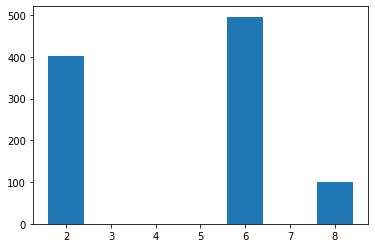

In [13]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


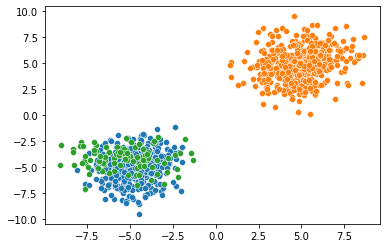

In [14]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

ValueError: The palette list has the wrong number of colors.

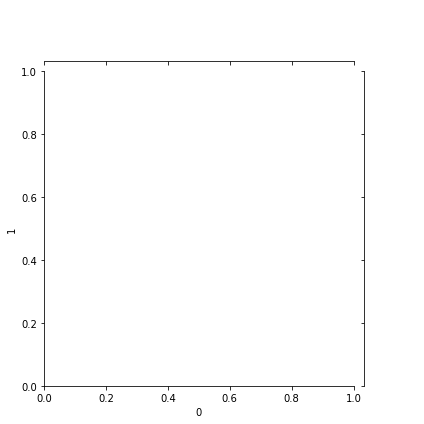

In [15]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [16]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

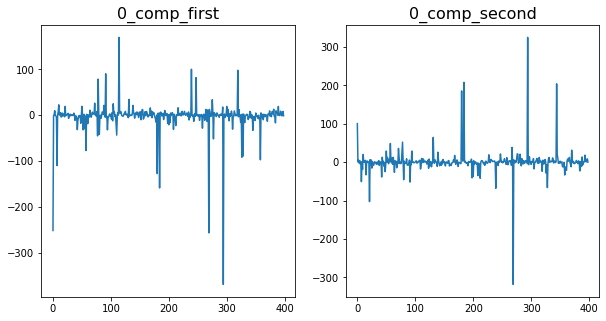

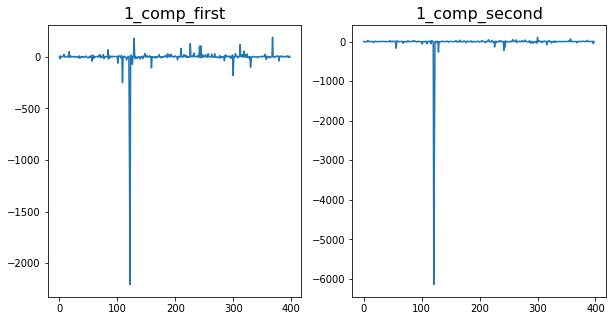

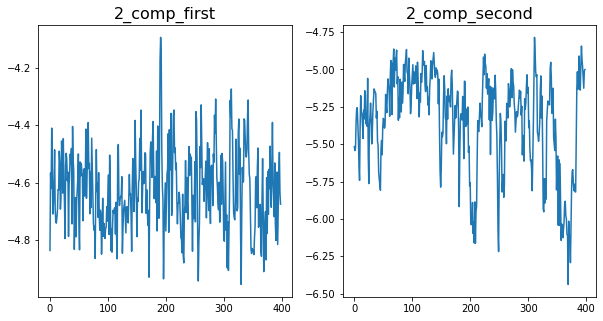

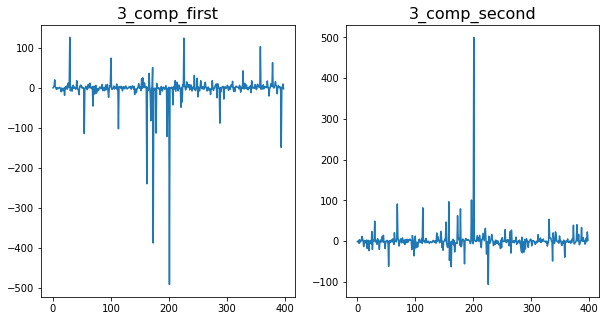

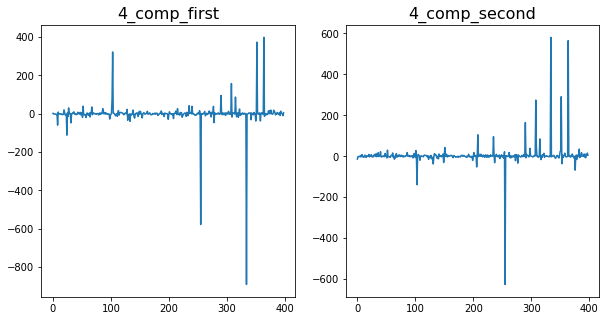

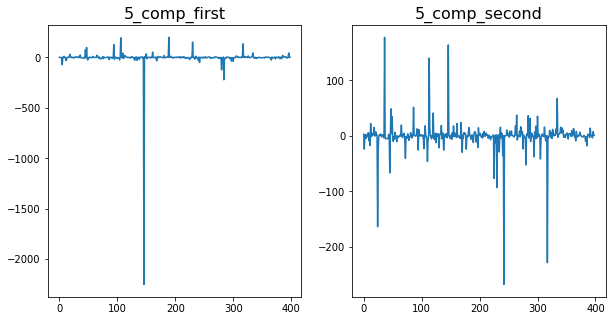

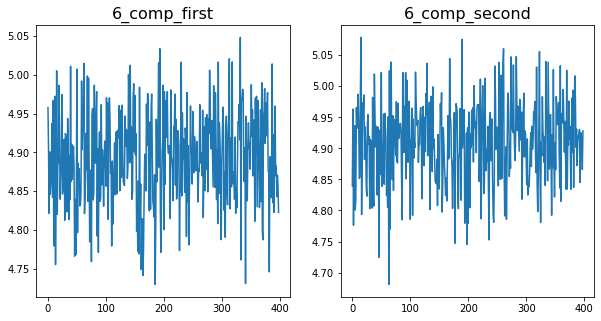

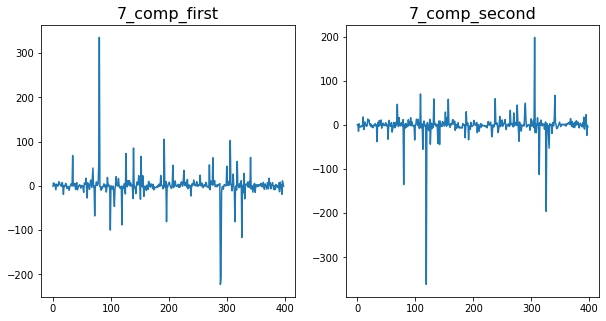

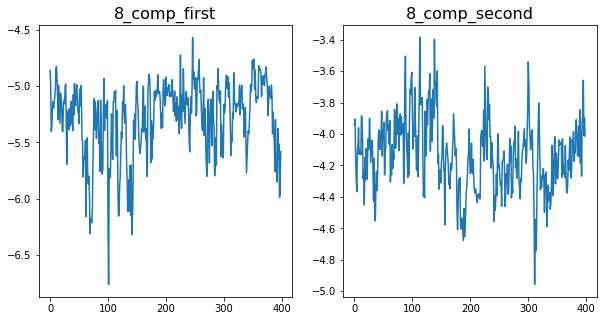

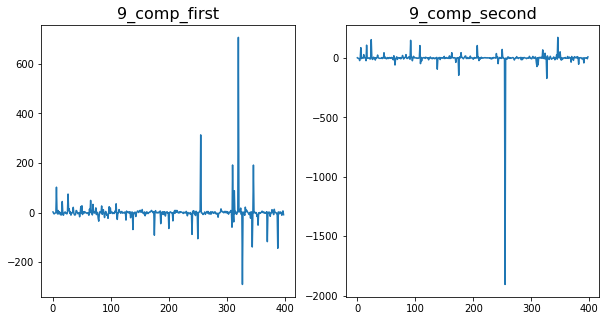

In [16]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

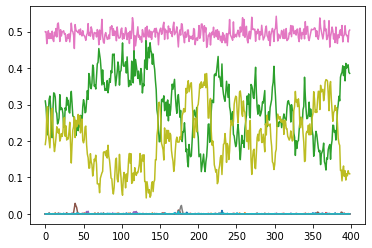

In [17]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [18]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


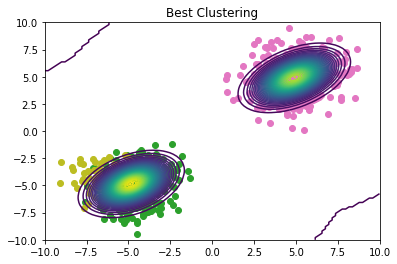

In [19]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)